# biosc - diagnostics: isochrones and $A(Li)$ model comparison

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path
import pymc as pm
import arviz as az
import bambi as bmb
import xarray as xr
import biosc
import biosc.preprocessing
import matplotlib.ticker as ticker

from pymc import HalfCauchy, Model, Normal, sample

import os
import matplotlib.cm as cm
from netCDF4 import Dataset as NetCDFFile
from scipy.stats import gaussian_kde

from biosc.preprocessing import Preprocessing
from biosc.bhm import BayesianModel

import sys
sys.path.append('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/')

import bmp
from bmp import BayesianModelPlots

In [2]:
plt.rcParams.update({'font.size': 14, 'axes.linewidth': 1, 'axes.edgecolor': 'k'})
plt.rcParams['font.family'] = 'serif'

data_file = 'test_ALi_low_clean_only_good.csv'
file = 'output_test_UCDs_low_clean_only_good_uninf.nc'
path_data = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/test_ALi_low_clean_only_good.csv'
path_models = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/BT-Settl_all_Myr_Gaia+2MASS+PanSTARRS.csv'
L = 10
priors = {
    'Age [Myr]': {'dist': 'uniform', 'lower': 60, 'upper': 150},
    'Distance [pc]': {'dist': 'normal', 'mu': 135, 'sigma': 20}
}
ages = [0.02, 0.08, 0.12, 0.5]
colormap = 'turbo'
plot_type = 'all'

bayesian_plots = BayesianModelPlots(data_file, priors, file, path_data, path_models, L, ages, colormap)
bayesian_plots.process_idata(plot_type=plot_type)

In [3]:
Jmag_lbda = 12350.00
Hmag_lbda = 16620.00
Kmag_lbda = 21590.00
BP_lbda = 5109.71
G_lbda = 6217.59
RP_lbda = 7769.02
gmag_lbda = 4849.11
rmag_lbda = 6201.20
wmag_lbda = 6285.91
imag_lbda = 7534.96
zmag_lbda = 8674.20
ymag_lbda = 9627.79


### Pleiades data

In [4]:
data_obs_Pleiades = pd.read_csv('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/Pleiades_DANCe+GDR3+2MASS+PanSTARRS1+A_Li+Lbol.csv')

data_obs_Pleiades.rename(columns={'g_error': 'e_g', 'rp_error': 'e_rp', 'bp_error': 'e_bp'}, inplace=True)
data_obs_Pleiades.columns

Index(['source_id', 'Mecayotl', 'Olivares+2018', 'Meingast+2021', 'l', 'b',
       'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error',
       'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'pmra_pmdec_corr',
       'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr',
       'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
       'parallax_pmra_corr', 'parallax_pmdec_corr', 'g', 'bp', 'rp', 'e_g',
       'e_bp', 'e_rp', 'dr3_radial_velocity', 'dr3_radial_velocity_error',
       'ruwe', 'astrometric_excess_noise', 'astrometric_params_solved',
       'bp_rp', 'g_rp', 'Jmag', 'Hmag', 'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag',
       'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag',
       'ymag', 'e_ymag', 'Name', 'EPIC', 'RAJ2000', 'DEJ2000', 'Vmag', 'J-K',
       'Per', 'Amp', 'l_WLi', 'WLi', 'e_WLi', 'Teff', 'ALi', 'e_ALi', 'Bin',
       'SimbadName', 'Teff_x', 'logg', '[Fe/H]', 'A0', 'AG', 'ABP', 'ARP',
       'E(BP-RP)', 'Rad', 'Li

In [5]:
distance_obs = 1 / (data_obs_Pleiades['parallax'] * 1e-3)
distance_mod_obs = 5 * np.log10(distance_obs) - 5  
data_obs_Pleiades['G_abs'] = data_obs_Pleiades['g'] - distance_mod_obs
data_obs_Pleiades['BP_abs'] = data_obs_Pleiades['bp'] - distance_mod_obs
data_obs_Pleiades['RP_abs'] = data_obs_Pleiades['rp'] - distance_mod_obs
data_obs_Pleiades['J_abs'] = data_obs_Pleiades['Jmag'] - distance_mod_obs
data_obs_Pleiades['H_abs'] = data_obs_Pleiades['Hmag'] - distance_mod_obs
data_obs_Pleiades['K_abs'] = data_obs_Pleiades['Kmag'] - distance_mod_obs
data_obs_Pleiades['R_abs'] = data_obs_Pleiades['rmag'] - distance_mod_obs
data_obs_Pleiades['I_abs'] = data_obs_Pleiades['imag'] - distance_mod_obs
data_obs_Pleiades['Y_abs'] = data_obs_Pleiades['ymag'] - distance_mod_obs
data_obs_Pleiades['Z_abs'] = data_obs_Pleiades['zmag'] - distance_mod_obs

data_obs_Pleiades['G-J'] = data_obs_Pleiades['G_abs']-data_obs_Pleiades['J_abs']
data_obs_Pleiades['G-RP'] = data_obs_Pleiades['G_abs']-data_obs_Pleiades['RP_abs']
data_obs_Pleiades['BP-RP'] = data_obs_Pleiades['BP_abs']-data_obs_Pleiades['RP_abs']

In [6]:
data_obs_Pleiades

,source_id,Mecayotl,Olivares+2018,Meingast+2021,l,b,ra,ra_error,dec,dec_error,...,J_abs,H_abs,K_abs,R_abs,I_abs,Y_abs,Z_abs,G-J,G-RP,BP-RP
0,66787119410915072,True,True,True,166.210733,-23.276099,56.662143,0.014997,24.520108,0.009073,...,5.391857,4.787857,4.635857,7.418857,6.972857,6.525157,6.694857,1.826829,0.810348,1.512766
1,64977705525131904,True,True,True,167.014088,-24.105530,56.647305,0.018675,23.411531,0.012227,...,5.953697,5.236697,5.031697,8.549097,7.790097,7.159997,7.424497,2.421177,1.006676,2.033531
2,65195404530870144,True,True,True,166.401835,-23.959280,56.302660,0.187139,23.895691,0.137836,...,9.255037,8.675037,8.247037,14.008637,12.001337,10.590737,11.072637,3.461519,1.369004,3.289309
3,64942001460286080,True,True,True,167.530351,-23.713150,57.315181,0.117257,23.380170,0.079404,...,8.715933,8.074933,7.819933,13.164333,11.330633,10.050533,10.483733,3.319764,1.337366,3.338682
4,64433924008996224,True,True,True,167.187075,-25.469587,55.777180,0.158969,22.296886,0.108396,...,9.062755,8.470755,8.112755,13.654355,11.738355,10.399955,10.850355,3.404532,1.361330,3.481064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,68045583484082048,True,True,True,164.243788,-25.259933,53.747213,0.023608,24.204450,0.018528,...,6.446093,5.782093,5.602093,9.355493,8.326793,7.636193,7.872993,2.526645,1.083299,2.277171
942,65113559634339200,True,True,True,165.803768,-25.252330,54.921665,0.014164,23.290687,0.010935,...,3.219775,2.985775,2.933775,4.161775,4.078775,4.069775,4.064775,0.890571,0.437847,0.711143
943,64987876007763968,True,True,True,167.304764,-23.830079,57.063558,0.061383,23.434686,0.049673,...,7.730459,7.171459,6.880459,11.529959,10.045959,9.017459,9.351059,3.020585,1.246986,2.865516
944,71056252479453056,True,True,True,163.033014,-22.724805,54.616063,0.095418,26.856932,0.065394,...,7.997061,7.384061,7.135061,12.175861,10.479061,9.307561,9.688561,3.192930,1.292702,3.159868


In [7]:
data_obs_Pleiades['Teff_x']

0      4410.5390
1      3664.9885
2            NaN
3      3131.1300
4      3092.2827
         ...    
941    3602.4023
942    6055.7964
943    3315.6130
944    3214.3660
945    4741.1820
Name: Teff_x, Length: 946, dtype: float64

In [8]:
np.mean(data_obs_Pleiades['ALi'])

2.227078431372549

In [9]:
#sigma = 5.67e-8  # W/m²/K⁴
solar_abundance = 1.05
e_solar_abundance = 0.10
Tsun = 5772
Zsun = 0.01524
#Asplund et al. 2009

data_obs_Pleiades['Lsun'] = data_obs_Pleiades['Rad']**2 * (data_obs_Pleiades['Teff_x']/Tsun)**4 #883

In [10]:
data_obs_Pleiades['log(L/Lsun)'] = np.log10(data_obs_Pleiades['Lsun'])

In [11]:
data_obs_Pleiades.columns

Index(['source_id', 'Mecayotl', 'Olivares+2018', 'Meingast+2021', 'l', 'b',
       'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error',
       'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'pmra_pmdec_corr',
       'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr',
       'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
       'parallax_pmra_corr', 'parallax_pmdec_corr', 'g', 'bp', 'rp', 'e_g',
       'e_bp', 'e_rp', 'dr3_radial_velocity', 'dr3_radial_velocity_error',
       'ruwe', 'astrometric_excess_noise', 'astrometric_params_solved',
       'bp_rp', 'g_rp', 'Jmag', 'Hmag', 'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag',
       'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag',
       'ymag', 'e_ymag', 'Name', 'EPIC', 'RAJ2000', 'DEJ2000', 'Vmag', 'J-K',
       'Per', 'Amp', 'l_WLi', 'WLi', 'e_WLi', 'Teff', 'ALi', 'e_ALi', 'Bin',
       'SimbadName', 'Teff_x', 'logg', '[Fe/H]', 'A0', 'AG', 'ABP', 'ARP',
       'E(BP-RP)', 'Rad', 'Li

### PARSEC

In [12]:
lib = ['Gaia', '2MASS', 'PanSTARRS']

PARSEC_iso_omega_00_Phot = {}

for l in lib:
    data = np.loadtxt('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/PARSEC_iso_omega_00_'+l+'.dat')
    
    # Leer la fila 15 para obtener los nombres de las columnas
    with open('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/PARSEC_iso_omega_00_'+l+'.dat', 'r') as file:
        for i, line in enumerate(file):
            if i == 14:
                columns = line.strip().lstrip('#').split()
                break
    
    # Crear un DataFrame con los datos y los nombres de las columnas
    dataframe = pd.DataFrame(data, columns=columns)
    
    dataframe.rename(columns={'Mass': 'M/Ms'}, inplace=True)
    
    # Guardar el DataFrame en el diccionario con el nombre correspondiente
    PARSEC_iso_omega_00_Phot[l] = dataframe
    
    PARSEC_iso_omega_00_Phot[l]['Age [Gyr]'] = (10**(PARSEC_iso_omega_00_Phot[l]['logAge']))/(1e9)
    
common_columns = PARSEC_iso_omega_00_Phot['Gaia'].columns[:35]

dataframes_concatenate = [df for df in PARSEC_iso_omega_00_Phot.values()]

dataframe_final = pd.concat(dataframes_concatenate, axis=1)

dataframe_final = dataframe_final.loc[:,~dataframe_final.columns.duplicated()]

dataframe_final.to_csv('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/PARSEC_iso_omega_00_Phot.csv', index=False)

PARSEC_iso_omega_00_Phot_dict = {}

for age in dataframe_final['Age [Gyr]'].unique():
    dataframe_by_age = dataframe_final[dataframe_final['Age [Gyr]'] == age]
    dataframe_by_age = dataframe_by_age.loc[dataframe_by_age['G_i00'] > 0].reset_index(drop=True)
    dataframe_by_age['Teff'] = 10**dataframe_by_age['logTe']
    dataframe_by_age['Lsun'] = 10**dataframe_by_age['logL']
    PARSEC_iso_omega_00_Phot_dict[age] = dataframe_by_age


In [13]:
dataframe_final

,Zini,MH,logAge,Mini,int_IMF,M/Ms,logL,logTe,logg,label,...,wP1_i45,wP1_i50,wP1_i55,wP1_i60,wP1_i65,wP1_i70,wP1_i75,wP1_i80,wP1_i85,wP1_i90
0,0.01471,0.0,6.30103,0.090000,1.081690,0.090,-1.379,3.4384,3.477,0.0,...,10.378,10.378,10.378,10.378,10.378,10.378,10.378,10.378,10.378,10.378
1,0.01471,0.0,6.30103,0.097813,1.152571,0.098,-1.307,3.4443,3.465,0.0,...,10.112,10.112,10.112,10.112,10.112,10.112,10.112,10.112,10.112,10.112
2,0.01471,0.0,6.30103,0.100000,1.171106,0.100,-1.288,3.4459,3.462,0.0,...,10.042,10.042,10.042,10.042,10.042,10.042,10.042,10.042,10.042,10.042
3,0.01471,0.0,6.30103,0.100258,1.173256,0.100,-1.286,3.4461,3.461,0.0,...,10.035,10.035,10.035,10.035,10.035,10.035,10.035,10.035,10.035,10.035
4,0.01471,0.0,6.30103,0.109296,1.244379,0.109,-1.224,3.4508,3.455,0.0,...,9.811,9.811,9.811,9.811,9.811,9.811,9.811,9.811,9.811,9.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41620,0.01471,0.0,8.77597,2.692088,2.589498,2.690,2.284,3.6668,2.203,7.0,...,-0.810,-0.810,-0.810,-0.810,-0.810,-0.810,-0.810,-0.810,-0.810,-0.810
41621,0.01471,0.0,8.77597,2.692170,2.589500,2.690,2.276,3.6678,2.215,7.0,...,-0.793,-0.793,-0.793,-0.793,-0.793,-0.793,-0.793,-0.793,-0.793,-0.793
41622,0.01471,0.0,8.77597,2.692199,2.589501,2.690,2.250,3.6700,2.249,7.0,...,-0.737,-0.737,-0.737,-0.737,-0.737,-0.737,-0.737,-0.737,-0.737,-0.737
41623,0.01471,0.0,8.77597,2.692242,2.589502,2.690,2.217,3.6727,2.294,7.0,...,-0.663,-0.663,-0.663,-0.663,-0.663,-0.663,-0.663,-0.663,-0.663,-0.663


In [14]:
dataframe_final['Z']

0        0.01476
1        0.01476
2        0.01476
3        0.01476
4        0.01476
          ...   
41620    0.01487
41621    0.01487
41622    0.01487
41623    0.01487
41624    0.01487
Name: Z, Length: 41625, dtype: float64

In [15]:
dataframe_final['Y']

0        0.2745
1        0.2745
2        0.2745
3        0.2745
4        0.2745
          ...  
41620    0.3042
41621    0.3042
41622    0.3042
41623    0.3042
41624    0.3042
Name: Y, Length: 41625, dtype: float64

In [16]:
10**dataframe_final['logAge'][5]

2000000.0199681043

In [17]:
10**dataframe_final['logAge'][346]

7000031.591308976

In [18]:
10**dataframe_final['logAge'][346]-10**dataframe_final['logAge'][345]

5000031.571340871

In [19]:
10**dataframe_final['logAge'][41624]

596994046.2717156

In [20]:
10**dataframe_final['logAge'][706]-10**dataframe_final['logAge'][346]

4999933.979172183

In [21]:
print(PARSEC_iso_omega_00_Phot['Gaia'].columns.tolist())

['Zini', 'MH', 'logAge', 'Mini', 'int_IMF', 'M/Ms', 'logL', 'logTe', 'logg', 'label', 'McoreTP', 'C_O', 'period0', 'period1', 'period2', 'period3', 'period4', 'pmode', 'Mloss', 'tau1m', 'X', 'Y', 'Xc', 'Xn', 'Xo', 'Cexcess', 'Z', 'Teff0', 'omega', 'angvel', 'vtaneq', 'angmom', 'Rpol', 'Req', 'mbolmag', 'G_fSBmag', 'G_BP_fSBmag', 'G_RP_fSBmag', 'G_fSB', 'G_f0', 'G_fk', 'G_i00', 'G_i05', 'G_i10', 'G_i15', 'G_i20', 'G_i25', 'G_i30', 'G_i35', 'G_i40', 'G_i45', 'G_i50', 'G_i55', 'G_i60', 'G_i65', 'G_i70', 'G_i75', 'G_i80', 'G_i85', 'G_i90', 'G_BP_fSB', 'G_BP_f0', 'G_BP_fk', 'G_BP_i00', 'G_BP_i05', 'G_BP_i10', 'G_BP_i15', 'G_BP_i20', 'G_BP_i25', 'G_BP_i30', 'G_BP_i35', 'G_BP_i40', 'G_BP_i45', 'G_BP_i50', 'G_BP_i55', 'G_BP_i60', 'G_BP_i65', 'G_BP_i70', 'G_BP_i75', 'G_BP_i80', 'G_BP_i85', 'G_BP_i90', 'G_RP_fSB', 'G_RP_f0', 'G_RP_fk', 'G_RP_i00', 'G_RP_i05', 'G_RP_i10', 'G_RP_i15', 'G_RP_i20', 'G_RP_i25', 'G_RP_i30', 'G_RP_i35', 'G_RP_i40', 'G_RP_i45', 'G_RP_i50', 'G_RP_i55', 'G_RP_i60', 'G_RP_

In [22]:
PARSEC_iso_omega_00_Phot_dict = {round(key, 3): value for key, value in PARSEC_iso_omega_00_Phot_dict.items()}


In [23]:
PARSEC_iso_omega_00_Phot_dict.keys()

dict_keys([0.002, 0.007, 0.012, 0.017, 0.022, 0.027, 0.032, 0.037, 0.042, 0.047, 0.052, 0.057, 0.062, 0.067, 0.072, 0.077, 0.082, 0.087, 0.092, 0.097, 0.102, 0.107, 0.112, 0.117, 0.122, 0.127, 0.132, 0.137, 0.142, 0.147, 0.152, 0.157, 0.162, 0.167, 0.172, 0.177, 0.182, 0.187, 0.192, 0.197, 0.202, 0.207, 0.212, 0.217, 0.222, 0.227, 0.232, 0.237, 0.242, 0.247, 0.252, 0.257, 0.262, 0.267, 0.272, 0.277, 0.282, 0.287, 0.292, 0.297, 0.302, 0.307, 0.312, 0.317, 0.322, 0.327, 0.332, 0.337, 0.342, 0.347, 0.352, 0.357, 0.362, 0.367, 0.372, 0.377, 0.382, 0.387, 0.392, 0.397, 0.402, 0.407, 0.412, 0.417, 0.422, 0.427, 0.432, 0.437, 0.442, 0.447, 0.452, 0.457, 0.462, 0.467, 0.472, 0.477, 0.482, 0.487, 0.492, 0.497, 0.502, 0.507, 0.512, 0.517, 0.522, 0.527, 0.532, 0.537, 0.542, 0.547, 0.552, 0.557, 0.562, 0.567, 0.572, 0.577, 0.582, 0.587, 0.592, 0.597])

In [24]:
PARSEC_iso_omega_00_Phot_dict[0.122]

,Zini,MH,logAge,Mini,int_IMF,M/Ms,logL,logTe,logg,label,...,wP1_i55,wP1_i60,wP1_i65,wP1_i70,wP1_i75,wP1_i80,wP1_i85,wP1_i90,Teff,Lsun
0,0.01471,0.0,8.08636,0.090000,1.081690,0.090,-2.818,3.4010,4.766,0.0,...,14.470,14.470,14.470,14.470,14.470,14.470,14.470,14.470,2517.676928,0.001521
1,0.01471,0.0,8.08636,0.091255,1.093600,0.091,-2.808,3.4024,4.768,0.0,...,14.445,14.445,14.445,14.445,14.445,14.445,14.445,14.445,2525.806055,0.001556
2,0.01471,0.0,8.08636,0.098871,1.161602,0.099,-2.744,3.4117,4.776,0.0,...,14.267,14.267,14.267,14.267,14.267,14.267,14.267,14.267,2580.477044,0.001803
3,0.01471,0.0,8.08636,0.100000,1.171106,0.100,-2.735,3.4131,4.777,0.0,...,14.229,14.229,14.229,14.229,14.229,14.229,14.229,14.229,2588.808942,0.001841
4,0.01471,0.0,8.08636,0.100865,1.178290,0.101,-2.729,3.4140,4.778,0.0,...,14.205,14.205,14.205,14.205,14.205,14.205,14.205,14.205,2594.179362,0.001866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,0.01471,0.0,8.08636,2.699229,2.589651,2.699,1.794,4.0560,4.252,1.0,...,0.913,0.913,0.913,0.913,0.913,0.913,0.913,0.913,11376.272858,62.230029
121,0.01471,0.0,8.08636,2.800000,2.591712,2.800,1.862,4.0656,4.238,1.0,...,0.792,0.792,0.792,0.792,0.792,0.792,0.792,0.792,11630.543233,72.777980
122,0.01471,0.0,8.08636,3.000000,2.595334,3.000,1.992,4.0829,4.207,1.0,...,0.560,0.560,0.560,0.560,0.560,0.560,0.560,0.560,12103.194151,98.174794
123,0.01471,0.0,8.08636,3.181551,2.598173,3.181,2.105,4.0971,4.176,1.0,...,0.356,0.356,0.356,0.356,0.356,0.356,0.356,0.356,12505.469461,127.350308


In [25]:
PARSEC_iso_omega_00_Phot_dict[0.122]['Y']

0      0.2745
1      0.2745
2      0.2745
3      0.2745
4      0.2745
        ...  
120    0.2746
121    0.2746
122    0.2746
123    0.2746
124    0.2746
Name: Y, Length: 125, dtype: float64

In [26]:
PARSEC_iso_omega_00_Phot_dict[0.122]['Z']

0      0.01476
1      0.01476
2      0.01476
3      0.01476
4      0.01476
        ...   
120    0.01476
121    0.01476
122    0.01476
123    0.01476
124    0.01476
Name: Z, Length: 125, dtype: float64

In [27]:
Zini = 0.01471

Yini = 0.2485 + 1.78*Zini
Yini

0.2746838

In [28]:
lib = ['Gaia', '2MASS', 'PanSTARRS']

PARSEC_iso_omega_00_sun_Phot = {}

for l in lib:
    data = np.loadtxt('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/PARSEC_iso_omega_00_sun_'+l+'.dat')
    
    # Leer la fila 15 para obtener los nombres de las columnas
    with open('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/PARSEC_iso_omega_00_'+l+'.dat', 'r') as file:
        for i, line in enumerate(file):
            if i == 14:
                columns = line.strip().lstrip('#').split()
                break
    
    # Crear un DataFrame con los datos y los nombres de las columnas
    dataframe = pd.DataFrame(data, columns=columns)
    
    dataframe.rename(columns={'Mass': 'M/Ms'}, inplace=True)
    
    # Guardar el DataFrame en el diccionario con el nombre correspondiente
    PARSEC_iso_omega_00_sun_Phot[l] = dataframe
    
    PARSEC_iso_omega_00_sun_Phot[l]['Age [Gyr]'] = (10**(PARSEC_iso_omega_00_sun_Phot[l]['logAge']))/(1e9)
    
common_columns = PARSEC_iso_omega_00_sun_Phot['Gaia'].columns[:35]

dataframes_concatenate = [df for df in PARSEC_iso_omega_00_sun_Phot.values()]

dataframe_final = pd.concat(dataframes_concatenate, axis=1)

dataframe_final = dataframe_final.loc[:,~dataframe_final.columns.duplicated()]

dataframe_final.to_csv('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/PARSEC_iso_omega_00_Phot.csv', index=False)

PARSEC_iso_omega_00_sun_Phot_dict = {}

for age in dataframe_final['Age [Gyr]'].unique():
    dataframe_by_age = dataframe_final[dataframe_final['Age [Gyr]'] == age]
    dataframe_by_age = dataframe_by_age.loc[dataframe_by_age['G_i00'] > 0].reset_index(drop=True)
    dataframe_by_age['Teff'] = 10**dataframe_by_age['logTe']
    dataframe_by_age['Lsun'] = 10**dataframe_by_age['logL']
    PARSEC_iso_omega_00_sun_Phot_dict[round(age,3)] = dataframe_by_age


In [29]:
PARSEC_iso_omega_00_sun_Phot_dict[0.122]

,Zini,MH,logAge,Mini,int_IMF,M/Ms,logL,logTe,logg,label,...,wP1_i55,wP1_i60,wP1_i65,wP1_i70,wP1_i75,wP1_i80,wP1_i85,wP1_i90,Teff,Lsun
0,0.00713,-0.3272,8.08636,0.090000,1.081690,0.090,-2.769,3.4339,4.849,0.0,...,13.741,13.741,13.741,13.741,13.741,13.741,13.741,13.741,2715.813858,0.001702
1,0.00713,-0.3272,8.08636,0.090711,1.088470,0.091,-2.764,3.4346,4.850,0.0,...,13.717,13.717,13.717,13.717,13.717,13.717,13.717,13.717,2720.194762,0.001722
2,0.00713,-0.3272,8.08636,0.096212,1.138659,0.096,-2.721,3.4400,4.855,0.0,...,13.526,13.526,13.526,13.526,13.526,13.526,13.526,13.526,2754.228703,0.001901
3,0.00713,-0.3272,8.08636,0.099697,1.168569,0.100,-2.694,3.4436,4.857,0.0,...,13.404,13.404,13.404,13.404,13.404,13.404,13.404,13.404,2777.154236,0.002023
4,0.00713,-0.3272,8.08636,0.105658,1.216707,0.106,-2.653,3.4488,4.862,0.0,...,13.224,13.224,13.224,13.224,13.224,13.224,13.224,13.224,2810.606200,0.002223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0.00713,-0.3272,8.08636,3.026102,2.595767,3.025,2.093,4.1248,4.277,1.0,...,0.568,0.568,0.568,0.568,0.568,0.568,0.568,0.568,13329.074642,123.879659
161,0.00713,-0.3272,8.08636,3.171499,2.598026,3.170,2.183,4.1354,4.250,1.0,...,0.405,0.405,0.405,0.405,0.405,0.405,0.405,0.405,13658.405431,152.405275
162,0.00713,-0.3272,8.08636,3.181142,2.598167,3.180,2.189,4.1361,4.248,1.0,...,0.394,0.394,0.394,0.394,0.394,0.394,0.394,0.394,13680.437931,154.525444
163,0.00713,-0.3272,8.08636,3.362140,2.600650,3.360,2.297,4.1477,4.210,1.0,...,0.191,0.191,0.191,0.191,0.191,0.191,0.191,0.191,14050.765963,198.152703


In [30]:
PARSEC_iso_omega_00_sun_Phot_dict[0.122]['Y']

0      0.2615
1      0.2615
2      0.2615
3      0.2615
4      0.2615
        ...  
160    0.2614
161    0.2614
162    0.2614
163    0.2614
164    0.2614
Name: Y, Length: 165, dtype: float64

In [31]:
PARSEC_iso_omega_00_sun_Phot_dict[0.122]['Z']

0      0.0072
1      0.0072
2      0.0072
3      0.0072
4      0.0072
        ...  
160    0.0072
161    0.0072
162    0.0072
163    0.0072
164    0.0072
Name: Z, Length: 165, dtype: float64

In [32]:
PARSEC_iso_omega_00_Phot_dict = {round(key, 3): value for key, value in PARSEC_iso_omega_00_Phot_dict.items()}
PARSEC_iso_omega_00_sun_Phot_dict = {round(key, 3): value for key, value in PARSEC_iso_omega_00_sun_Phot_dict.items()}


In [33]:
PARSEC_iso_omega_00_sun_Phot_dict.keys()

dict_keys([0.002, 0.007, 0.012, 0.017, 0.022, 0.027, 0.032, 0.037, 0.042, 0.047, 0.052, 0.057, 0.062, 0.067, 0.072, 0.077, 0.082, 0.087, 0.092, 0.097, 0.102, 0.107, 0.112, 0.117, 0.122, 0.127, 0.132, 0.137, 0.142, 0.147, 0.152, 0.157, 0.162, 0.167, 0.172, 0.177, 0.182, 0.187, 0.192, 0.197, 0.202, 0.207, 0.212, 0.217, 0.222, 0.227, 0.232, 0.237, 0.242, 0.247, 0.252, 0.257, 0.262, 0.267, 0.272, 0.277, 0.282, 0.287, 0.292, 0.297, 0.302, 0.307, 0.312, 0.317, 0.322, 0.327, 0.332, 0.337, 0.342, 0.347, 0.352, 0.357, 0.362, 0.367, 0.372, 0.377, 0.382, 0.387, 0.392, 0.397, 0.402, 0.407, 0.412, 0.417, 0.422, 0.427, 0.432, 0.437, 0.442, 0.447, 0.452, 0.457, 0.462, 0.467, 0.472, 0.477, 0.482, 0.487, 0.492, 0.497, 0.502, 0.507, 0.512, 0.517, 0.522, 0.527, 0.532, 0.537, 0.542, 0.547, 0.552, 0.557, 0.562, 0.567, 0.572, 0.577, 0.582, 0.587, 0.592, 0.597])

In [34]:
10**min(PARSEC_iso_omega_00_sun_Phot_dict[0.122]['logTe'])

2715.8138575883313

In [35]:
10**max(PARSEC_iso_omega_00_sun_Phot_dict[0.122]['logTe'])

14063.713158132898

In [36]:
Zini = 0.00713

Yini = 0.2485 + 1.78*Zini
Yini

0.2611914

In [37]:
max(10**dataframe_final['logTe'])

31145.83654012135

In [38]:
min(10**dataframe_final['logTe'])

2518.2567110425944

### BT-Settl

In [176]:
path_models = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/BT-Settl_all_Myr_Gaia+2MASS+PanSTARRS.csv'


In [177]:
BTSettl = pd.read_csv(path_models)
BTSettl

,age_Myr,t(Gyr),M/Ms,Teff(K),L/Ls,lg(g),R(Gcm),D,Li,G,G_BP,G_RP,J,H,K,g_p1,r_p1,i_p1,y_p1,z_p1
0,1.0,0.001,0.010,2345.0,-2.70,3.57,18.99,1.00,1.0000,14.055,17.784799,12.4668,9.328,8.770,8.353,17.937,17.095,13.757,12.125,11.009
1,1.0,0.001,0.015,2504.0,-2.42,3.58,22.90,1.00,1.0000,13.015,16.269800,11.4758,8.667,8.135,7.751,16.291,15.787,12.540,11.155,10.214
2,1.0,0.001,0.020,2598.0,-2.25,3.59,26.11,1.00,1.0000,12.381,15.366800,10.8708,8.238,7.710,7.347,15.366,14.935,11.827,10.566,9.722
3,1.0,0.001,0.030,2710.0,-1.98,3.57,32.78,1.00,1.0000,11.507,14.182800,10.0358,7.582,7.054,6.720,14.194,13.747,10.885,9.754,9.006
4,1.0,0.001,0.040,2779.0,-1.81,3.57,37.62,0.99,1.0000,10.990,13.496800,9.5408,7.188,6.652,6.338,13.512,13.061,10.339,9.275,8.580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,10000.0,10.000,0.500,3689.0,-1.43,4.78,33.05,0.00,0.0000,8.937,9.932800,7.9128,6.589,5.944,5.721,10.162,9.297,8.342,7.936,7.713
834,10000.0,10.000,0.600,4013.0,-1.12,4.70,39.92,0.00,0.0000,7.960,8.747800,7.0678,5.926,5.237,5.059,9.010,8.100,7.463,7.188,7.015
835,10000.0,10.000,0.700,4493.0,-0.79,4.63,46.43,0.00,0.0000,6.900,7.487800,6.1598,5.244,4.614,4.490,7.754,6.870,6.537,6.392,6.271
836,10000.0,10.000,0.800,5002.0,-0.47,4.55,54.44,0.00,0.0000,5.925,6.365800,5.3108,4.580,4.098,4.000,6.529,5.885,5.675,5.594,5.525


In [178]:
min(BTSettl['Teff(K)'])

1206.0

In [179]:
max(BTSettl['Teff(K)'])

6768.0

In [180]:
BTSettl.rename(columns={
    'age_Myr': 'age_Gyr',
    'Teff(K)': 'Teff',
    'L/Ls': 'log(L/Lsun)',
    'G': 'G_abs',
    'G_RP': 'RP_abs',
    'G_BP': 'BP_abs',
    'J': 'J_abs',
    'r_p1': 'r',
    'i_p1': 'i',
    'y_p1': 'y',
    'z_p1': 'z'}, inplace=True)

BTSettl['age_Gyr'] *= 0.001
BTSettl['A(Li)'] = np.log10(BTSettl['Li']) + 3.3
BTSettl['Lsun'] = 10**BTSettl['log(L/Lsun)']


# Create a dictionary to store dataframes for each isochrone
BTSettl_Li_isochrones = {}

# Loop over each row in the model dataframe
for index, row in BTSettl.iterrows():
    # Get the value of age_Gyr from the current row
    age_Gyr = row['age_Gyr']

    # Check if the value of age_Gyr already exists as a key in the dictionary
    if age_Gyr not in BTSettl_Li_isochrones:
        # If it doesn't exist, create a new entry in the dictionary with the value of age_Gyr as the key
        BTSettl_Li_isochrones[age_Gyr] = []

    # Add the current row to the corresponding value of age_Gyr in the dictionary
    BTSettl_Li_isochrones[age_Gyr].append(row)

# Convert each list of rows into a dataframe and replace the list in the dictionary
for age_Gyr, rows in BTSettl_Li_isochrones.items():
    BTSettl_Li_isochrones[age_Gyr] = pd.DataFrame(rows)



/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/biosc_env/lib64/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [181]:
BTSettl_Li_isochrones.keys()

dict_keys([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])

In [182]:
BTSettl_Li_isochrones[0.08]

,age_Gyr,t(Gyr),M/Ms,Teff,log(L/Lsun),lg(g),R(Gcm),D,Li,G_abs,...,J_abs,H,K,g_p1,r,i,y,z,A(Li),Lsun
413,0.08,0.08,0.015,1372.0,-4.26,4.37,9.27,0.0,1.0000,18.989000,...,13.908,12.584,11.858,24.678,21.378,19.516,16.866,15.762,3.300000,0.000055
414,0.08,0.08,0.020,1489.0,-4.14,4.52,8.96,0.0,1.0000,18.673999,...,13.846,12.482,11.568,23.584,20.346,18.428,16.775,15.814,3.300000,0.000072
415,0.08,0.08,0.030,2047.0,-3.58,4.69,9.04,0.0,1.0000,16.920000,...,11.571,10.822,10.415,21.883,19.166,16.955,14.981,13.679,3.300000,0.000263
416,0.08,0.08,0.040,2387.0,-3.26,4.75,9.66,0.0,1.0000,15.312000,...,10.695,10.116,9.778,19.737,17.984,15.064,13.363,12.332,3.300000,0.000550
417,0.08,0.08,0.050,2586.0,-3.06,4.79,10.37,0.0,0.9990,14.424000,...,10.248,9.681,9.358,18.124,16.974,13.918,12.557,11.733,3.299565,0.000871
418,0.08,0.08,0.060,2709.0,-2.92,4.81,11.06,0.0,0.9850,13.815000,...,9.942,9.366,9.055,16.715,16.015,13.190,12.044,11.367,3.293436,0.001202
419,0.08,0.08,0.070,2829.0,-2.78,4.82,11.84,0.0,0.8640,13.279000,...,9.654,9.083,8.780,15.923,15.103,12.590,11.590,11.002,3.236514,0.001660
420,0.08,0.08,0.072,2845.0,-2.76,4.82,11.98,0.0,0.8010,13.212000,...,9.610,9.038,8.738,15.831,15.005,12.519,11.530,10.954,3.203633,0.001738
421,0.08,0.08,0.075,2869.0,-2.73,4.82,12.21,0.0,0.6800,13.110000,...,9.541,8.969,8.673,15.693,14.858,12.411,11.438,10.880,3.132509,0.001862
422,0.08,0.08,0.080,2905.0,-2.69,4.83,12.58,0.0,0.4070,12.952000,...,9.434,8.862,8.571,15.478,14.632,12.244,11.297,10.763,2.909594,0.002042


In [183]:
max(BTSettl_Li_isochrones[0.120]['Teff'])

6767.0

In [184]:
min(BTSettl_Li_isochrones[0.120]['Teff'])

1304.0

In [185]:
min(BTSettl['Teff'])

1206.0

In [186]:
max(BTSettl['Teff'])

6768.0

### MIST

In [50]:
import sys
sys.path.append('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/')

import read_mist_models

import shutil

import os


def isocmd_to_dataframe(isocmd_set, ages):
    data_dict = {}
    for age, isocmd in zip(ages, isocmd_set):
        data_dict[age] = pd.DataFrame(isocmd)
    return data_dict

def iso_to_dataframe(iso_set, ages):
    data_dict = {}
    for age, iso in zip(ages, iso_set):
        data_dict[age] = pd.DataFrame(iso)
    return data_dict

column_mapping = {
    'star_mass': 'M/Ms',
    'Gaia_G_EDR3': 'G',
    'Gaia_BP_EDR3': 'BP',
    'Gaia_RP_EDR3': 'RP',
    '2MASS_J': 'J',
    '2MASS_H': 'H',
    '2MASS_Ks': 'K',
    'PS_g': 'g',
    'PS_r': 'r',
    'PS_i': 'i',
    'PS_z': 'z',
    'PS_y': 'y',
    'PS_w': 'w'
}


def files_show(path):
    if os.path.isdir(path):
        files = os.listdir(path)
        for file in files:
            print(file)
    else:
        print('Error')
        
        
def PG2_files(vvcrit):
    
    vvcrit = str(vvcrit)
    
    path_G2 = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_vvcrit'+vvcrit+'_UBVRIplus/'

    files_show(path_G2)

    path_P = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_vvcrit'+vvcrit+'_PanSTARRS/'

    files_show(path_P)
    
    path = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_vvcrit'+vvcrit+'_full_isos/'

    files_show(path)
    
    return path_G2, path_P, path
        
PG2_files(0.0)



def file_copy(phot, vvcrit, feh):
    
    vvcrit = str(vvcrit)
    
    source_directory = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_vvcrit'+vvcrit+'_'+phot+'/'
    target_directory = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/'
    
    file_name = 'MIST_v1.2_feh_'+feh+'_afe_p0.0_vvcrit0.0_'+phot+'.iso.cmd'
    
    source_path = os.path.join(source_directory, file_name)
    
    file_name = os.path.basename(source_path)
    
    target_path = os.path.join(target_directory, file_name)
    
    shutil.copy(source_path, target_path)


phot = 'UBVRIplus'

feh = 'm0.25'

vvcrit = 0.0
    
file_copy(phot, vvcrit, feh)



MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd
MIST_v1.2_feh_m1.25_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd
MIST_v1.2_feh_m3.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd
MIST_v1.2_feh_m1.75_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd
MIST_v1.2_feh_m0.25_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd
MIST_v1.2_feh_m4.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd
MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd
MIST_v1.2_feh_m0.50_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd
MIST_v1.2_feh_m2.50_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd
MIST_v1.2_feh_m1.50_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd
MIST_v1.2_feh_m1.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd
MIST_v1.2_feh_m3.50_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd
MIST_v1.2_feh_m2.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd
MIST_v1.2_feh_m0.75_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd
MIST_v1.2_feh_p0.25_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd
MIST_v1.2_feh_m2.50_afe_p0.0_vvcrit0.0_PanSTARRS.iso.cmd
MIST_v1.2_feh_m3.50_afe_p0.0_vvcrit0.0_PanSTARRS.iso.cmd
MIST_v1.2_feh_m2.00_afe_p0.0_vv

[Fe/H] for Pleiades: +0.042 (Soderblom et al. 2009).

In [51]:
class ISO:
    """
    Reads in MIST isochrone files.
    """
    def __init__(self, filename, verbose=True):
        """
        Args:
            filename: the name of .iso file.
        """
        self.filename = filename
        if verbose:
            print('Reading in: ' + self.filename)
        self.version, self.abun, self.rot, self.ages, self.num_ages, self.hdr_list, self.isos = self.read_iso_file()

    def read_iso_file(self):
        """
        Reads in the isochrone file.
        """
        # Open file and read it in
        with open(self.filename) as f:
            content = [line.split() for line in f]
        version = {'MIST': content[0][-1], 'MESA': content[1][-1]}
        abun = {content[3][i]: float(content[4][i]) for i in range(1, 5)}
        rot = float(content[4][-1])
        num_ages = int(content[6][-1])

        # Read one block for each isochrone
        iso_set = []
        ages = []
        counter = 0
        data = content[8:]
        for i_age in range(num_ages):
            # Grab info for each isochrone
            num_eeps = int(data[counter][-2])
            num_cols = int(data[counter][-1])
            hdr_list = data[counter + 2][1:]
            formats = tuple([np.int32] + [np.float64 for i in range(num_cols - 1)])
            iso = np.zeros((num_eeps), {'names': tuple(hdr_list), 'formats': tuple(formats)})
            # Read through EEPs for each isochrone
            for eep in range(num_eeps):
                iso_chunk = data[3 + counter + eep]
                iso[eep] = tuple(iso_chunk)
            iso_set.append(iso)
            ages.append(iso[0][1])
            counter += 3 + num_eeps + 2
        return version, abun, rot, ages, num_ages, hdr_list, iso_set

    def age_index(self, age):
        """
        Returns the index for the user-specified age.
        """
        diff_arr = abs(np.array(self.ages) - age)
        age_index = np.where(diff_arr == min(diff_arr))[0][0]
        if ((age > max(self.ages)) or (age < min(self.ages))):
            print('The requested age is outside the range. Try between ' + str(min(self.ages)) + ' and ' + str(
                max(self.ages)))
        return age_index
    
def read_iso(phot_G2, phot_P, vvcrit, feh):
    
    vvcrit = str(vvcrit)
    
    filename_iso_G2 = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_feh_'+feh+'_afe_p0.0_vvcrit'+vvcrit+'_'+phot_G2+'.iso.cmd'
    filename_iso_P = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_feh_'+feh+'_afe_p0.0_vvcrit'+vvcrit+'_'+phot_P+'.iso.cmd'
    filename_iso_full = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_vvcrit0.0_full_isos/MIST_v1.2_feh_'+feh+'_afe_p0.0_vvcrit'+vvcrit+'_full.iso'
    
    iso_P = read_mist_models.ISOCMD(filename_iso_P)
    iso_G2 = read_mist_models.ISOCMD(filename_iso_G2)
    iso = read_mist_models.ISO(filename_iso_full)

    ages_P_sorted = sorted(iso_P.ages)
    ages_G2_sorted = sorted(iso_G2.ages)
    ages_sorted = sorted(iso.ages)

    MIST_P = isocmd_to_dataframe(iso_P.isocmds, ages_P_sorted)
    MIST_G2 = isocmd_to_dataframe(iso_G2.isocmds, ages_G2_sorted)
    MIST = iso_to_dataframe(iso.isos, ages_sorted)

    MIST_P = {round((10 ** age) / 1e9, 4): df for age, df in MIST_P.items()}
    MIST_G2 = {round((10 ** age) / 1e9, 4): df for age, df in MIST_G2.items()}
    MIST = {round((10 ** age) / 1e9, 4): df for age, df in MIST.items()}
    
    MIST_FULL = {}

    for age in MIST.keys():
        if age in MIST_G2 and MIST_P:
            df_P = MIST_P[age]
            df_G2 = MIST_G2[age]
            df = MIST[age]

            combined_df = pd.concat([df_P.iloc[:, :9], df_P.iloc[:, 9:], df_G2.iloc[:, 9:], df['surface_li7']], axis=1)
            combined_df = combined_df.loc[combined_df['Gaia_G_EDR3'] > 0].reset_index(drop=True)
            combined_df['Teff'] = 10**combined_df['log_Teff']
            combined_df['Lsun'] = 10**combined_df['log_L']
            #combined_df['ALi'] = np.log10(combined_df['surface_li7']) + 12
            MIST_FULL[age] = combined_df

    for age, df in MIST_FULL.items():
        MIST_FULL[age] = df.rename(columns=column_mapping)

    print('version: ', iso.version)
    print('abundances: ', iso.abun)
    print('rotation: ', iso.rot)
    print('ages: ', [10**round(x,2) for x in iso.ages])
    print('number of ages: ', iso.num_ages)
    print('available columns: ', iso.hdr_list)
    
    return MIST_FULL


phot_G2 = 'UBVRIplus'

phot_P = 'PanSTARRS'

feh = 'p0.00'

vvcrit = 0.0
    
MIST_FULL = read_iso(phot_G2, phot_P, vvcrit, feh)

phot_G2 = 'UBVRIplus'

phot_P = 'PanSTARRS'

feh = 'p0.25'

vvcrit = 0.0
    
MIST_FULL_2 = read_iso(phot_G2, phot_P, vvcrit, feh)
MIST_FULL[0.1259]

Reading in: /pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_PanSTARRS.iso.cmd
Reading in: /pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd
Reading in: /pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/MIST_v1.2_vvcrit0.0_full_isos/MIST_v1.2_feh_p0.00_afe_p0.0_vvcrit0.0_full.iso
version:  {'MIST': '1.2', 'MESA': '7503'}
abundances:  {'Yinit': 0.2703, 'Zinit': 0.0142857, '[Fe/H]': 0.0, '[a/Fe]': 0.0}
rotation:  0.0
ages:  [100000.0, 112201.84543019629, 125892.54117941661, 141253.75446227554, 158489.3192461114, 177827.94100389228, 199526.2314968879, 223872.11385683378, 251188.6431509582, 281838.2931264455, 316227.7660168379, 354813.3892335753, 398107.1705534969, 446683.5921509635, 501187.2336272725, 562341.3251903491, 630957.344480193,

,EEP,log10_isochrone_age_yr,initial_mass,M/Ms,log_Teff,log_g,log_L,[Fe/H]_init,[Fe/H],g,...,Gaia_BP_MAWf,Gaia_RP_MAW,TESS,G,BP,RP,phase,surface_li7,Teff,Lsun
0,153,8.1,0.100000,0.100000,3.472358,4.943898,-2.661675,0.0,0.041367,15.182353,...,14.818656,11.510085,11.390598,12.816993,14.800249,11.507612,-1.0,4.509661e-20,2967.276575,0.002179
1,154,8.1,0.100487,0.100487,3.472502,4.943863,-2.659350,0.0,0.041366,15.172418,...,14.808554,11.503003,11.383737,12.809403,14.790139,11.500522,-1.0,4.626529e-20,2968.258909,0.002191
2,155,8.1,0.104821,0.104821,3.473925,4.943235,-2.637765,0.0,0.041366,15.077920,...,14.712386,11.436582,11.319491,12.737943,14.693890,11.434015,-1.0,5.808929e-20,2977.999206,0.002303
3,156,8.1,0.109198,0.109198,3.475536,4.942625,-2.615297,0.0,0.041368,14.976478,...,14.609145,11.366608,11.251957,12.662225,14.590545,11.363955,-1.0,7.267820e-20,2989.068594,0.002425
4,157,8.1,0.113606,0.113606,3.477285,4.942037,-2.592188,0.0,0.041368,14.870311,...,14.501178,11.294242,11.182213,12.583573,14.482453,11.291506,-1.0,9.055154e-20,3001.132776,0.002557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,1706,8.1,4.873859,0.879580,4.653539,8.391392,-0.440251,0.0,0.097281,9.765747,...,9.720577,10.274443,10.278122,9.957335,9.783835,10.293779,6.0,4.627805e-19,45033.880846,0.362869
358,1707,8.1,4.875869,0.879720,4.645607,8.393120,-0.473640,0.0,0.097241,9.789981,...,9.745432,10.297119,10.300766,9.981316,9.808478,10.316435,6.0,4.579056e-19,44218.761646,0.336016
359,1708,8.1,4.878084,0.879874,4.637685,8.394857,-0.506986,0.0,0.097196,9.814415,...,9.770496,10.319976,10.323583,10.005491,9.833328,10.339262,6.0,4.529060e-19,43419.503570,0.311182
360,1709,8.1,4.880514,0.880044,4.629777,8.396619,-0.540296,0.0,0.097147,9.839218,...,9.795950,10.343163,10.346726,10.030030,9.858564,10.362416,6.0,4.457822e-19,42636.017717,0.288207


In [52]:
MIST_FULL[0.1259].columns

Index(['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'M/Ms', 'log_Teff',
       'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'g', 'r', 'i', 'z', 'y', 'w',
       'PS_open', 'phase', 'Bessell_U', 'Bessell_B', 'Bessell_V', 'Bessell_R',
       'Bessell_I', 'J', 'H', 'K', 'Kepler_Kp', 'Kepler_D51', 'Hipparcos_Hp',
       'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev',
       'Gaia_RP_DR2Rev', 'Gaia_G_MAW', 'Gaia_BP_MAWb', 'Gaia_BP_MAWf',
       'Gaia_RP_MAW', 'TESS', 'G', 'BP', 'RP', 'phase', 'surface_li7', 'Teff',
       'Lsun'],
      dtype='object')

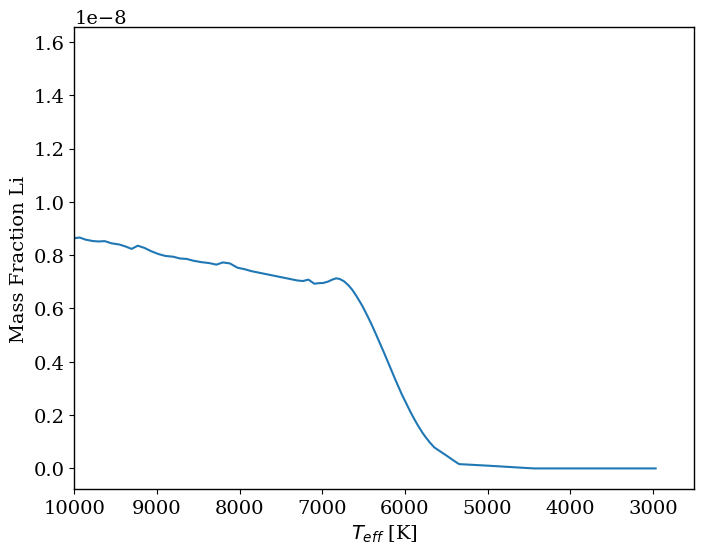

In [53]:
plt.rcParams.update({'font.size': 14})  # Set the font size


fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.set_ylabel('Mass Fraction Li')
ax.set_xlabel('$T_{eff}$ [K]')

ax.plot(10**MIST_FULL[0.1259]['log_Teff'], MIST_FULL[0.1259]['surface_li7'])

ax.set_xlim(2500, 10000)

ax.invert_xaxis()

In [54]:
max(10**MIST_FULL[0.1259]['log_Teff'])

339646.6795258933

In [55]:
min(10**MIST_FULL[0.1259]['log_Teff'])

2967.2765754069314

In [56]:
minTeff_array = []

for key in MIST_FULL.keys():
    minTeff = min(10**MIST_FULL[key]['log_Teff'])
    minTeff_array.append(minTeff)
    
min(minTeff_array)

2885.5722587919586

### SPOTS

In [57]:
plt.rcParams.update({'font.size': 11, 'axes.linewidth': 1, 'axes.edgecolor': 'k'})
plt.rcParams['font.family'] = 'serif'

In [58]:
file_path = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/018-Data/biosc_data/SPOTS_iso/f000.isoc'

data_lines = []

with open(file_path, 'r') as file:
    for line in file:
        if not line.startswith('##') and line.strip():
            data = line.strip().split()
            data = [float(value) if value != '-99.0000' else None for value in data]
            data_lines.append(data)

SPOTS_f000 = pd.DataFrame(data_lines, columns=['log10_Age(yr)', 'Mass', 'Fspot', 'Xspot', 'log(L/Lsun)', 'log(R/Rsun)', 'log(g)', 'log(Teff)', 'log(T_hot)', 'log(T_cool)', 'TauCZ', 'Li/Li0', 'B_mag', 'V_mag', 'Rc_mag', 'Ic_mag', 'J_mag', 'H_mag', 'K_mag', 'W1_mag', 'G_mag', 'BP_mag', 'RP_mag'])

SPOTS_f000['Age [Gyr]'] = (10**(SPOTS_f000['log10_Age(yr)']))/(1e9)
SPOTS_f000

,log10_Age(yr),Mass,Fspot,Xspot,log(L/Lsun),log(R/Rsun),log(g),log(Teff),log(T_hot),log(T_cool),...,Rc_mag,Ic_mag,J_mag,H_mag,K_mag,W1_mag,G_mag,BP_mag,RP_mag,Age [Gyr]
0,6.0,0.10,0.0,0.8,-1.264294,-0.062834,3.563422,3.476971,3.476971,0.0,...,9.9243,7.9855,6.0990,5.5140,5.1912,NaN,NaN,NaN,NaN,0.001000
1,6.0,0.15,0.0,0.8,-1.016889,0.028539,3.556766,3.493135,3.493135,0.0,...,8.9105,7.1942,5.5108,4.9443,4.6464,NaN,8.2694,9.9514,6.8990,0.001000
2,6.0,0.20,0.0,0.8,-0.848551,0.084768,3.569247,3.507105,3.507105,0.0,...,8.1571,6.5901,5.0345,4.4736,4.1947,4.0242,7.5512,9.1535,6.3059,0.001000
3,6.0,0.25,0.0,0.8,-0.706698,0.129191,3.577312,3.520357,3.520357,0.0,...,7.5537,6.1067,4.6605,4.0931,3.8291,3.6985,6.9707,8.4631,5.8108,0.001000
4,6.0,0.30,0.0,0.8,-0.569443,0.172660,3.569533,3.532936,3.532936,0.0,...,7.0317,5.6894,4.3336,3.7546,3.5025,3.3810,6.5194,7.9022,5.4176,0.001000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,9.6,1.10,0.0,0.8,0.229798,0.073119,4.332886,3.782517,3.782517,0.0,...,3.9162,3.6071,3.1867,2.9486,2.8854,2.8584,4.1099,4.3861,3.6582,3.981072
1821,9.6,1.15,0.0,0.8,0.349532,0.117734,4.262962,3.790144,3.790144,0.0,...,3.6266,3.3293,2.9258,2.7026,2.6416,2.6145,3.8136,4.0753,3.3762,3.981072
1822,9.6,1.20,0.0,0.8,0.470700,0.168494,4.179925,3.795055,3.795055,0.0,...,3.3292,3.0399,2.6475,2.4340,2.3744,2.3472,3.5076,3.7605,3.0812,3.981072
1823,9.6,1.25,0.0,0.8,0.610740,0.234178,4.066284,3.797223,3.797223,0.0,...,2.9815,2.6960,2.3087,2.0997,2.0407,2.0134,3.1542,3.4031,2.7331,3.981072


In [59]:
directory = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/018-Data/biosc_data/SPOTS_iso/'


# Dictionary to store dataframes for each file
SPOTS = {}

# Loop through each .isoc file
for filename in os.listdir(directory):
    if filename.endswith(".isoc"):
        file_path = os.path.join(directory, filename)
        # Extract the key from the filename (e.g., "f000")
        key = filename.split(".")[0]
        # Create a dictionary to store dataframes for each age
        age_dataframes = {}
        # Read the data from the file and create dataframes for each age
        with open(file_path, 'r') as file:
            data_lines = []
            for line in file:
                # Skip comment lines and blank lines
                if not line.startswith("##") and line.strip():
                    data = line.strip().split()
                    # If it's a data line
                    if len(data) > 1:
                        data = [float(value) if value != '-99.0000' else None for value in data]
                        data_lines.append(data)
            # Create a single dataframe for all ages
            df = pd.DataFrame(data_lines, columns=["log10_Age(yr)", "Mass", "Fspot", "Xspot", "log(L/Lsun)", "log(R/Rsun)", "log(g)", "log(Teff)", "log(T_hot)", "log(T_cool)", "TauCZ", "Li/Li0", "B_mag", "V_mag", "Rc_mag", "Ic_mag", "J_mag", "H_mag", "K_mag", "W1_mag", "G_mag", "BP_mag", "RP_mag"])
            # Calculate the age in Gyr and round to the third decimal
            df['Age [Gyr]'] = round((10**(df['log10_Age(yr)'])) / (1e9), 3)
            df['A(Li)'] = np.log10(df['Li/Li0']) + 3.3
            df['M/Ms'] = df['Mass']
            df['Teff'] = 10**df['log(Teff)']
            df['Lsun'] = 10**df['log(L/Lsun)']
            df['G'] = df['G_mag']
            df['BP'] = df['BP_mag']
            df['RP'] = df['RP_mag']
            # Drop the original 'log10_Age(yr)' column
            df.drop(columns=['log10_Age(yr)'], inplace=True)
            # Group dataframe rows by 'Age [Gyr]' column
            grouped = df.groupby('Age [Gyr]')
            # Store each group (age) as a dataframe in the dictionary
            for age, group in grouped:
                age_dataframes[age] = group.reset_index(drop=True)
        # Store the dictionary of dataframes for each file
        SPOTS[key] = age_dataframes

# Print the dictionary of dictionaries
#print(SPOTS)

/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/biosc_env/lib64/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/biosc_env/lib64/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/biosc_env/lib64/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/biosc_env/lib64/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWa

In [60]:
SPOTS.keys()

dict_keys(['f017', 'f085', 'f051', 'f034', 'f068', 'f000'])

In [61]:
SPOTS['f000'].keys()

dict_keys([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.013, 0.014, 0.016, 0.018, 0.02, 0.022, 0.025, 0.028, 0.032, 0.035, 0.04, 0.045, 0.05, 0.056, 0.063, 0.071, 0.079, 0.089, 0.1, 0.112, 0.126, 0.141, 0.158, 0.178, 0.2, 0.224, 0.251, 0.282, 0.316, 0.355, 0.398, 0.447, 0.501, 0.562, 0.631, 0.708, 0.794, 0.891, 1.0, 1.122, 1.259, 1.413, 1.585, 1.778, 1.995, 2.239, 2.512, 2.818, 3.162, 3.548, 3.981])

In [62]:
SPOTS['f000'][0.126].columns

Index(['Mass', 'Fspot', 'Xspot', 'log(L/Lsun)', 'log(R/Rsun)', 'log(g)',
       'log(Teff)', 'log(T_hot)', 'log(T_cool)', 'TauCZ', 'Li/Li0', 'B_mag',
       'V_mag', 'Rc_mag', 'Ic_mag', 'J_mag', 'H_mag', 'K_mag', 'W1_mag',
       'G_mag', 'BP_mag', 'RP_mag', 'Age [Gyr]', 'A(Li)', 'M/Ms', 'Teff',
       'Lsun', 'G', 'BP', 'RP'],
      dtype='object')

In [63]:
SPOTS['f085'][0.035]['BP_mag']-SPOTS['f085'][0.035]['RP_mag']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
6        NaN
7        NaN
8        NaN
9        NaN
10    2.5453
11    2.4617
12    2.3605
13    2.1510
14    1.8895
15    1.6275
16    1.3964
17    1.2118
18    1.0748
19    0.9690
20    0.9308
21    0.8991
22    0.8394
23    0.7704
24    0.6691
dtype: float64

In [64]:
SPOTS['f085'][0.035]['Li/Li0']

0     0.99994
1     0.99501
2     0.91175
3     0.44079
4     0.01100
5     0.00002
6     0.00020
7     0.00404
8     0.03503
9     0.13395
10    0.29661
11    0.46932
12    0.61882
13    0.72710
14    0.79927
15    0.84324
16    0.87046
17    0.89569
18    0.91984
19    0.94082
20    0.95712
21    0.96947
22    0.97850
23    0.98504
24    0.98964
Name: Li/Li0, dtype: float64

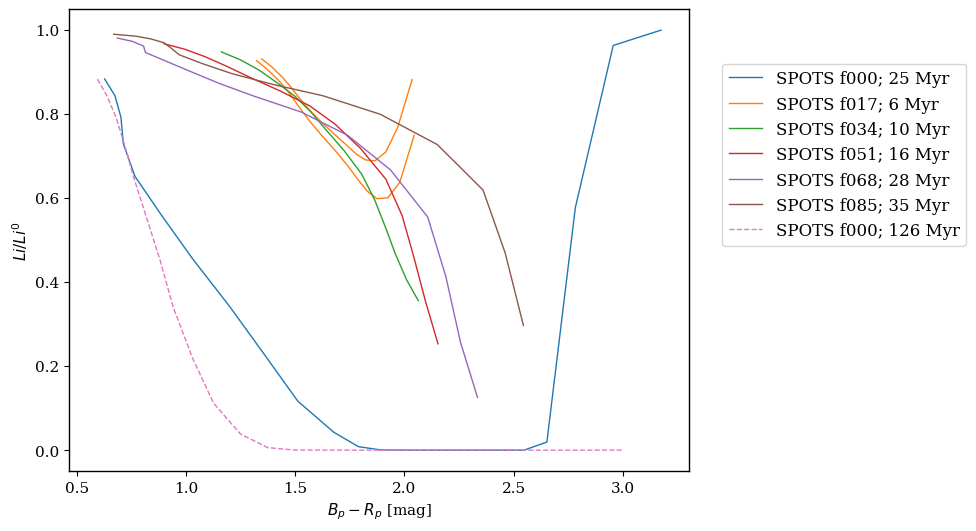

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.set_ylabel('$Li/Li^0$')
ax.set_xlabel('$B_p-R_p$ [mag]')
ax.plot(SPOTS['f000'][0.025]['BP_mag']-SPOTS['f000'][0.025]['RP_mag'], SPOTS['f000'][0.025]['Li/Li0'], linewidth=1, label='SPOTS f000; 25 Myr')
ax.plot(SPOTS['f017'][0.006]['BP_mag']-SPOTS['f017'][0.006]['RP_mag'], SPOTS['f017'][0.006]['Li/Li0'], linewidth=1, label='SPOTS f017; 6 Myr')
ax.plot(SPOTS['f034'][0.010]['BP_mag']-SPOTS['f034'][0.010]['RP_mag'], SPOTS['f034'][0.010]['Li/Li0'], linewidth=1, label='SPOTS f034; 10 Myr')
ax.plot(SPOTS['f051'][0.016]['BP_mag']-SPOTS['f051'][0.016]['RP_mag'], SPOTS['f051'][0.016]['Li/Li0'], linewidth=1, label='SPOTS f051; 16 Myr')
ax.plot(SPOTS['f068'][0.028]['BP_mag']-SPOTS['f068'][0.028]['RP_mag'], SPOTS['f068'][0.028]['Li/Li0'], linewidth=1, label='SPOTS f068; 28 Myr')
ax.plot(SPOTS['f085'][0.035]['BP_mag']-SPOTS['f085'][0.035]['RP_mag'], SPOTS['f085'][0.035]['Li/Li0'], linewidth=1, label='SPOTS f085; 35 Myr')
ax.plot(SPOTS['f000'][0.126]['BP_mag']-SPOTS['f000'][0.126]['RP_mag'], SPOTS['f000'][0.126]['Li/Li0'], linewidth=1, linestyle='--', label='SPOTS f000; 126 Myr')



#ax.errorbar(data_obs_Pleiades['Teff'], data_obs_Pleiades['ALi'], yerr=data_obs_Pleiades['e_ALi'], fmt='.', zorder=0, color='r', elinewidth=1, capsize=2)
ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(1.25, 0.9))

/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/biosc_env/lib64/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


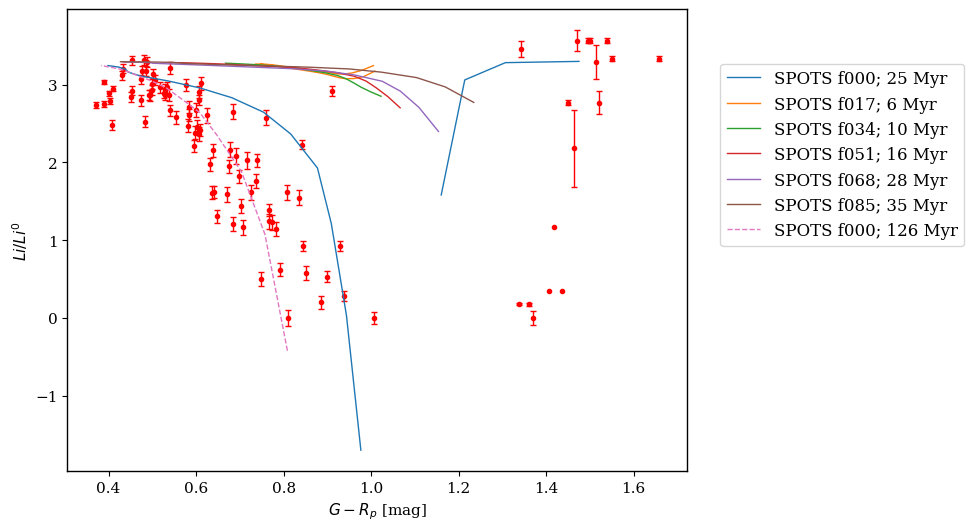

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.set_ylabel('$Li/Li^0$')
ax.set_xlabel('$G-R_p$ [mag]')
ax.plot(SPOTS['f000'][0.025]['G_mag']-SPOTS['f000'][0.025]['RP_mag'], np.log10(SPOTS['f000'][0.025]['Li/Li0'])+3.3, linewidth=1, label='SPOTS f000; 25 Myr')
ax.plot(SPOTS['f017'][0.006]['G_mag']-SPOTS['f017'][0.006]['RP_mag'], np.log10(SPOTS['f017'][0.006]['Li/Li0'])+3.3, linewidth=1, label='SPOTS f017; 6 Myr')
ax.plot(SPOTS['f034'][0.010]['G_mag']-SPOTS['f034'][0.010]['RP_mag'], np.log10(SPOTS['f034'][0.010]['Li/Li0'])+3.3, linewidth=1, label='SPOTS f034; 10 Myr')
ax.plot(SPOTS['f051'][0.016]['G_mag']-SPOTS['f051'][0.016]['RP_mag'], np.log10(SPOTS['f051'][0.016]['Li/Li0'])+3.3, linewidth=1, label='SPOTS f051; 16 Myr')
ax.plot(SPOTS['f068'][0.028]['G_mag']-SPOTS['f068'][0.028]['RP_mag'], np.log10(SPOTS['f068'][0.028]['Li/Li0'])+3.3, linewidth=1, label='SPOTS f068; 28 Myr')
ax.plot(SPOTS['f085'][0.035]['G_mag']-SPOTS['f085'][0.035]['RP_mag'], np.log10(SPOTS['f085'][0.035]['Li/Li0'])+3.3, linewidth=1, label='SPOTS f085; 35 Myr')
ax.plot(SPOTS['f000'][0.126]['G_mag']-SPOTS['f000'][0.126]['RP_mag'], np.log10(SPOTS['f000'][0.126]['Li/Li0'])+3.3, linewidth=1, linestyle='--', label='SPOTS f000; 126 Myr')



ax.errorbar(data_obs_Pleiades['G_abs']-data_obs_Pleiades['RP_abs'], data_obs_Pleiades['ALi'], yerr=data_obs_Pleiades['e_ALi'], fmt='.', zorder=0, color='r', elinewidth=1, capsize=2)
ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(1.25, 0.9))

In [67]:
data_obs_Pleiades.columns

Index(['source_id', 'Mecayotl', 'Olivares+2018', 'Meingast+2021', 'l', 'b',
       'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error',
       'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'pmra_pmdec_corr',
       'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr',
       'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
       'parallax_pmra_corr', 'parallax_pmdec_corr', 'g', 'bp', 'rp', 'e_g',
       'e_bp', 'e_rp', 'dr3_radial_velocity', 'dr3_radial_velocity_error',
       'ruwe', 'astrometric_excess_noise', 'astrometric_params_solved',
       'bp_rp', 'g_rp', 'Jmag', 'Hmag', 'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag',
       'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag',
       'ymag', 'e_ymag', 'Name', 'EPIC', 'RAJ2000', 'DEJ2000', 'Vmag', 'J-K',
       'Per', 'Amp', 'l_WLi', 'WLi', 'e_WLi', 'Teff', 'ALi', 'e_ALi', 'Bin',
       'SimbadName', 'Teff_x', 'logg', '[Fe/H]', 'A0', 'AG', 'ABP', 'ARP',
       'E(BP-RP)', 'Rad', 'Li

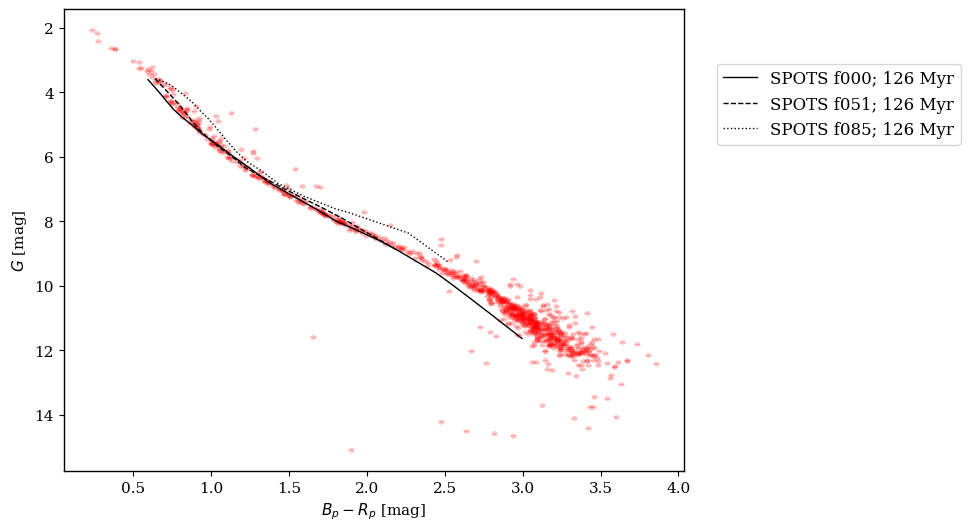

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.set_ylabel('$G$ [mag]')
ax.set_xlabel('$B_p-R_p$ [mag]')

ax.plot(SPOTS['f000'][0.126]['BP_mag']-SPOTS['f000'][0.126]['RP_mag'], SPOTS['f000'][0.126]['G_mag'], linewidth=1, label='SPOTS f000; 126 Myr', color='k')

ax.plot(SPOTS['f051'][0.126]['BP_mag']-SPOTS['f051'][0.126]['RP_mag'], SPOTS['f051'][0.126]['G_mag'], linewidth=1, linestyle='--', label='SPOTS f051; 126 Myr', color='k')

ax.plot(SPOTS['f085'][0.126]['BP_mag']-SPOTS['f085'][0.126]['RP_mag'], SPOTS['f085'][0.126]['G_mag'], linewidth=1, linestyle=':', label='SPOTS f085; 126 Myr', color='k')


ax.errorbar(data_obs_Pleiades['BP_abs']-data_obs_Pleiades['RP_abs'], data_obs_Pleiades['G_abs'], yerr=data_obs_Pleiades['e_g'], fmt='.', zorder=0, color='r', elinewidth=1, capsize=2, alpha=0.125)
ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(1.25, 0.9))
ax.invert_yaxis()

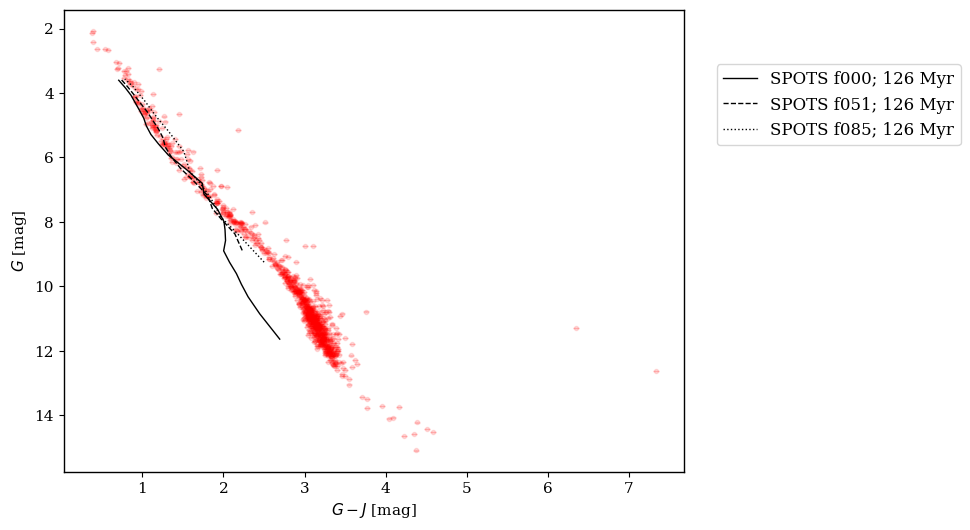

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.set_ylabel('$G$ [mag]')
ax.set_xlabel('$G-J$ [mag]')

ax.plot(SPOTS['f000'][0.126]['G_mag']-SPOTS['f000'][0.126]['J_mag'], SPOTS['f000'][0.126]['G_mag'], linewidth=1, label='SPOTS f000; 126 Myr', color='k')

ax.plot(SPOTS['f051'][0.126]['G_mag']-SPOTS['f051'][0.126]['J_mag'], SPOTS['f051'][0.126]['G_mag'], linewidth=1, linestyle='--', label='SPOTS f051; 126 Myr', color='k')

ax.plot(SPOTS['f085'][0.126]['G_mag']-SPOTS['f085'][0.126]['J_mag'], SPOTS['f085'][0.126]['G_mag'], linewidth=1, linestyle=':', label='SPOTS f085; 126 Myr', color='k')


ax.errorbar(data_obs_Pleiades['G_abs']-data_obs_Pleiades['J_abs'], data_obs_Pleiades['G_abs'], yerr=data_obs_Pleiades['e_g'], fmt='.', zorder=0, color='r', elinewidth=1, capsize=2, alpha=0.125)
ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(1.25, 0.9))
ax.invert_yaxis()

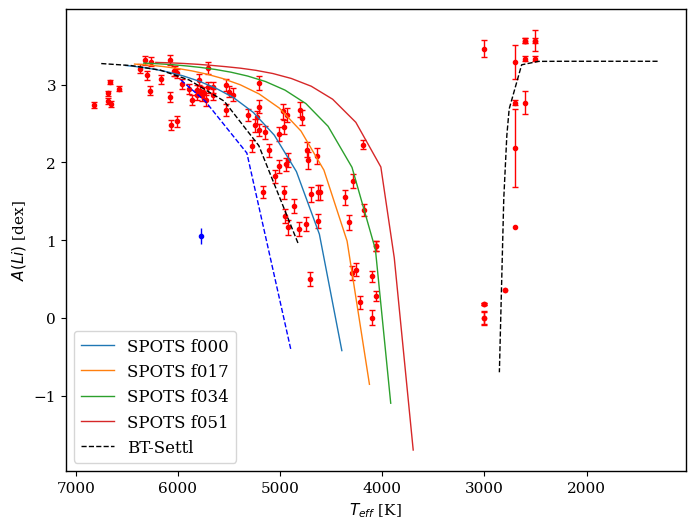

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.set_ylabel('$A(Li)$ [dex]')
ax.set_xlabel('$T_{eff}$ [K]')
ax.plot(10**SPOTS['f000'][0.126]['log(Teff)'], SPOTS['f000'][0.126]['A(Li)'], linewidth=1, label='SPOTS f000')
ax.plot(10**SPOTS['f017'][0.126]['log(Teff)'], SPOTS['f017'][0.126]['A(Li)'], linewidth=1, label='SPOTS f017')
ax.plot(10**SPOTS['f034'][0.126]['log(Teff)'], SPOTS['f034'][0.126]['A(Li)'], linewidth=1, label='SPOTS f034')
ax.plot(10**SPOTS['f051'][0.126]['log(Teff)'], SPOTS['f051'][0.126]['A(Li)'], linewidth=1, label='SPOTS f051')

ax.errorbar(Tsun, solar_abundance, xerr=0.5, yerr=e_solar_abundance, fmt='.', zorder=2, color='b', elinewidth=1, capsize=0)

ax.plot(BTSettl_Li_isochrones[5]['Teff'], BTSettl_Li_isochrones[5]['A(Li)'], linewidth=1, linestyle='--', color='b')

ax.plot(BTSettl_Li_isochrones[0.120]['Teff'], BTSettl_Li_isochrones[0.120]['A(Li)'], linewidth=1, label='BT-Settl', linestyle='--', color='k')
ax.errorbar(data_obs_Pleiades['Teff'], data_obs_Pleiades['ALi'], yerr=data_obs_Pleiades['e_ALi'], fmt='.', zorder=0, color='r', elinewidth=1, capsize=2)
ax.legend(fontsize=12)
ax.invert_xaxis()

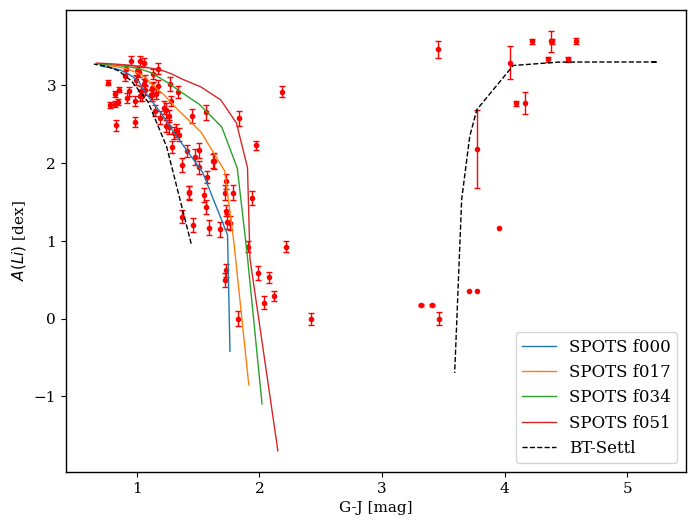

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.set_ylabel('$A(Li)$ [dex]')
ax.set_xlabel('G-J [mag]')
ax.plot(SPOTS['f000'][0.126]['G_mag']-SPOTS['f000'][0.126]['J_mag'], SPOTS['f000'][0.126]['A(Li)'], linewidth=1, label='SPOTS f000')
ax.plot(SPOTS['f017'][0.126]['G_mag']-SPOTS['f000'][0.126]['J_mag'], SPOTS['f017'][0.126]['A(Li)'], linewidth=1, label='SPOTS f017')
ax.plot(SPOTS['f034'][0.126]['G_mag']-SPOTS['f000'][0.126]['J_mag'], SPOTS['f034'][0.126]['A(Li)'], linewidth=1, label='SPOTS f034')
ax.plot(SPOTS['f051'][0.126]['G_mag']-SPOTS['f000'][0.126]['J_mag'], SPOTS['f051'][0.126]['A(Li)'], linewidth=1, label='SPOTS f051')



ax.plot(BTSettl_Li_isochrones[0.120]['G']-BTSettl_Li_isochrones[0.120]['J'], BTSettl_Li_isochrones[0.120]['A(Li)'], linewidth=1, label='BT-Settl', linestyle='--', color='k')
ax.errorbar(data_obs_Pleiades['g']-data_obs_Pleiades['Jmag'], data_obs_Pleiades['ALi'], yerr=data_obs_Pleiades['e_ALi'], fmt='.', zorder=0, color='r', elinewidth=1, capsize=2)
ax.legend(fontsize=12)

In [72]:
data_obs_Pleiades[(~data_obs_Pleiades['ALi'].isnull()) & (data_obs_Pleiades['ALi'] != 0)]['ALi'].count()

99

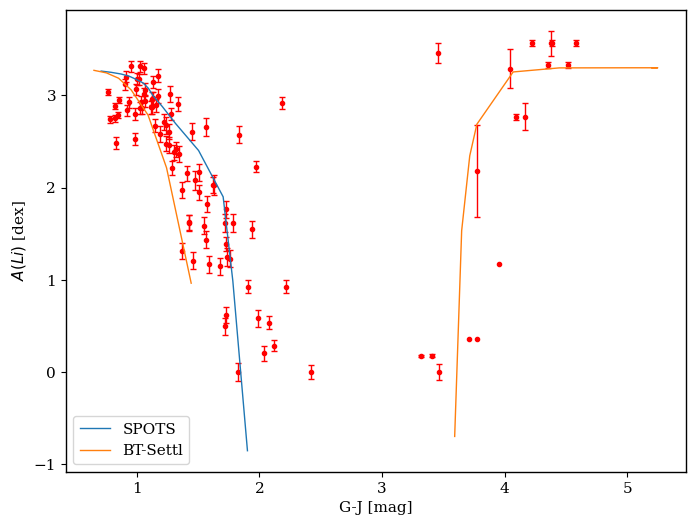

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.set_ylabel('$A(Li)$ [dex]')
ax.set_xlabel('G-J [mag]')
ax.plot(SPOTS['f017'][0.126]['G_mag']-SPOTS['f017'][0.126]['J_mag'], SPOTS['f017'][0.126]['A(Li)'], linewidth=1, label='SPOTS')
ax.plot(BTSettl_Li_isochrones[0.120]['G']-BTSettl_Li_isochrones[0.120]['J'], BTSettl_Li_isochrones[0.120]['A(Li)'], linewidth=1, label='BT-Settl')
ax.errorbar(data_obs_Pleiades['g']-data_obs_Pleiades['Jmag'], data_obs_Pleiades['ALi'], yerr=data_obs_Pleiades['e_ALi'], fmt='.', zorder=0, color='r', elinewidth=1, capsize=2)
ax.legend()


In [74]:
max(10**SPOTS['f000'][0.126]['log(Teff)'])

6512.426277507005

In [75]:
min(10**SPOTS['f000'][0.126]['log(Teff)'])

2949.742462182295

### Corrected photometry SPOTS models

In [76]:
plt.rcParams.update({'font.size': 11, 'axes.linewidth': 1, 'axes.edgecolor': 'k'})
plt.rcParams['font.family'] = 'serif'

In [77]:
def ave_flux(mcool, mhot, Thot, Tcool, fspot):

    '''

    inputs: appropriate columns from isoc file (e.g., G_cool, G_hot)

    output: averaged mag array

    '''

    fs = fspot

    fp = fs / (fs + (1-fs)*(Tcool/Thot)**4)

    M_ave = -2.5*np.log10((1-fp)*10**(-mhot/2.5) + fp*10**(-mcool/2.5))

    return M_ave

In [78]:
path = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/f000_ybc_2m_edr3.txt'

spots_f000_edr3 = pd.read_csv(path, sep='\s+')

spots_f000_edr3

,logAge,Mass,Fspot,Xspot,log(L/Lsun),log(R/Rsun),log(g),log(Teff),log(T_hot),log(T_cool),...,H_cool,Ks_cool,Label_2,G_hot,G_BP_hot,G_RP_hot,Label_3,G_cool,G_BP_cool,G_RP_cool
0,6.0,0.10,0.0,0.8,-1.264294,-0.062834,3.563422,3.476971,3.476971,0.0,...,5.28468,4.91444,0.0,9.28208,11.07635,8.00717,0.0,9.99054,12.51737,8.54831
1,6.0,0.15,0.0,0.8,-1.016889,0.028539,3.556766,3.493135,3.493135,0.0,...,4.66641,4.29585,0.0,8.53948,10.19738,7.30378,0.0,9.37227,11.89796,7.93015
2,6.0,0.20,0.0,0.8,-0.848551,0.084768,3.569247,3.507105,3.507105,0.0,...,4.24510,3.87516,0.0,8.02914,9.59170,6.82302,0.0,8.95097,11.47881,7.50864
3,6.0,0.25,0.0,0.8,-0.706698,0.129191,3.577312,3.520357,3.520357,0.0,...,3.89017,3.52062,0.0,7.58880,9.05605,6.41405,0.0,8.59605,11.12527,7.15357
4,6.0,0.30,0.0,0.8,-0.569443,0.172660,3.569533,3.532936,3.532936,0.0,...,3.54732,3.17739,0.0,7.16304,8.53253,6.02315,0.0,8.25319,10.78108,6.81085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,9.6,1.10,0.0,0.8,0.229798,0.073119,4.332886,3.782517,3.782517,0.0,...,1.51303,1.18390,0.0,4.05687,4.34589,3.60866,0.0,6.26004,8.97425,4.79662
1821,9.6,1.15,0.0,0.8,0.349532,0.117734,4.262962,3.790144,3.790144,0.0,...,1.21795,0.88469,0.0,3.75461,4.02860,3.32369,0.0,5.95636,8.64700,4.49584
1822,9.6,1.20,0.0,0.8,0.470700,0.168494,4.179925,3.795055,3.795055,0.0,...,0.92007,0.58193,0.0,3.45032,3.71454,3.03102,0.0,5.64829,8.31093,4.19121
1823,9.6,1.25,0.0,0.8,0.610740,0.234178,4.066284,3.797223,3.797223,0.0,...,0.57688,0.23204,0.0,3.09942,3.35885,2.68583,0.0,5.29113,7.91546,3.83876


In [79]:
spots_f000_edr3.columns

Index(['logAge', 'Mass', 'Fspot', 'Xspot', 'log(L/Lsun)', 'log(R/Rsun)',
       'log(g)', 'log(Teff)', 'log(T_hot)', 'log(T_cool)', 'TauCZ', 'Li/Li0',
       'B_mag', 'V_mag', 'Rc_mag', 'Ic_mag', 'J_mag', 'H_mag', 'K_mag',
       'W1_mag', 'G_mag', 'BP_mag', 'RP_mag', 'Thot', 'Tcool', 'Label_0',
       'J_hot', 'H_hot', 'Ks_hot', 'Label_1', 'J_cool', 'H_cool', 'Ks_cool',
       'Label_2', 'G_hot', 'G_BP_hot', 'G_RP_hot', 'Label_3', 'G_cool',
       'G_BP_cool', 'G_RP_cool'],
      dtype='object')

In [80]:
f_array = ['00', '17', '34', '51', '68', '85']
SPOTS_edr3 = {}
fspots = [0.00, 0.17, 0.34, 0.51, 0.68, 0.85]

for f, f_i in zip(f_array, fspots):
    SPOTS_edr3[f] = {}
    path = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/f0' + f + '_ybc_2m_edr3.txt'
    dataframe = pd.read_csv(path, sep='\s+')
    
    dataframe['Age_Gyr'] = 10**dataframe['logAge']/1e9
    
    dataframe['BP_abs'] = ave_flux(dataframe['G_BP_cool'], dataframe['G_BP_hot'], 10**dataframe['log(T_hot)'], 10**dataframe['log(T_cool)'], f_i)
    dataframe['RP_abs'] = ave_flux(dataframe['G_RP_cool'], dataframe['G_RP_hot'], 10**dataframe['log(T_hot)'], 10**dataframe['log(T_cool)'], f_i)
    dataframe['G_abs'] = ave_flux(dataframe['G_cool'], dataframe['G_hot'], 10**dataframe['log(T_hot)'], 10**dataframe['log(T_cool)'], f_i)
    dataframe['J_abs'] = ave_flux(dataframe['J_cool'], dataframe['J_hot'], 10**dataframe['log(T_hot)'], 10**dataframe['log(T_cool)'], f_i)
    dataframe['H_abs'] = ave_flux(dataframe['H_cool'], dataframe['H_hot'], 10**dataframe['log(T_hot)'], 10**dataframe['log(T_cool)'], f_i)
    dataframe['K_abs'] = ave_flux(dataframe['Ks_cool'], dataframe['Ks_hot'], 10**dataframe['log(T_hot)'], 10**dataframe['log(T_cool)'], f_i)
    
    dataframe['M/Ms'] = dataframe['Mass']
    dataframe['BP-RP'] = dataframe['BP_abs'] - dataframe['RP_abs']
    dataframe['G-J'] = dataframe['G_abs'] - dataframe['J_abs']
    dataframe['G-RP'] = dataframe['G_abs'] - dataframe['RP_abs']
    
    dataframe['A(Li)'] = np.log10(dataframe['Li/Li0']) + 3.3
    
    dataframe['Lsun'] = 10**dataframe['log(L/Lsun)']
    
    dataframe['Teff'] = 10**dataframe['log(Teff)']
    
    for age_gyr, df_group in dataframe.groupby('Age_Gyr'):
        SPOTS_edr3[f][round(age_gyr,3)] = df_group
    

/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/biosc_env/lib64/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/biosc_env/lib64/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/biosc_env/lib64/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/biosc_env/lib64/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWa

In [81]:
SPOTS_edr3['00'].keys()

dict_keys([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.013, 0.014, 0.016, 0.018, 0.02, 0.022, 0.025, 0.028, 0.032, 0.035, 0.04, 0.045, 0.05, 0.056, 0.063, 0.071, 0.079, 0.089, 0.1, 0.112, 0.126, 0.141, 0.158, 0.178, 0.2, 0.224, 0.251, 0.282, 0.316, 0.355, 0.398, 0.447, 0.501, 0.562, 0.631, 0.708, 0.794, 0.891, 1.0, 1.122, 1.259, 1.413, 1.585, 1.778, 1.995, 2.239, 2.512, 2.818, 3.162, 3.548, 3.981])

In [82]:
SPOTS_edr3['00'][0.126].columns

Index(['logAge', 'Mass', 'Fspot', 'Xspot', 'log(L/Lsun)', 'log(R/Rsun)',
       'log(g)', 'log(Teff)', 'log(T_hot)', 'log(T_cool)', 'TauCZ', 'Li/Li0',
       'B_mag', 'V_mag', 'Rc_mag', 'Ic_mag', 'J_mag', 'H_mag', 'K_mag',
       'W1_mag', 'G_mag', 'BP_mag', 'RP_mag', 'Thot', 'Tcool', 'Label_0',
       'J_hot', 'H_hot', 'Ks_hot', 'Label_1', 'J_cool', 'H_cool', 'Ks_cool',
       'Label_2', 'G_hot', 'G_BP_hot', 'G_RP_hot', 'Label_3', 'G_cool',
       'G_BP_cool', 'G_RP_cool', 'Age_Gyr', 'BP_abs', 'RP_abs', 'G_abs',
       'J_abs', 'H_abs', 'K_abs', 'M/Ms', 'BP-RP', 'G-J', 'G-RP', 'A(Li)',
       'Lsun', 'Teff'],
      dtype='object')

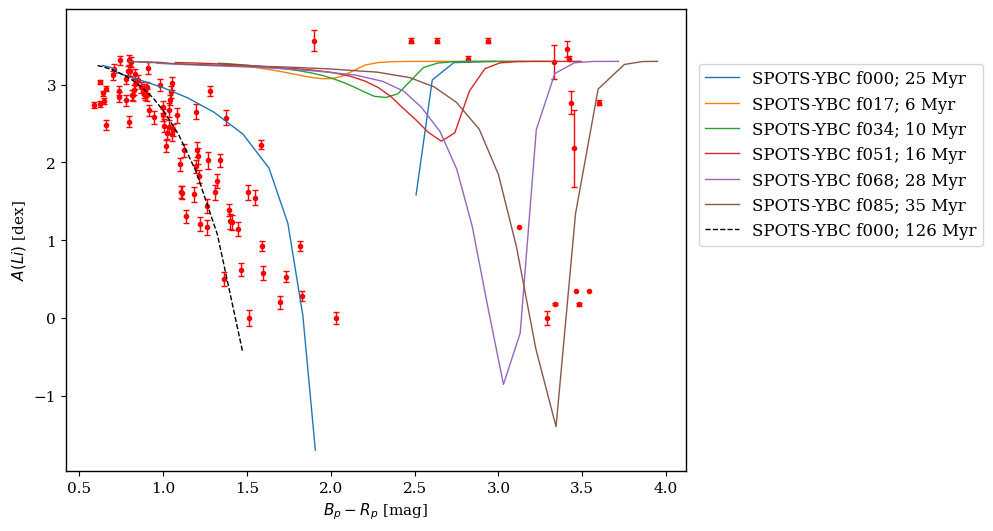

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.set_ylabel('$A(Li)$ [dex]')
ax.set_xlabel('$B_p-R_p$ [mag]')
ax.plot(SPOTS_edr3['00'][0.025]['BP-RP'], SPOTS_edr3['00'][0.025]['A(Li)'], linewidth=1, label='SPOTS-YBC f000; 25 Myr')
ax.plot(SPOTS_edr3['17'][0.006]['BP-RP'], SPOTS_edr3['17'][0.006]['A(Li)'], linewidth=1, label='SPOTS-YBC f017; 6 Myr')
ax.plot(SPOTS_edr3['34'][0.010]['BP-RP'], SPOTS_edr3['34'][0.010]['A(Li)'], linewidth=1, label='SPOTS-YBC f034; 10 Myr')
ax.plot(SPOTS_edr3['51'][0.016]['BP-RP'], SPOTS_edr3['51'][0.016]['A(Li)'], linewidth=1, label='SPOTS-YBC f051; 16 Myr')
ax.plot(SPOTS_edr3['68'][0.028]['BP-RP'], SPOTS_edr3['68'][0.028]['A(Li)'], linewidth=1, label='SPOTS-YBC f068; 28 Myr')
ax.plot(SPOTS_edr3['85'][0.035]['BP-RP'], SPOTS_edr3['85'][0.035]['A(Li)'], linewidth=1, label='SPOTS-YBC f085; 35 Myr')
ax.plot(SPOTS_edr3['00'][0.126]['BP-RP'], SPOTS_edr3['00'][0.126]['A(Li)'], linewidth=1, color = 'k', linestyle='--', label='SPOTS-YBC f000; 126 Myr')



ax.errorbar(data_obs_Pleiades['bp']-data_obs_Pleiades['rp'], data_obs_Pleiades['ALi'], yerr=data_obs_Pleiades['e_ALi'], fmt='.', zorder=0, color='r', elinewidth=1, capsize=2)
ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(1.25, 0.9))

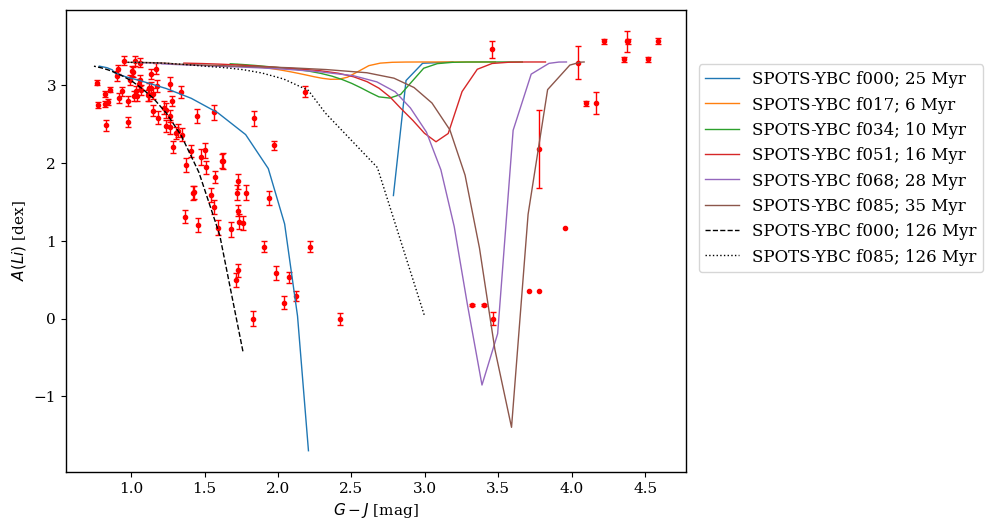

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.set_ylabel('$A(Li)$ [dex]')
ax.set_xlabel('$G-J$ [mag]')
ax.plot(SPOTS_edr3['00'][0.025]['G-J'], SPOTS_edr3['00'][0.025]['A(Li)'], linewidth=1, label='SPOTS-YBC f000; 25 Myr')
ax.plot(SPOTS_edr3['17'][0.006]['G-J'], SPOTS_edr3['17'][0.006]['A(Li)'], linewidth=1, label='SPOTS-YBC f017; 6 Myr')
ax.plot(SPOTS_edr3['34'][0.010]['G-J'], SPOTS_edr3['34'][0.010]['A(Li)'], linewidth=1, label='SPOTS-YBC f034; 10 Myr')
ax.plot(SPOTS_edr3['51'][0.016]['G-J'], SPOTS_edr3['51'][0.016]['A(Li)'], linewidth=1, label='SPOTS-YBC f051; 16 Myr')
ax.plot(SPOTS_edr3['68'][0.028]['G-J'], SPOTS_edr3['68'][0.028]['A(Li)'], linewidth=1, label='SPOTS-YBC f068; 28 Myr')
ax.plot(SPOTS_edr3['85'][0.035]['G-J'], SPOTS_edr3['85'][0.035]['A(Li)'], linewidth=1, label='SPOTS-YBC f085; 35 Myr')
ax.plot(SPOTS_edr3['00'][0.126]['G-J'], SPOTS_edr3['00'][0.126]['A(Li)'], linewidth=1, color = 'k', linestyle='--', label='SPOTS-YBC f000; 126 Myr')
ax.plot(SPOTS_edr3['85'][0.126]['G-J'], SPOTS_edr3['85'][0.126]['A(Li)'], linewidth=1, color = 'k', linestyle=':', label='SPOTS-YBC f085; 126 Myr')



ax.errorbar(data_obs_Pleiades['g']-data_obs_Pleiades['Jmag'], data_obs_Pleiades['ALi'], yerr=data_obs_Pleiades['e_ALi'], fmt='.', zorder=0, color='r', elinewidth=1, capsize=2)
ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(1.25, 0.9))

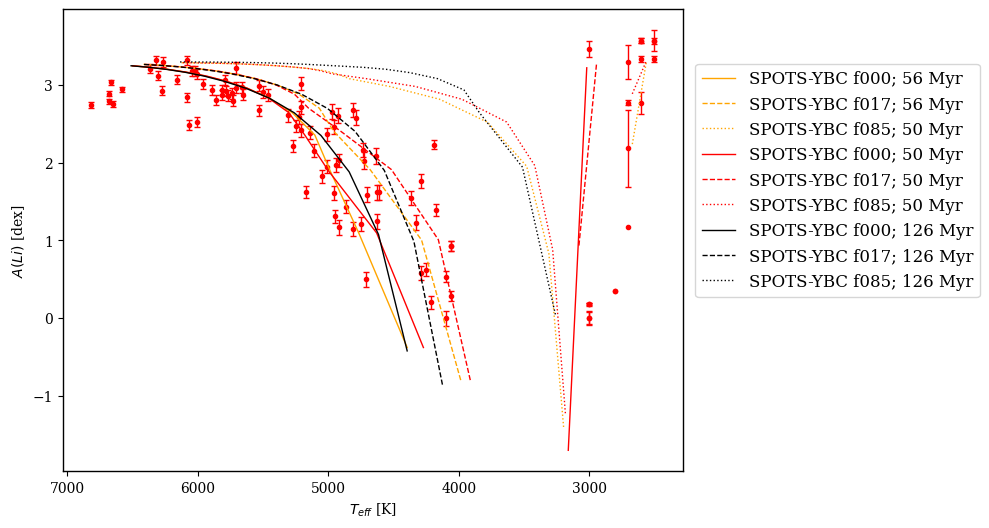

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.set_ylabel('$A(Li)$ [dex]')
ax.set_xlabel('$T_{eff}$ [K]')
ax.plot(SPOTS_edr3['00'][0.056]['Teff'], SPOTS_edr3['00'][0.056]['A(Li)'], linewidth=1, color='orange',  label='SPOTS-YBC f000; 56 Myr')
ax.plot(SPOTS_edr3['17'][0.056]['Teff'], SPOTS_edr3['17'][0.056]['A(Li)'], linewidth=1, linestyle='--', color='orange', label='SPOTS-YBC f017; 56 Myr')
ax.plot(SPOTS_edr3['85'][0.056]['Teff'], SPOTS_edr3['51'][0.056]['A(Li)'], linewidth=1, linestyle=':', color='orange', label='SPOTS-YBC f085; 50 Myr')
ax.plot(SPOTS_edr3['00'][0.05]['Teff'], SPOTS_edr3['00'][0.05]['A(Li)'], linewidth=1, color='r', label='SPOTS-YBC f000; 50 Myr')
ax.plot(SPOTS_edr3['17'][0.05]['Teff'], SPOTS_edr3['17'][0.05]['A(Li)'], linewidth=1, linestyle='--', color='r', label='SPOTS-YBC f017; 50 Myr')
ax.plot(SPOTS_edr3['85'][0.05]['Teff'], SPOTS_edr3['51'][0.05]['A(Li)'], linewidth=1, linestyle=':', color='r', label='SPOTS-YBC f085; 50 Myr')
ax.plot(SPOTS_edr3['00'][0.126]['Teff'], SPOTS_edr3['00'][0.126]['A(Li)'], linewidth=1, color = 'k', label='SPOTS-YBC f000; 126 Myr')
ax.plot(SPOTS_edr3['17'][0.126]['Teff'], SPOTS_edr3['17'][0.126]['A(Li)'], linewidth=1, color = 'k', linestyle='--', label='SPOTS-YBC f017; 126 Myr')
ax.plot(SPOTS_edr3['85'][0.126]['Teff'], SPOTS_edr3['85'][0.126]['A(Li)'], linewidth=1, color = 'k', linestyle=':', label='SPOTS-YBC f085; 126 Myr')



ax.invert_xaxis()

ax.errorbar(data_obs_Pleiades['Teff'], data_obs_Pleiades['ALi'], yerr=data_obs_Pleiades['e_ALi'], fmt='.', zorder=0, color='r', elinewidth=1, capsize=2)
ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(1.25, 0.9))

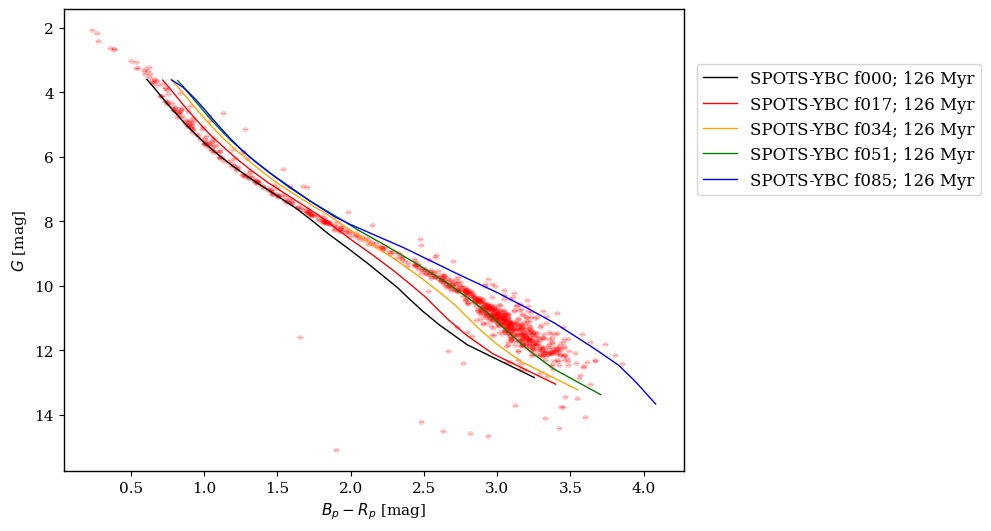

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.set_ylabel('$G$ [mag]')
ax.set_xlabel('$B_p-R_p$ [mag]')

ax.plot(SPOTS_edr3['00'][0.126]['BP_abs']-SPOTS_edr3['00'][0.126]['RP_abs'], SPOTS_edr3['00'][0.126]['G_abs'], linewidth=1, label='SPOTS-YBC f000; 126 Myr', color='k')

ax.plot(SPOTS_edr3['17'][0.126]['BP_abs']-SPOTS_edr3['17'][0.126]['RP_abs'], SPOTS_edr3['17'][0.126]['G_abs'], linewidth=1, label='SPOTS-YBC f017; 126 Myr', color='r')

ax.plot(SPOTS_edr3['34'][0.126]['BP_abs']-SPOTS_edr3['34'][0.126]['RP_abs'], SPOTS_edr3['34'][0.126]['G_abs'], linewidth=1, label='SPOTS-YBC f034; 126 Myr', color='orange')

ax.plot(SPOTS_edr3['51'][0.126]['BP_abs']-SPOTS_edr3['51'][0.126]['RP_abs'], SPOTS_edr3['51'][0.126]['G_abs'], linewidth=1, label='SPOTS-YBC f051; 126 Myr', color='green')

ax.plot(SPOTS_edr3['85'][0.126]['BP_abs']-SPOTS_edr3['85'][0.126]['RP_abs'], SPOTS_edr3['85'][0.126]['G_abs'], linewidth=1, label='SPOTS-YBC f085; 126 Myr', color='blue')


ax.errorbar(data_obs_Pleiades['BP_abs']-data_obs_Pleiades['RP_abs'], data_obs_Pleiades['G_abs'], yerr=data_obs_Pleiades['e_g'], fmt='.', zorder=0, color='r', elinewidth=1, capsize=2, alpha=0.125)
ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(1.25, 0.9))
ax.invert_yaxis()

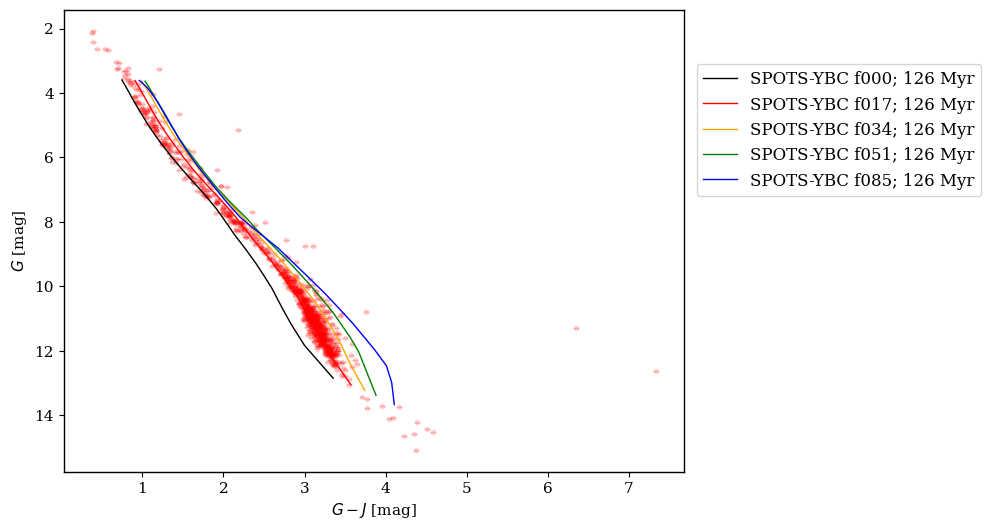

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.set_ylabel('$G$ [mag]')
ax.set_xlabel('$G-J$ [mag]')

ax.plot(SPOTS_edr3['00'][0.126]['G_abs']-SPOTS_edr3['00'][0.126]['J_abs'], SPOTS_edr3['00'][0.126]['G_abs'], linewidth=1, label='SPOTS-YBC f000; 126 Myr', color='k')

ax.plot(SPOTS_edr3['17'][0.126]['G_abs']-SPOTS_edr3['17'][0.126]['J_abs'], SPOTS_edr3['17'][0.126]['G_abs'], linewidth=1, label='SPOTS-YBC f017; 126 Myr', color='r')

ax.plot(SPOTS_edr3['34'][0.126]['G_abs']-SPOTS_edr3['34'][0.126]['J_abs'], SPOTS_edr3['34'][0.126]['G_abs'], linewidth=1, label='SPOTS-YBC f034; 126 Myr', color='orange')

ax.plot(SPOTS_edr3['51'][0.126]['G_abs']-SPOTS_edr3['51'][0.126]['J_abs'], SPOTS_edr3['51'][0.126]['G_abs'], linewidth=1, label='SPOTS-YBC f051; 126 Myr', color='green')

ax.plot(SPOTS_edr3['85'][0.126]['G_abs']-SPOTS_edr3['85'][0.126]['J_abs'], SPOTS_edr3['85'][0.126]['G_abs'], linewidth=1, label='SPOTS-YBC f085; 126 Myr', color='blue')


ax.errorbar(data_obs_Pleiades['G_abs']-data_obs_Pleiades['J_abs'], data_obs_Pleiades['G_abs'], yerr=data_obs_Pleiades['e_g'], fmt='.', zorder=0, color='r', elinewidth=1, capsize=2, alpha=0.125)
ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(1.25, 0.9))
ax.invert_yaxis()

(0.0, 1.5)

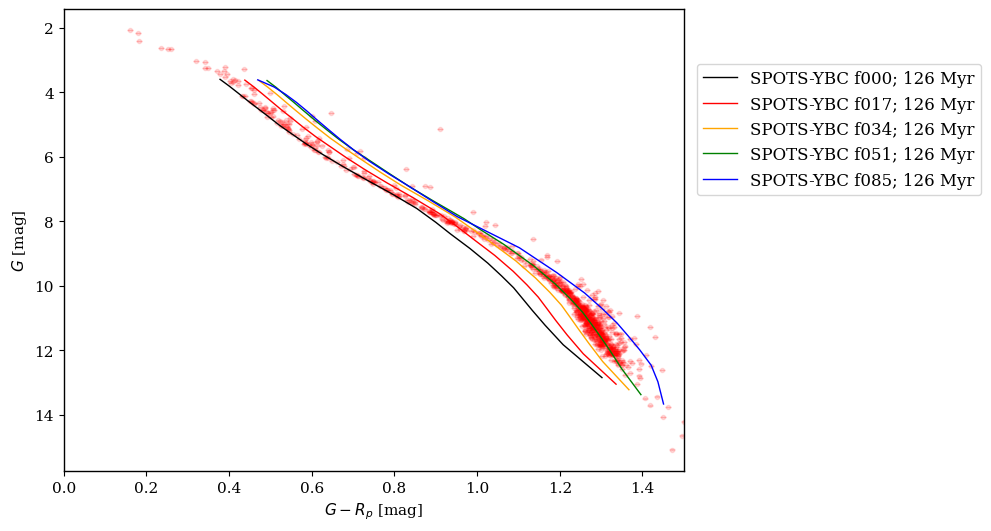

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.set_ylabel('$G$ [mag]')
ax.set_xlabel('$G-R_p$ [mag]')

ax.plot(SPOTS_edr3['00'][0.126]['G_abs']-SPOTS_edr3['00'][0.126]['RP_abs'], SPOTS_edr3['00'][0.126]['G_abs'], linewidth=1, label='SPOTS-YBC f000; 126 Myr', color='k')

ax.plot(SPOTS_edr3['17'][0.126]['G_abs']-SPOTS_edr3['17'][0.126]['RP_abs'], SPOTS_edr3['17'][0.126]['G_abs'], linewidth=1, label='SPOTS-YBC f017; 126 Myr', color='r')

ax.plot(SPOTS_edr3['34'][0.126]['G_abs']-SPOTS_edr3['34'][0.126]['RP_abs'], SPOTS_edr3['34'][0.126]['G_abs'], linewidth=1, label='SPOTS-YBC f034; 126 Myr', color='orange')

ax.plot(SPOTS_edr3['51'][0.126]['G_abs']-SPOTS_edr3['51'][0.126]['RP_abs'], SPOTS_edr3['51'][0.126]['G_abs'], linewidth=1, label='SPOTS-YBC f051; 126 Myr', color='green')

ax.plot(SPOTS_edr3['85'][0.126]['G_abs']-SPOTS_edr3['85'][0.126]['RP_abs'], SPOTS_edr3['85'][0.126]['G_abs'], linewidth=1, label='SPOTS-YBC f085; 126 Myr', color='blue')


ax.errorbar(data_obs_Pleiades['G_abs']-data_obs_Pleiades['RP_abs'], data_obs_Pleiades['G_abs'], yerr=data_obs_Pleiades['e_g'], fmt='.', zorder=0, color='r', elinewidth=1, capsize=2, alpha=0.125)
ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(1.25, 0.9))
ax.invert_yaxis()

ax.set_xlim(0, 1.5)

In [88]:
import numpy as np
from scipy.spatial.distance import cdist
import time

# Function to calculate the perpendicular distance from a point to a line segment
def perpendicular_distance(point, line_start, line_end):
    line_vec = line_end - line_start
    point_vec = point - line_start
    projection = np.dot(point_vec, line_vec) / np.maximum(np.dot(line_vec, line_vec), 1e-10)  # Projection of point onto the line
    if projection < 0:
        return np.linalg.norm(point - line_start)  # Closest point is the start of the line segment
    elif projection > 1:
        return np.linalg.norm(point - line_end)  # Closest point is the end of the line segment
    else:
        closest_point = line_start + projection * line_vec
        return np.linalg.norm(point - closest_point)  # Closest point is on the line segment

def find_closest_point_to_line(data_point1, data_point2, models, threshold_factor=0.5):
    closest_distance = float('inf')
    closest_point = None
    closest_model_index = None
    for i, model in enumerate(models):
        distances = [perpendicular_distance(model_point, data_point1, data_point2) for model_point in model]
        min_distance = np.min(distances)
        if min_distance < closest_distance:
            closest_distance = min_distance
            closest_point = model[np.argmin(distances)]
            closest_model_index = i
    threshold_distance = threshold_factor * perpendicular_distance(data_point1, data_point2, data_point2)
    if closest_distance > threshold_distance:
        return None, None
    return closest_point, closest_model_index

import pymc as pm
import logging
from pymc import HalfCauchy, Model, Normal, sample, Mixture, Beta, HalfNormal

def run_bayesian_inference(coord_data, coord, bar=False):
    # Define priors
    data = coord_data

    mean = data.mean()
    std = data.std()
    
    with pm.Model() as model:
        # Priors
        sigma = pm.HalfNormal('sigma_'+coord, sigma=std)
        coord_mean = pm.Normal('coord_mean_'+coord, mu=mean, sigma=sigma)
        
        # Likelihood
        likelihood = pm.Normal('likelihood_'+coord, mu=coord_mean, sigma=sigma, observed=coord_data)
        
        # Sample from the posterior
        trace = pm.sample(1000, tune=1000, target_accept=0.99, progressbar=bar)
    
    # Return posterior distribution samples
    return trace, std

def run_bayesian_inference_out(coord_data, coord, bar=False):
    # Define priors
    data = coord_data

    mean = data.mean()
    std = data.std()

    distance = np.abs(data - mean) / std

    outlier_index = distance.idxmax()

    outlier_value = data[outlier_index]

    data_filtered = data[distance <= 1]

    std_out = data_filtered.std()

    with pm.Model() as model:
        # Priors
        coord_mean = pm.Normal('coord_mean_'+coord, mu=mean, sigma=std_out)

        # Priors for outliers
        P_b = pm.Beta('P_b_'+coord, alpha=2, beta=5)
        Y_b = pm.Normal('Y_b_'+coord, mu=outlier_value, sigma=std)  # Mean and standard deviation of outlier distribution

        # Main and outlier distributions
        like = pm.Normal.dist(mu=coord_mean, sigma=std_out)
        outlier = pm.Normal.dist(mu=Y_b, sigma=np.sqrt(std**2 + std_out**2))

        # Likelihood
        y_likelihood = pm.Mixture('likelihood_'+coord, w=[1 - P_b, P_b], comp_dists=[like, outlier], observed=data)

        # Sample from the posterior
        trace = pm.sample(1000, tune=1000, target_accept=0.99, progressbar=bar)
        
        return trace, std_out


In [187]:
BTSettl_Li_isochrones_Teff = BTSettl_Li_isochrones[0.120][BTSettl_Li_isochrones[0.120]['Teff'] < 2955]
BTSettl_Li_isochrones_Teff = BTSettl_Li_isochrones_Teff[BTSettl_Li_isochrones_Teff ['Teff'] > 1600]
BTSettl_Li_isochrones_Teff

,age_Gyr,t(Gyr),M/Ms,Teff,log(L/Lsun),lg(g),R(Gcm),D,Li,G_abs,...,J_abs,H,K,g_p1,r,i,y,z,A(Li),Lsun
489,0.12,0.12,0.030,1779.0,-3.88,4.75,8.44,0.0,1.0000,18.128999,...,12.882,11.710,10.977,22.719,19.781,17.869,16.276,15.153,3.300000,0.000132
490,0.12,0.12,0.040,2225.0,-3.46,4.84,8.79,0.0,1.0000,16.322999,...,11.268,10.580,10.210,21.486,18.909,16.300,14.352,13.157,3.300000,0.000347
491,0.12,0.12,0.050,2471.0,-3.23,4.88,9.31,0.0,0.9970,15.099000,...,10.655,10.068,9.746,19.253,17.727,14.750,13.173,12.261,3.298695,0.000589
492,0.12,0.12,0.060,2635.0,-3.06,4.91,9.89,0.0,0.9010,14.358000,...,10.289,9.710,9.397,17.811,16.792,13.812,12.518,11.764,3.254725,0.000871
493,0.12,0.12,0.070,2757.0,-2.94,4.93,10.47,0.0,0.2440,13.784000,...,10.011,9.431,9.125,16.576,15.826,13.134,12.043,11.410,2.687390,0.001148
494,0.12,0.12,0.072,2780.0,-2.91,4.93,10.59,0.0,0.1110,13.674000,...,9.959,9.379,9.073,16.387,15.630,13.008,11.952,11.340,2.345323,0.001230
495,0.12,0.12,0.075,2810.0,-2.88,4.93,10.78,0.0,0.0171,13.533000,...,9.884,9.304,9.001,16.173,15.393,12.851,11.833,11.247,1.532996,0.001318
496,0.12,0.12,0.080,2853.0,-2.83,4.94,11.08,0.0,0.0001,13.363000,...,9.771,9.192,8.896,15.990,15.143,12.668,11.679,11.119,-0.700000,0.001479
497,0.12,0.12,0.090,2924.0,-2.74,4.94,11.69,0.0,0.0000,13.058000,...,9.569,8.992,8.707,15.614,14.704,12.346,11.408,10.891,-inf,0.001820


In [197]:
BTSettl_Li_isochrones_Teff['BP_abs']

489    21.426799
490    20.287799
491    18.737800
492    17.572799
493    16.469801
494    16.274801
495    16.046800
496    15.823800
497    15.407800
Name: BP_abs, dtype: float64

In [198]:
BTSettl_Li_isochrones_Teff['RP_abs']

489    16.5728
490    14.6978
491    13.5278
492    12.8408
493    12.3238
494    12.2248
495    12.0968
496    11.9348
497    11.6488
Name: RP_abs, dtype: float64

In [199]:
BTSettl_Li_isochrones_Teff['BP_abs']-BTSettl_Li_isochrones_Teff['RP_abs']

489    4.853999
490    5.589999
491    5.210000
492    4.732000
493    4.146000
494    4.050000
495    3.950000
496    3.889000
497    3.759000
dtype: float64

In [193]:
def find_closest_age(age_array, age):
    closest_age = min(age_array, key=lambda x: abs(x - age))
    return closest_age

def get_color_gradient(num_steps, step):
    blue_value = int(255 * (step / (num_steps - 1)))
    return (0, 0, blue_value / 255)


def plot_process_CMD(SPOTS, data_obs, band_1, band_2, band_y, age_iso, max_mag):
    
    age_array = SPOTS['00'].keys()
    
    age = find_closest_age(age_array, age_iso)

    start_time = time.time()
    
    interval_x = np.linspace(np.min(SPOTS['00'][age][band_1]-SPOTS['00'][age][band_2]), max_mag, len(SPOTS['85'][age][band_y])-1)
    interval_y = np.linspace(np.min(SPOTS['00'][age][band_y]), np.max(data_obs[band_y]), len(SPOTS['85'][age][band_y])-1)


    interval_size_x = np.mean(np.diff(interval_x))
    interval_size_y = np.mean(np.diff(interval_y))
    length_x = len(interval_x)

    data_obs_x = {}
    data_obs_y = {}

    # Iterate over the intervals defined by interval_x
    for i in range(len(interval_x) - 1):
        # Select data within the current interval
        mask = (data_obs[band_1]-data_obs[band_2] >= interval_x[i]) & (data_obs[band_1]-data_obs[band_2] < interval_x[i+1])
        selected_data_x = data_obs[band_1][mask]-data_obs[band_2][mask]
        selected_data_y = data_obs[band_y][mask]

        # Add the selected data to data_obs_x with the corresponding index as key
        data_obs_x[i] = selected_data_x
        data_obs_y[i] = selected_data_y
        

    # Run Bayesian inference for x coordinate intervals
    posterior_x = []
    std_array = []
    for i in range(len(interval_x) - 1):
        logging.disable(logging.CRITICAL)
        x_interval_data = data_obs_x[i]
        x_posterior, std = run_bayesian_inference(x_interval_data, 'x')
        std_array.append(std)
        posterior_x.append(x_posterior)
        logging.disable(logging.NOTSET)

    # Run Bayesian inference for y coordinate intervals
    posterior_y = []
    std_out_array = []
    for i in range(len(interval_x) - 1):
        logging.disable(logging.CRITICAL)
        y_interval_data = data_obs_y[i]
        y_posterior, std_out = run_bayesian_inference_out(y_interval_data, 'y')
        std_out_array.append(std_out)
        posterior_y.append(y_posterior)
        logging.disable(logging.NOTSET)

        
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    ax.set_ylabel(f'${band_y.split("_")[0]}$ [mag]')
    ax.set_xlabel(f'${band_1.split("_")[0]}-{band_2.split("_")[0]}$ [mag]')
    
    step = 0
    for f in ['00', '17', '34', '51', '68', '85']:
        num_steps = len(SPOTS)
        age_Myr = age*1000
        ax.plot(SPOTS_edr3[f][age][band_1] - SPOTS_edr3[f][age][band_2], SPOTS_edr3[f][age][band_y], label=f'SPOTS-YBC f0'+f+f'; {age_Myr} Myr', color=get_color_gradient(num_steps, step), linewidth=1, linestyle='--')
        step = step + 1

    ax.scatter(data_obs[band_1]-data_obs[band_2], data_obs[band_y], s=10, zorder=0, color='r', alpha=0.125)

    # Draw vertical grid lines
    for x in interval_x:
        ax.axvline(x, color='gray', linestyle='--', linewidth=0.5, zorder=0)

    x_median_array = []
    y_median_array = []
    e_x_median_array = []
    e_y_median_array = []

    for i in range(len(posterior_x)):
        x_median = np.median(posterior_x[i].posterior['coord_mean_x'].values)
        y_median = np.median(posterior_y[i].posterior['coord_mean_y'].values)
        e_x_median = np.mean(std_array[i])
        e_y_median = np.mean(std_out_array[i])
        x_median_array.append(x_median)
        y_median_array.append(y_median)
        e_x_median_array.append(e_x_median)
        e_y_median_array.append(e_y_median)

    ax.plot(x_median_array, y_median_array, linewidth=1, linestyle='-', color='k', label='Interpolated Line (Bayesian)', zorder=5)

    ax.fill_between(np.sort(x_median_array), np.sort(np.array(y_median_array) + np.array(e_y_median_array)), np.sort(np.array(y_median_array) - np.array(e_y_median_array)), color='yellow', alpha=0.35, zorder=4, label=r'$\sigma_G$')
    ax.fill_between(np.sort(x_median_array), np.sort(np.array(y_median_array) + 3*np.array(e_y_median_array)), np.sort(np.array(y_median_array) - 3*np.array(e_y_median_array)), color='orange', alpha=0.25, zorder=3, label=r'$3\sigma_G$')

    ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(1.25, 0.9))

    ax.invert_yaxis()
    
    end_time = time.time()

    execution_time = end_time - start_time

    minutes = int(execution_time // 60)
    seconds = execution_time % 60
    
    print(f'Exe. time: {minutes} minutos y {seconds:.2f} segundos.')
    return length_x, interval_x, x_median_array, y_median_array, e_x_median_array, e_y_median_array
    
def plot_result(interval_x, x_median_array, y_median_array, e_x_median_array, e_y_median_array, SPOTS, band_1, band_2, band_y, data_obs, age_iso, max_mag, l=2, BTSettl=False):
    
    age_array = SPOTS['00'].keys()
    
    age = find_closest_age(age_array, age_iso)
    
    start_time = time.time()
    
    # Define the models
    models = [np.column_stack((SPOTS['00'][age][band_1]-SPOTS['00'][age][band_2], SPOTS['00'][age][band_y])),
             np.column_stack((SPOTS['17'][age][band_1]-SPOTS['17'][age][band_2], SPOTS['17'][age][band_y])),
             np.column_stack((SPOTS['34'][age][band_1]-SPOTS['34'][age][band_2], SPOTS['34'][age][band_y])),
             np.column_stack((SPOTS['51'][age][band_1]-SPOTS['51'][age][band_2], SPOTS['51'][age][band_y])),
             np.column_stack((SPOTS['68'][age][band_1]-SPOTS['68'][age][band_2], SPOTS['68'][age][band_y])),
             np.column_stack((SPOTS['85'][age][band_1]-SPOTS['85'][age][band_2], SPOTS['85'][age][band_y]))]

    # Define the models_info
    models_info = [
        np.column_stack([SPOTS['00'][age][column] for column in SPOTS['00'][age].columns]),
        np.column_stack([SPOTS['17'][age][column] for column in SPOTS['17'][age].columns]),
        np.column_stack([SPOTS['34'][age][column] for column in SPOTS['34'][age].columns]),
        np.column_stack([SPOTS['51'][age][column] for column in SPOTS['51'][age].columns]),
        np.column_stack([SPOTS['68'][age][column] for column in SPOTS['68'][age].columns]),
        np.column_stack([SPOTS['85'][age][column] for column in SPOTS['85'][age].columns])
    ]

    # Define the data
    data = np.column_stack((x_median_array, y_median_array))

    # Matching process
    matched_points = []
    model_indexes = []
    data_indexes = []

    # Include the first data point
    closest_point = models[0][-1]  # Selecting the last point of the last model manually
    matched_points.append(closest_point)
    model_indexes.append(0)
    data_indexes.append(len(models[0]) - 1)

    # Include intermediate data points
    for i in range(1, len(data) - 2):
        data_point1 = data[i - 1]
        data_point2 = data[i + 1]
        closest_point, closest_model_index = find_closest_point_to_line(data_point1, data_point2, models)

        if np.array_equal(closest_point, matched_points[-1]):
            continue

        if closest_point[0] < matched_points[-1][0]:
            matched_points.insert(-1, closest_point)
            model_indexes.insert(-1, closest_model_index)

            closest_model = models[closest_model_index]
            closest_point_index = np.argmin([perpendicular_distance(model_point, data_point1, data_point2) for model_point in closest_model])
            data_index = closest_point_index
            data_indexes.insert(-1, data_index)
        else:
            matched_points.append(closest_point)
            model_indexes.append(closest_model_index)

            closest_model = models[closest_model_index]
            closest_point_index = np.argmin([perpendicular_distance(model_point, data_point1, data_point2) for model_point in closest_model])
            data_index = closest_point_index
            data_indexes.append(data_index)

    # Include last data points
    last_model_index = len(matched_points) - 1
    for i in range(l):
        closest_point = models[model_indexes[-1]][l-1-i] # Selecting the first point of the next model manually
        matched_points.append(closest_point)
        model_indexes.append(model_indexes[-1])
        data_indexes.append(l-1-i)

    # Convert the list of matched points into a final array
    final_iso_array = np.array(matched_points)

    # Create the final_iso_data list of lists
    final_iso_data = []
    for model_index, data_index in zip(model_indexes, data_indexes):
        # Add the row corresponding to the data index
        row_data = models_info[model_index][data_index].tolist()

        # Add the 'f' column
        row_data.append([0, 17, 34, 51, 68, 85][model_index])

        # Append the row to the final_iso_data
        final_iso_data.append(row_data)

    # Add the 'f' column name to the column names
    column_names = list(SPOTS['00'][age].columns) + ['f(%)']

    # Create the final_iso_df DataFrame
    final_iso_df = pd.DataFrame(final_iso_data, columns=column_names)

    # Create the dictionary SPOTS_edr3_iso and associate the final_iso_df DataFrame with the key '0.126'
    SPOTS_iso = {0.126: final_iso_df}

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    ax.set_ylabel(f'${band_y.split("_")[0]}$ [mag]')
    ax.set_xlabel(f'${band_1.split("_")[0]}-{band_2.split("_")[0]}$ [mag]')
                  
    step = 0
    for f in ['00', '17', '34', '51', '68', '85']:
        num_steps = len(SPOTS)
        age_Myr = age*1000
        ax.plot(SPOTS_edr3[f][age][band_1] - SPOTS_edr3[f][age][band_2], SPOTS_edr3[f][age][band_y], label=f'SPOTS-YBC f0'+f+f'; {age_Myr} Myr', color=get_color_gradient(num_steps, step), linewidth=1, linestyle='--')
        step = step + 1

    ax.scatter(data_obs[band_1]-data_obs[band_2], data_obs[band_y], s=10, zorder=0, color='r', alpha=0.125)

    # Draw vertical grid lines
    for x in interval_x:
        ax.axvline(x, color='gray', linestyle='--', linewidth=0.5, zorder=0)

    ax.plot(x_median_array, y_median_array, linewidth=1, linestyle=':', color='k', label='Interpolated Isochrone (Bayesian)', zorder=5)
    ax.plot(final_iso_array[:,0], final_iso_array[:,1], linewidth=1, linestyle='-', color='k', label='Mixture Isochrone', zorder=5)

    ax.fill_between(np.sort(x_median_array), np.sort(np.array(y_median_array) + np.array(e_y_median_array)), np.sort(np.array(y_median_array) - np.array(e_y_median_array)), color='yellow', alpha=0.35, zorder=4, label=r'$\sigma_G$')
    ax.fill_between(np.sort(x_median_array), np.sort(np.array(y_median_array) + 3*np.array(e_y_median_array)), np.sort(np.array(y_median_array) - 3*np.array(e_y_median_array)), color='orange', alpha=0.25, zorder=3, label=r'$3\sigma_G$')
    
    if BTSettl == True:
        ax.scatter(BTSettl_Li_isochrones_Teff[band_1] - BTSettl_Li_isochrones_Teff[band_2], BTSettl_Li_isochrones_Teff[band_y], s=10, label='Low-mass stars BT-Settl')
    else:
        pass
                  
    ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(1.35, 0.9))
                  
    ax.invert_yaxis()
    
    end_time = time.time()

    execution_time = end_time - start_time

    minutes = int(execution_time // 60)
    seconds = execution_time % 60

    print(f'Exe. time: {minutes} minutos y {seconds:.2f} segundos.')
        
    return SPOTS_iso

Exe. time: 6 minutos y 58.00 segundos.
Exe. time: 0 minutos y 0.07 segundos.


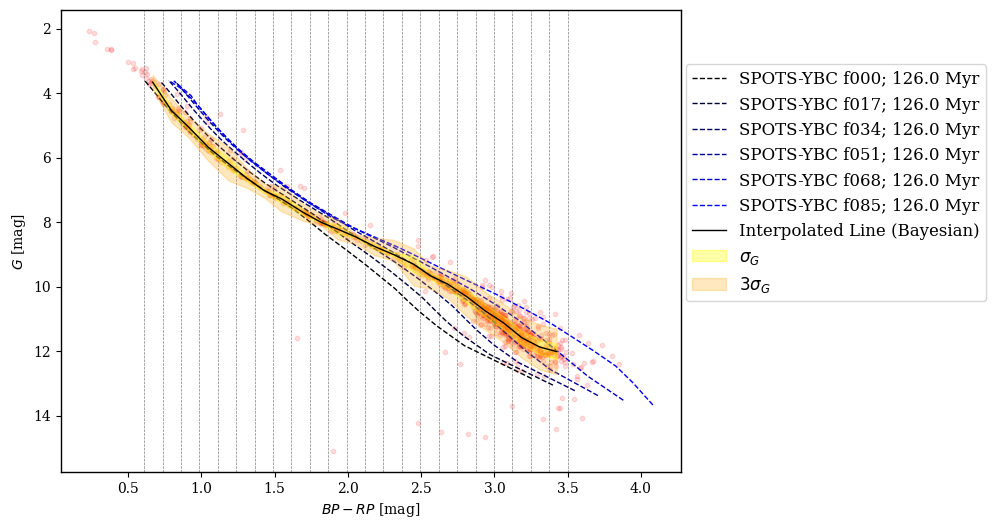

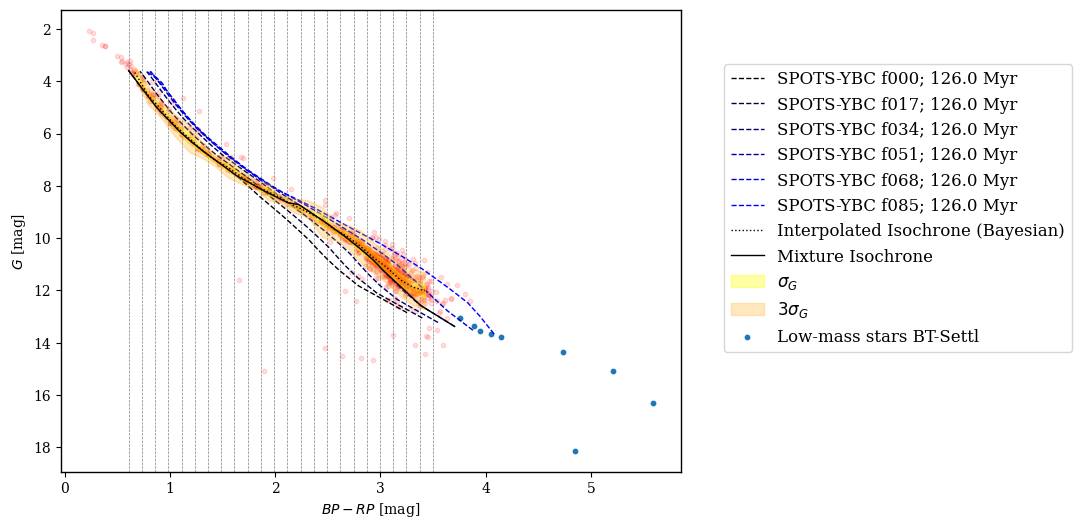

In [194]:
SPOTS = SPOTS_edr3
data_obs = data_obs_Pleiades
band_1 = 'BP_abs'
band_2 = 'RP_abs'
band_y = 'G_abs'
age_iso = 0.120
max_mag = 3.5

intervals, interval_x, x, y, e_x, e_y = plot_process_CMD(SPOTS, data_obs, band_1, band_2, band_y, age_iso, max_mag)
SPOTS_iso = plot_result(interval_x, x, y, e_x, e_y, SPOTS, band_1, band_2, band_y, data_obs, age_iso, max_mag, l=2, BTSettl=True)

Exe. time: 7 minutos y 9.74 segundos.
Exe. time: 0 minutos y 0.06 segundos.


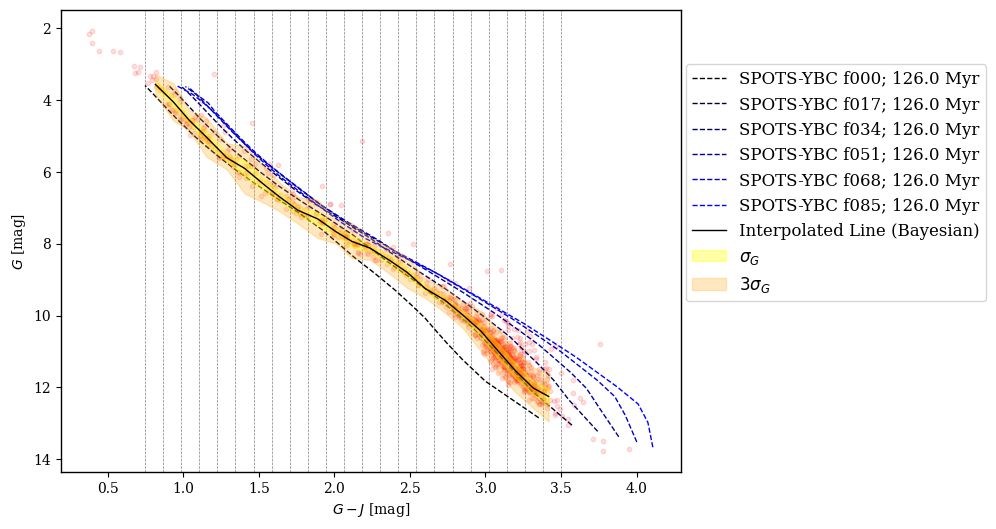

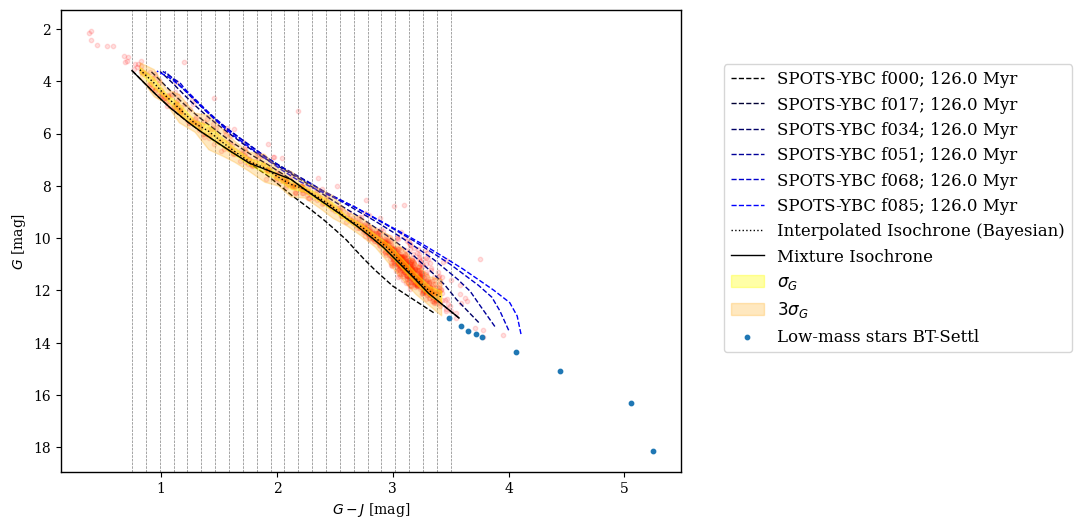

In [195]:
SPOTS = SPOTS_edr3
data_obs = data_obs_Pleiades.loc[data_obs_Pleiades['G_abs']-data_obs_Pleiades['J_abs'] < 4]
band_1 = 'G_abs'
band_2 = 'J_abs'
band_y = 'G_abs'
age_iso = 0.120
max_mag = 3.5

intervals_J, interval_x_J, x_J, y_J, e_x_J, e_y_J = plot_process_CMD(SPOTS, data_obs, band_1, band_2, band_y, age_iso, max_mag)
SPOTS_iso_J = plot_result(interval_x_J, x_J, y_J, e_x_J, e_y_J, SPOTS, band_1, band_2, band_y, data_obs, age_iso, max_mag, l=2, BTSettl=True)

Exe. time: 7 minutos y 49.84 segundos.
Exe. time: 0 minutos y 0.10 segundos.


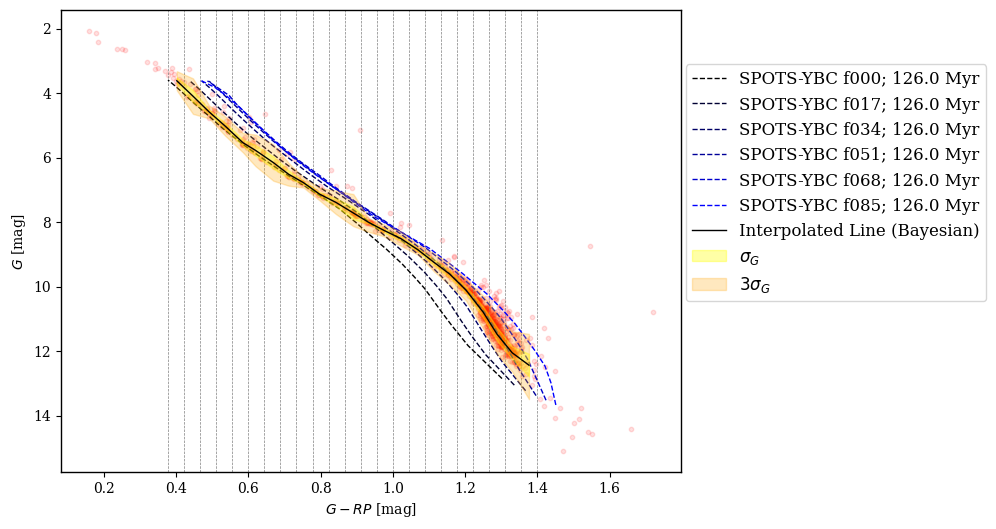

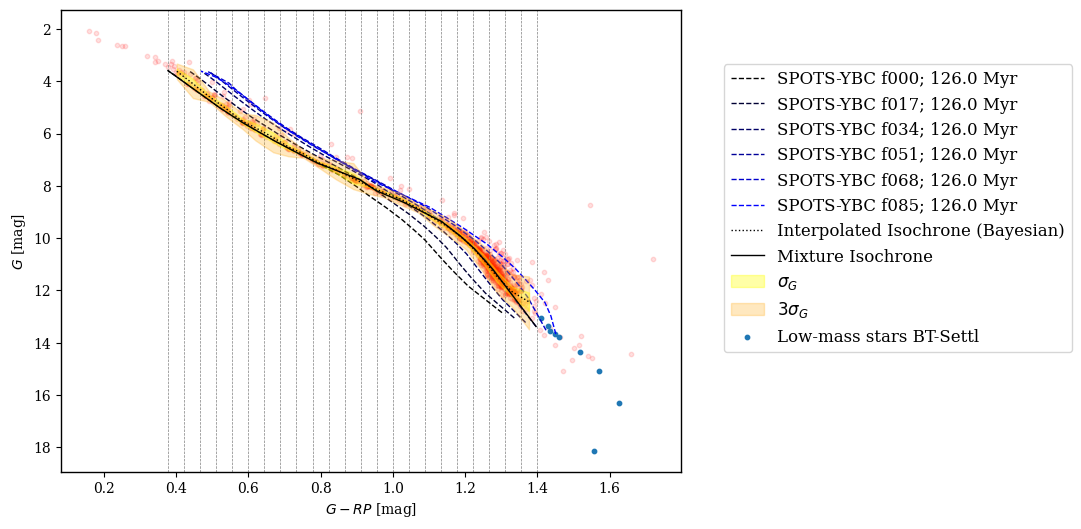

In [196]:
SPOTS = SPOTS_edr3
data_obs = data_obs_Pleiades.loc[data_obs_Pleiades['G_abs']-data_obs_Pleiades['RP_abs'] < 4]
band_1 = 'G_abs'
band_2 = 'RP_abs'
band_y = 'G_abs'
age_iso = 0.120
max_mag = 1.4


intervals_R, interval_x_R, x_R, y_R, e_x_R, e_y_R = plot_process_CMD(SPOTS, data_obs, band_1, band_2, band_y, age_iso, max_mag)
SPOTS_iso_R = plot_result(interval_x_R, x_R, y_R, e_x_R, e_y_R, SPOTS, band_1, band_2, band_y, data_obs, age_iso, max_mag, l=1, BTSettl=True)

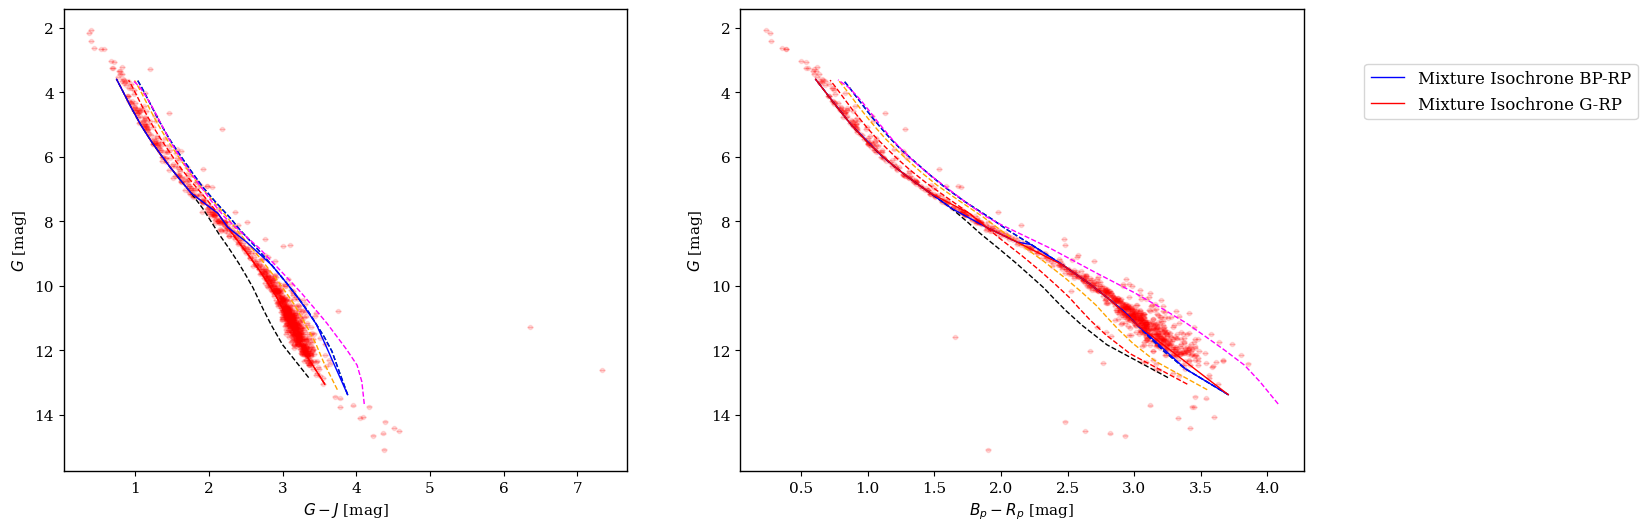

In [93]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_ylabel('$G$ [mag]')
ax1.set_xlabel('$G-J$ [mag]')

ax1.plot(SPOTS_edr3['00'][0.126]['G-J'], SPOTS_edr3['00'][0.126]['G_abs'], label='SPOTS-YBC f000; 126 Myr', color='k', linewidth=1, linestyle='--')

ax1.plot(SPOTS_edr3['17'][0.126]['G-J'], SPOTS_edr3['17'][0.126]['G_abs'], label='SPOTS-YBC f017; 126 Myr', color='r', linewidth=1, linestyle='--')

ax1.plot(SPOTS_edr3['34'][0.126]['G-J'], SPOTS_edr3['34'][0.126]['G_abs'], label='SPOTS-YBC f034; 126 Myr', color='orange', linewidth=1, linestyle='--')

ax1.plot(SPOTS_edr3['51'][0.126]['G-J'], SPOTS_edr3['51'][0.126]['G_abs'], label='SPOTS-YBC f051; 126 Myr', color='green', linewidth=1, linestyle='--')

ax1.plot(SPOTS_edr3['51'][0.126]['G-J'], SPOTS_edr3['51'][0.126]['G_abs'], label='SPOTS-YBC f051; 126 Myr', color='blue', linewidth=1, linestyle='--')

ax1.plot(SPOTS_edr3['85'][0.126]['G-J'], SPOTS_edr3['85'][0.126]['G_abs'], label='SPOTS-YBC f085; 126 Myr', color='magenta', linewidth=1, linestyle='--')


ax1.errorbar(data_obs_Pleiades['G_abs']-data_obs_Pleiades['J_abs'], data_obs_Pleiades['G_abs'], yerr=data_obs_Pleiades['e_g'], fmt='.', zorder=0, color='r', elinewidth=1, capsize=2, alpha=0.125)

ax1.plot(SPOTS_iso_J[0.126]['G_abs']-SPOTS_iso_J[0.126]['J_abs'], SPOTS_iso_J[0.126]['G_abs'], linewidth=1, linestyle='-', color='r', label='Mixture Isochrone G-J', zorder=5)
ax1.plot(SPOTS_iso_R[0.126]['G_abs']-SPOTS_iso_R[0.126]['J_abs'], SPOTS_iso_R[0.126]['G_abs'], linewidth=1, linestyle='-', color='b', label='Mixture Isochrone BP-RP', zorder=5)



ax1.invert_yaxis()

ax2.set_ylabel('$G$ [mag]')
ax2.set_xlabel('$B_p-R_p$ [mag]')

ax2.plot(SPOTS_edr3['00'][0.126]['BP-RP'], SPOTS_edr3['00'][0.126]['G_abs'], color='k', linewidth=1, linestyle='--')

ax2.plot(SPOTS_edr3['17'][0.126]['BP-RP'], SPOTS_edr3['17'][0.126]['G_abs'], color='r', linewidth=1, linestyle='--')

ax2.plot(SPOTS_edr3['34'][0.126]['BP-RP'], SPOTS_edr3['34'][0.126]['G_abs'], color='orange', linewidth=1, linestyle='--')

ax2.plot(SPOTS_edr3['51'][0.126]['BP-RP'], SPOTS_edr3['51'][0.126]['G_abs'], color='green', linewidth=1, linestyle='--')

ax2.plot(SPOTS_edr3['51'][0.126]['BP-RP'], SPOTS_edr3['51'][0.126]['G_abs'], color='blue', linewidth=1, linestyle='--')

ax2.plot(SPOTS_edr3['85'][0.126]['BP-RP'], SPOTS_edr3['85'][0.126]['G_abs'], color='magenta', linewidth=1, linestyle='--')


ax2.errorbar(data_obs_Pleiades['BP_abs']-data_obs_Pleiades['RP_abs'], data_obs_Pleiades['G_abs'], yerr=data_obs_Pleiades['e_g'], fmt='.', zorder=0, color='r', elinewidth=1, capsize=2, alpha=0.125)

ax2.plot(SPOTS_iso[0.126]['BP_abs']-SPOTS_iso[0.126]['RP_abs'], SPOTS_iso[0.126]['G_abs'], linewidth=1, linestyle='-', color='b', label='Mixture Isochrone BP-RP', zorder=5)
ax2.plot(SPOTS_iso_R[0.126]['BP_abs']-SPOTS_iso_R[0.126]['RP_abs'], SPOTS_iso_R[0.126]['G_abs'], linewidth=1, linestyle='-', color='r', label='Mixture Isochrone G-RP', zorder=5)


ax2.invert_yaxis()

ax2.legend(fontsize=12, loc='upper center', bbox_to_anchor=(1.35, 0.9))

In [94]:
for f in SPOTS_edr3.keys():
    Teff_min = min(SPOTS_edr3[f][0.126]['Teff'])
    print(Teff_min)

2949.742462182295
2883.9097147476045
2811.0437185962996
2730.020134059595
2639.0898719544107
2535.588947283602


In [137]:
min(data_obs_Pleiades['Teff'])

2500.0

In [138]:
min(data_obs_Pleiades['Teff_x'])

2937.2412

In [139]:
import math

def M_abs_BC(Teff, BC):
    M_bol_sun = 4.74

    M_abs = M_bol_sun - 2.5*np.log10(4*math.pi*5.6703744e-8*10) - 2.5*np.log10((Teff/5772)**4) - BC
    return M_abs
    

In [142]:
BC = [3.2, 3.5, 4.5, 5.5, 6.5, 6.65, 6.8, 6.85, 7]

G_abs_BC = M_abs_BC(BTSettl_Li_isochrones_Teff['Teff'], BC)

In [143]:
interval_x = np.linspace(np.min(SPOTS_edr3['00'][0.126]['Teff']), 6600, len(SPOTS_edr3['85'][0.126]['Teff'])-1)
interval_y = np.linspace(np.min(SPOTS_edr3['00'][0.126]['log(L/Lsun)']), np.max(data_obs_Pleiades['log(L/Lsun)']), len(SPOTS_edr3['85'][0.126]['log(L/Lsun)'])-1)


interval_size_x = np.mean(np.diff(interval_x))
interval_size_y = np.mean(np.diff(interval_y))
len(interval_x)

24

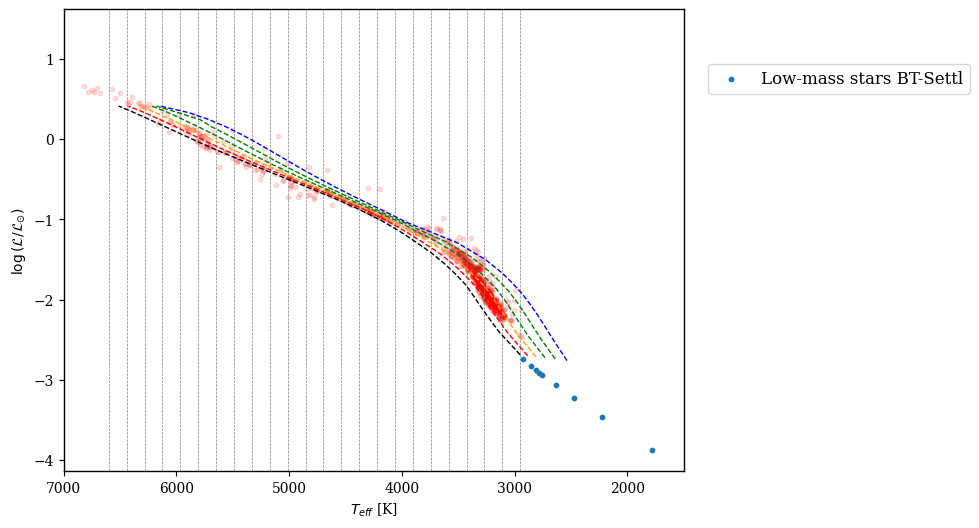

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.set_ylabel('$\log{(\mathcal{L}/\mathcal{L}_{\odot})}$')
ax.set_xlabel('$T_{eff}$ [K]')

ax.scatter(data_obs_Pleiades['Teff_x'], data_obs_Pleiades['log(L/Lsun)'], s=10, zorder=0, color='r', alpha=0.125)

ax.scatter(BTSettl_Li_isochrones_Teff['Teff'], BTSettl_Li_isochrones_Teff['log(L/Lsun)'], s=10, label='Low-mass stars BT-Settl')
#ax.scatter(BTSettl_Li_isochrones_Teff['G']-BTSettl_Li_isochrones_Teff['J'], G_abs_BC, s=10, label='Low-mass stars BT-Settl-BC')
#ax.plot(BTSettl_Li_isochrones_Teff['G']-BTSettl_Li_isochrones_Teff['J'], G_abs_BC, linewidth=1, label='Low-mass stars BT-Settl-BC', color='orange')

ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(1.25, 0.9))

ax.plot(SPOTS_edr3['00'][0.126]['Teff'], SPOTS_edr3['00'][0.126]['log(L/Lsun)'], label='SPOTS-YBC f000; 126 Myr', color='k', linewidth=1, linestyle='--')

ax.plot(SPOTS_edr3['17'][0.126]['Teff'], SPOTS_edr3['17'][0.126]['log(L/Lsun)'], label='SPOTS-YBC f017; 126 Myr', color='r', linewidth=1, linestyle='--')

ax.plot(SPOTS_edr3['34'][0.126]['Teff'], SPOTS_edr3['34'][0.126]['log(L/Lsun)'], label='SPOTS-YBC f034; 126 Myr', color='orange', linewidth=1, linestyle='--')

ax.plot(SPOTS_edr3['51'][0.126]['Teff'], SPOTS_edr3['51'][0.126]['log(L/Lsun)'], label='SPOTS-YBC f051; 126 Myr', color='green', linewidth=1, linestyle='--')

ax.plot(SPOTS_edr3['68'][0.126]['Teff'], SPOTS_edr3['68'][0.126]['log(L/Lsun)'], label='SPOTS-YBC f068; 126 Myr', color='green', linewidth=1, linestyle='--')

ax.plot(SPOTS_edr3['85'][0.126]['Teff'], SPOTS_edr3['85'][0.126]['log(L/Lsun)'], label='SPOTS-YBC f085; 126 Myr', color='blue', linewidth=1, linestyle='--')


# Draw vertical grid lines
for x in interval_x:
    ax.axvline(x, color='gray', linestyle='--', linewidth=0.5, zorder=0)
    
    
ax.set_xlim(1500, 7000)
    
ax.invert_xaxis()

In [146]:
data_obs_x = {}
data_obs_y = {}

# Iterate over the intervals defined by interval_x
for i in range(len(interval_x) - 1):
    # Select data within the current interval
    mask = (data_obs_Pleiades['Teff_x'] >= interval_x[i]) & (data_obs_Pleiades['Teff_x'] < interval_x[i+1])
    selected_data_x = data_obs_Pleiades['Teff_x'][mask]
    selected_data_y = data_obs_Pleiades['log(L/Lsun)'][mask]
    
    # Add the selected data to data_obs_x with the corresponding index as key
    data_obs_x[i] = selected_data_x
    data_obs_y[i] = selected_data_y


In [147]:
start_time = time.time()

# Run Bayesian inference for x coordinate intervals
posterior_x_t_Teff = []
std_array_Teff = []
for i in range(len(interval_x) - 1):
    logging.disable(logging.CRITICAL)
    x_interval_data = data_obs_x[i]
    x_posterior, std = run_bayesian_inference(x_interval_data, 'x')
    std_array_Teff.append(std)
    posterior_x_t_Teff.append(x_posterior)
    logging.disable(logging.NOTSET)

# Run Bayesian inference for y coordinate intervals
posterior_y_t_Teff = []
std_out_array_Teff = []
for i in range(len(interval_x) - 1):
    logging.disable(logging.CRITICAL)
    y_interval_data = data_obs_y[i]
    y_posterior, std_out = run_bayesian_inference_out(y_interval_data, 'y')
    std_out_array_Teff.append(std_out)
    posterior_y_t_Teff.append(y_posterior)
    logging.disable(logging.NOTSET)
    
end_time = time.time()

execution_time = end_time - start_time

minutes = int(execution_time // 60)
seconds = execution_time % 60

print(f'Exe. time: {minutes} minutos y {seconds:.2f} segundos.')

Exe. time: 7 minutos y 22.58 segundos.


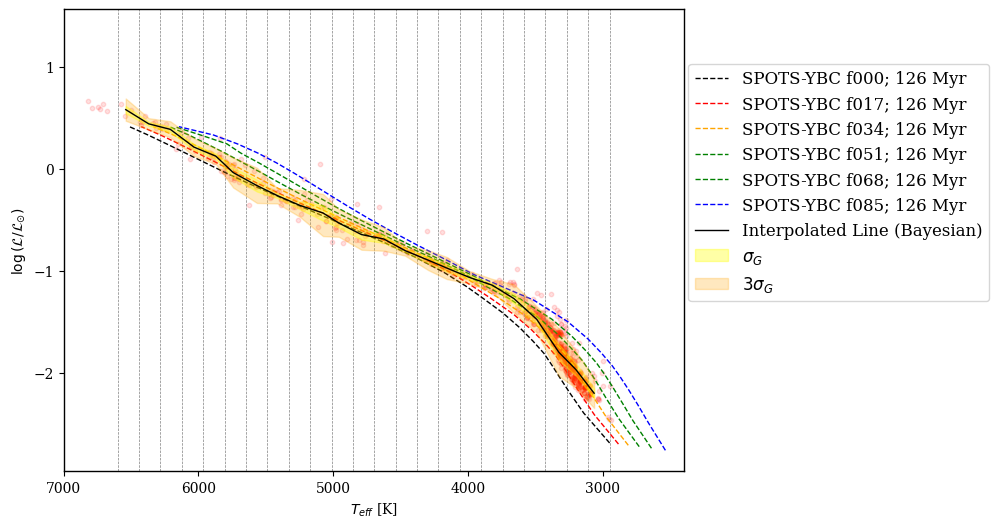

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.set_ylabel('$\log{(\mathcal{L}/\mathcal{L}_{\odot})}$')
ax.set_xlabel('$T_{eff}$ [K]')

ax.plot(SPOTS_edr3['00'][0.126]['Teff'], SPOTS_edr3['00'][0.126]['log(L/Lsun)'], label='SPOTS-YBC f000; 126 Myr', color='k', linewidth=1, linestyle='--')

ax.plot(SPOTS_edr3['17'][0.126]['Teff'], SPOTS_edr3['17'][0.126]['log(L/Lsun)'], label='SPOTS-YBC f017; 126 Myr', color='r', linewidth=1, linestyle='--')

ax.plot(SPOTS_edr3['34'][0.126]['Teff'], SPOTS_edr3['34'][0.126]['log(L/Lsun)'], label='SPOTS-YBC f034; 126 Myr', color='orange', linewidth=1, linestyle='--')

ax.plot(SPOTS_edr3['51'][0.126]['Teff'], SPOTS_edr3['51'][0.126]['log(L/Lsun)'], label='SPOTS-YBC f051; 126 Myr', color='green', linewidth=1, linestyle='--')

ax.plot(SPOTS_edr3['68'][0.126]['Teff'], SPOTS_edr3['68'][0.126]['log(L/Lsun)'], label='SPOTS-YBC f068; 126 Myr', color='green', linewidth=1, linestyle='--')

ax.plot(SPOTS_edr3['85'][0.126]['Teff'], SPOTS_edr3['85'][0.126]['log(L/Lsun)'], label='SPOTS-YBC f085; 126 Myr', color='blue', linewidth=1, linestyle='--')


ax.scatter(data_obs_Pleiades['Teff_x'], data_obs_Pleiades['log(L/Lsun)'], s=10, zorder=0, color='r', alpha=0.125)

# Draw vertical grid lines
for x in interval_x:
    ax.axvline(x, color='gray', linestyle='--', linewidth=0.5, zorder=0)

x_median_array_Teff = []
y_median_array_Teff = []
e_x_median_array_Teff = []
e_y_median_array_Teff = []

for i in range(len(posterior_x_t_Teff)):
    x_median = np.median(posterior_x_t_Teff[i].posterior['coord_mean_x'].values)
    y_median = np.median(posterior_y_t_Teff[i].posterior['coord_mean_y'].values)
    e_x_median = np.mean(std_array_Teff[i])
    e_y_median = np.mean(std_out_array_Teff[i])
    x_median_array_Teff.append(x_median)
    y_median_array_Teff.append(y_median)
    e_x_median_array_Teff.append(e_x_median)
    e_y_median_array_Teff.append(e_y_median)

ax.plot(x_median_array_Teff, y_median_array_Teff, linewidth=1, linestyle='-', color='k', label='Interpolated Line (Bayesian)', zorder=5)

ax.fill_between(np.sort(x_median_array_Teff), np.sort(np.array(y_median_array_Teff) + np.array(e_y_median_array_Teff)), np.sort(np.array(y_median_array_Teff) - np.array(e_y_median_array_Teff)), color='yellow', alpha=0.35, zorder=4, label=r'$\sigma_G$')
ax.fill_between(np.sort(x_median_array_Teff), np.sort(np.array(y_median_array_Teff) + 3*np.array(e_y_median_array_Teff)), np.sort(np.array(y_median_array_Teff) - 3*np.array(e_y_median_array_Teff)), color='orange', alpha=0.25, zorder=3, label=r'$3\sigma_G$')

ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(1.25, 0.9))

ax.set_xlim(2400, 7000)

ax.invert_xaxis()

In [149]:
# Define the models
models = [np.column_stack((SPOTS_edr3['00'][0.126]['Teff'], SPOTS_edr3['00'][0.126]['log(L/Lsun)'])),
         np.column_stack((SPOTS_edr3['17'][0.126]['Teff'], SPOTS_edr3['17'][0.126]['log(L/Lsun)'])),
         np.column_stack((SPOTS_edr3['34'][0.126]['Teff'], SPOTS_edr3['34'][0.126]['log(L/Lsun)'])),
         np.column_stack((SPOTS_edr3['51'][0.126]['Teff'], SPOTS_edr3['51'][0.126]['log(L/Lsun)'])),
         np.column_stack((SPOTS_edr3['68'][0.126]['Teff'], SPOTS_edr3['68'][0.126]['log(L/Lsun)'])),
         np.column_stack((SPOTS_edr3['85'][0.126]['Teff'], SPOTS_edr3['85'][0.126]['log(L/Lsun)']))]

# Define the models_info
models_info = [
    np.column_stack([SPOTS_edr3['00'][0.126][column] for column in SPOTS_edr3['00'][0.126].columns]),
    np.column_stack([SPOTS_edr3['17'][0.126][column] for column in SPOTS_edr3['17'][0.126].columns]),
    np.column_stack([SPOTS_edr3['34'][0.126][column] for column in SPOTS_edr3['34'][0.126].columns]),
    np.column_stack([SPOTS_edr3['51'][0.126][column] for column in SPOTS_edr3['51'][0.126].columns]),
    np.column_stack([SPOTS_edr3['68'][0.126][column] for column in SPOTS_edr3['68'][0.126].columns]),
    np.column_stack([SPOTS_edr3['85'][0.126][column] for column in SPOTS_edr3['85'][0.126].columns])
]

# Define the data
data = np.column_stack((x_median_array_Teff[::-1], y_median_array_Teff[::-1]))

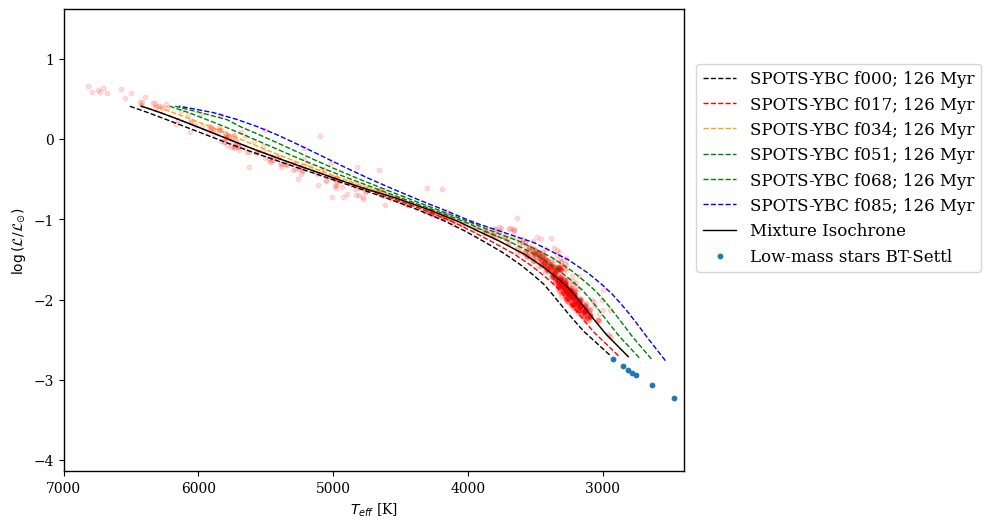

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.set_ylabel('$\log{(\mathcal{L}/\mathcal{L}_{\odot})}$')
ax.set_xlabel('$T_{eff}$ [K]')

ax.plot(SPOTS_edr3['00'][0.126]['Teff'], SPOTS_edr3['00'][0.126]['log(L/Lsun)'], label='SPOTS-YBC f000; 126 Myr', color='k', linewidth=1, linestyle='--')

ax.plot(SPOTS_edr3['17'][0.126]['Teff'], SPOTS_edr3['17'][0.126]['log(L/Lsun)'], label='SPOTS-YBC f017; 126 Myr', color='r', linewidth=1, linestyle='--')

ax.plot(SPOTS_edr3['34'][0.126]['Teff'], SPOTS_edr3['34'][0.126]['log(L/Lsun)'], label='SPOTS-YBC f034; 126 Myr', color='orange', linewidth=1, linestyle='--')

ax.plot(SPOTS_edr3['51'][0.126]['Teff'], SPOTS_edr3['51'][0.126]['log(L/Lsun)'], label='SPOTS-YBC f051; 126 Myr', color='green', linewidth=1, linestyle='--')

ax.plot(SPOTS_edr3['68'][0.126]['Teff'], SPOTS_edr3['68'][0.126]['log(L/Lsun)'], label='SPOTS-YBC f068; 126 Myr', color='green', linewidth=1, linestyle='--')

ax.plot(SPOTS_edr3['85'][0.126]['Teff'], SPOTS_edr3['85'][0.126]['log(L/Lsun)'], label='SPOTS-YBC f085; 126 Myr', color='blue', linewidth=1, linestyle='--')


SPOTS_Teff_iso = []
SPOTS_logL_iso = []
    
for i in range(1, 12):
    SPOTS_Teff_iso.append(SPOTS_edr3['17'][0.126]['Teff'].values[-i])
    SPOTS_logL_iso.append(SPOTS_edr3['17'][0.126]['log(L/Lsun)'].values[-i])
    
for i in range(12, 26):
    SPOTS_Teff_iso.append(SPOTS_edr3['34'][0.126]['Teff'].values[-i])
    SPOTS_logL_iso.append(SPOTS_edr3['34'][0.126]['log(L/Lsun)'].values[-i])

ax.plot(SPOTS_Teff_iso, SPOTS_logL_iso, zorder=5, label='Mixture Isochrone', color='k', linewidth=1)

ax.scatter(data_obs_Pleiades['Teff_x'], data_obs_Pleiades['log(L/Lsun)'], s=10, zorder=0, color='r', alpha=0.125)

ax.scatter(BTSettl_Li_isochrones_Teff['Teff'], BTSettl_Li_isochrones_Teff['log(L/Lsun)'], s=10, label='Low-mass stars BT-Settl')


ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(1.25, 0.9))

ax.set_xlim(2400, 7000)

ax.invert_xaxis()

Teff, d, BC -> M_i (correct BT-Settl to fix SPOTS for low-mass stars)

### BHAC15

In [107]:
def parse_file(file_path):
    data = {}
    current_key = None
    current_data = []
    columns_line = None
    
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            
            if line.startswith('!  t (Gyr) ='):
                if current_key is not None:
                    columns = ['M/Ms', 'Teff', 'L/Ls', 'g', 'R/Rs', 'Li/Li0', 'F33', 'F33B', 'F41', 'F45B', 'F47', 
                               'F51', 'FHa', 'F57', 'F63B', 'F67', 'F75', 'F78', 'F82', 'F82B', 'F89', 'G_RSV', 'G', 
                               'G_BP', 'G_RP']
                    df = pd.DataFrame(current_data, columns=columns)
                    df = df.dropna()
                    # Agregar la columna "age(Gyr)" con el valor de la clave actual
                    df['age(Gyr)'] = float(current_key)
                    data[current_key] = df
                    
                current_key = line.split('=')[1].strip()
                current_data = []
            elif line.startswith('!'):
                if columns_line is None:
                    columns_line = line
            else:
                current_data.append(line.split())
                
    if current_key is not None:
        columns = ['M/Ms', 'Teff', 'L/Ls', 'g', 'R/Rs', 'Li/Li0', 'F33', 'F33B', 'F41', 'F45B', 'F47', 
                   'F51', 'FHa', 'F57', 'F63B', 'F67', 'F75', 'F78', 'F82', 'F82B', 'F89', 'G_RSV', 'G', 
                   'G_BP', 'G_RP']
        df = pd.DataFrame(current_data, columns=columns)
        df = df.dropna()
        # Agregar la columna "age(Gyr)" con el valor de la clave actual
        df['age(Gyr)'] = float(current_key)
        data[current_key] = df
        
    return data

# Ejemplo de uso
file_path = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/BHAC15_iso.GAIA.txt'
BHAC15_dict = parse_file(file_path)

In [108]:
#BHAC15_dict

In [109]:
def save_to_csv(data_dict, file_path):
    combined_df = pd.concat(data_dict.values(), ignore_index=True)
    
    csv_file_path = file_path.replace('.txt', '.csv')
    combined_df.to_csv(csv_file_path, header=False, index=False)
    
    with open(csv_file_path, 'r') as f:
        lines = f.readlines()
    lines.insert(0, ','.join(combined_df.columns) + '\n')
    with open(csv_file_path, 'w') as f:
        f.writelines(lines)


save_to_csv(BHAC15_dict, file_path)

csv_file_path = '/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/BHAC15_iso.GAIA.csv'

df = pd.read_csv(csv_file_path)

df = df.set_index(df.index - 1)

# Renombrar las columnas
column_names = ['M/Ms', 'Teff', 'L/Ls', 'g', 'R/Rs', 'Li/Li0', 'F33', 'F33B', 'F41', 'F45B', 
                'F47', 'F51', 'FHa', 'F57', 'F63B', 'F67', 'F75', 'F78', 'F82', 'F82B', 
                'F89', 'G_RSV', 'G', 'G_BP', 'G_RP', 'age(Gyr)']
df.columns = column_names

df.index = df.index + 1

df.to_csv('/pcdisk/dalen/lgonzalez/OneDrive/Escritorio/CAB_INTA-CSIC/01-Doctorado/013-Jupyter/0134-biosc_env/data/BHAC15_iso.GAIA.csv')

### Isochrones plots

In [110]:
plt.rcParams.update({'font.size': 14, 'axes.linewidth': 1, 'axes.edgecolor': 'k'})
plt.rcParams['font.family'] = 'serif'

Isochrones in HRD (interior) and CMD (atmosphere)

[[ 0.5212843   2.04256859]
 [ 2.61163962  6.22327925]
 [ 6.80778139 14.61556277]
 [ 8.88891805 18.77783609]]


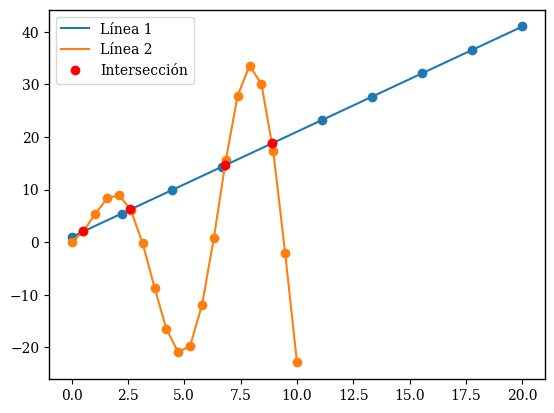

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.lines import Line2D

plt.rcParams.update({'font.size': 10})  # Set the font size

def find_intersection(line1, line2):
    intersection_points = []
    for i in range(len(line1) - 1):
        for j in range(len(line2) - 1):
            path1 = Path([line1[i], line1[i+1]])
            path2 = Path([line2[j], line2[j+1]])
            if path1.intersects_path(path2):
                x_int, y_int = get_intersection(line1[i], line1[i+1], line2[j], line2[j+1])
                intersection_points.append((x_int, y_int))
    return intersection_points

def get_intersection(p1, p2, p3, p4):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denom == 0:
        return None, None
    x_int = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
    y_int = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom
    return x_int, y_int

x1 = np.linspace(0, 20, 10)
y1 = 2 * x1 + 1

x2 = np.linspace(0, 10, 20)
y2 = (4 * x2 + 2)*np.sin(x2)

intersection_points = find_intersection(np.column_stack((x1, y1)), np.column_stack((x2, y2)))

plt.plot(x1, y1, label='Línea 1')
plt.plot(x2, y2, label='Línea 2')
plt.scatter(x1, y1)
plt.scatter(x2, y2)

if intersection_points:
    intersection_points = np.array(intersection_points)
    plt.plot(intersection_points[:, 0], intersection_points[:, 1], 'ro', label='Intersección')

print(intersection_points)
    

plt.legend()
plt.show()

In [112]:
bands1 = [['G', 'RP'], ['G', 'J'], ['J', 'K'], ['G', 'y'], ['G', 'z']]
bands2 = [['G_i00', 'G_RP_i00'], ['G_i00', 'J_i00'], ['J_i00', 'Ks_i00'], ['G_i00', 'yP1_i00'], ['G_i00', 'zP1_i00']]
bandsobs = [['g', 'rp'], ['g', 'Jmag'], ['Jmag', 'Kmag'], ['g', 'ymag'], ['g', 'zmag']]


# Function to get the first word of a string
def get_first_word(string):
    return string.split()[0]

# Function to save the model comparison
def save_model_comparison(filename, mod1, mod2, dpi=400):
    mod1_first_word = get_first_word(mod1)
    mod2_first_word = get_first_word(mod2)
    final_filename = f"{filename}_{mod1_first_word}_{mod2_first_word}.png"
    plt.savefig(final_filename, dpi=dpi, bbox_inches='tight')

# Function to find intersection between two lines
def find_intersection(line1, line2):
    intersection_points = []
    for i in range(len(line1) - 1):
        for j in range(len(line2) - 1):
            path1 = Path([line1[i], line1[i+1]])
            path2 = Path([line2[j], line2[j+1]])
            if path1.intersects_path(path2):
                x_int, y_int = get_intersection(line1[i], line1[i+1], line2[j], line2[j+1])
                intersection_points.append((x_int, y_int))
    return intersection_points

# Function to find the intersection point between two line segments
def get_intersection(p1, p2, p3, p4):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denom == 0:
        return None, None
    x_int = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
    y_int = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom
    return x_int, y_int    

# Definition of bands
bands1 = [['G', 'RP'], ['G', 'J'], ['J', 'K'], ['G', 'y'], ['G', 'z']]
bands2 = [['G_i00', 'G_RP_i00'], ['G_i00', 'J_i00'], ['J_i00', 'Ks_i00'], ['G_i00', 'yP1_i00'], ['G_i00', 'zP1_i00']]
bandsobs = [['g', 'rp'], ['g', 'Jmag'], ['Jmag', 'Kmag'], ['g', 'ymag'], ['g', 'zmag']]

# Main function to plot the isochrones grid
def plot_isochrones_grid(model1_dict, model2_dict, bands1, bands2, mod1, mod2, filename=None, dpi=350, data_obs=None, obs=False):
    plt.rcParams.update({'font.size': 26})  # Set the font size

    fig, axs = plt.subplots(4, 5, figsize=(55, 28), sharex='col')  # Create the figure and subplots
    isochrones = [0.02, 0.08, 0.12, 0.6]  # List of isochrones to use
    max_mass_labels = 5  # Maximum number of mass labels to show
    
    legend_labels = {f'{get_first_word(mod1)}': f'{get_first_word(mod1)}',
                     f'{get_first_word(mod2)}': f'{get_first_word(mod2)}',
                     'Obs': 'Obs'}
    
    # Iterate over each column (band combination)
    for i, (band1, band2) in enumerate(zip(bands1, bands2)):
        max_x_column = float('-inf')
        max_y = float('-inf')

        # Iterate over each row (isochrone)
        for j, isochrone in enumerate(isochrones):
            ax = axs[j, i]
            isochrone_1 = min(model1_dict.keys(), key=lambda x: abs(x - isochrone))
            isochrone_2 = min(model2_dict.keys(), key=lambda x: abs(x - isochrone))

            model1_df = model1_dict[isochrone_1]
            model1_df = model1_df.loc[model1_df['M/Ms'] < 1.5]
            model1_df = model1_df.loc[model1_df['M/Ms'] > 0.08]
            
            model2_df = model2_dict[isochrone_2]
            model2_df = model2_df.loc[model2_df['M/Ms'] < 1.5]
            model2_df = model2_df.loc[model2_df['M/Ms'] > 0.08]
            
            min_mm_model1 = min(model1_df['M/Ms'])
            min_mm_model2 = min(model2_df['M/Ms'])

            mm_values = np.linspace(1.5, min(min_mm_model1, min_mm_model2), 5)

            x1 = model1_dict[isochrone_1][band1[0]] - model1_dict[isochrone_1][band1[1]]
            y1 = model1_dict[isochrone_1][band1[0]]
            x2 = model2_dict[isochrone_2][band2[0]] - model2_dict[isochrone_2][band2[1]]
            y2 = model2_dict[isochrone_2][band2[0]]

            ax.plot(x1, y1, label=f'{get_first_word(mod1)}', zorder=2, linewidth=2, color='blue')
            ax.plot(x2, y2, label=f'{get_first_word(mod2)}', zorder=1, linewidth=2, color='orange')

            max_x_column = max(max_x_column, np.max(x1), np.max(x2))
            max_y = max(max_y, np.max(y1), np.max(y2))
            
            for mm_value in mm_values:
                closest_row_model1 = model1_df.iloc[(model1_df['M/Ms'] - mm_value).abs().argsort()[:1]]
                closest_row_model2 = model2_df.iloc[(model2_df['M/Ms'] - mm_value).abs().argsort()[:1]]

                x_mass_model1 = closest_row_model1[band1[0]] - closest_row_model1[band1[1]]
                y_mass_model1 = closest_row_model1[band1[0]]
                mass_model1 = closest_row_model1['M/Ms']

                x_mass_model2 = closest_row_model2[band2[0]] - closest_row_model2[band2[1]]
                y_mass_model2 = closest_row_model2[band2[0]]
                mass_model2 = closest_row_model2['M/Ms']

                for x_mass1, y_mass1, mass1, x_mass2, y_mass2, mass2 in zip(x_mass_model1, y_mass_model1, mass_model1, x_mass_model2, y_mass_model2, mass_model2):
                    text = f'{((mass1+mass2)/2):.3f}'
                    text_length = len(text) * 0.15  # Estimar la longitud del texto (suponiendo 0.15 como el ancho aproximado por carácter)
                    text_height = 0.03  # Estimar la altura del texto (suponiendo 0.03)

                    if x_mass2 - x_mass1 < 0:
                        text_x = x_mass1 + (1/30)*(max_x_column+0.2)
                        ax.text(text_x, y_mass1, text, fontsize=12, color='k')
                    elif x_mass1 - x_mass2 < 0:
                        text_x = x_mass2 + (1/30)*(max_x_column+0.2)
                        ax.text(text_x, y_mass2, text, fontsize=12, color='k')

                    ax.plot([x_mass1, x_mass2], [y_mass1, y_mass2], color='k', linewidth=1)

            intersection_points = find_intersection(np.column_stack((x1, y1)), np.column_stack((x2, y2)))

            if intersection_points:
                first_point = intersection_points[0]
                if -0.2 <= first_point[0] <= max_x_column and 1 <= first_point[1] <= max_y:
                    ax.plot([-0.2, first_point[0]], [first_point[1], first_point[1]], color='black', linewidth=1, linestyle='--')
                    ax.plot([first_point[0], first_point[0]], [max_y, first_point[1]], color='black', linewidth=1, linestyle='--')
                    ax.text(0.55, 0.95, f'({first_point[0]:.2f}, {first_point[1]:.2f})', fontsize=18, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='black')  # Adjusted position for text
                else:
                    pass
            
            # Plot observational data if available
            if obs and (isochrone == 0.08 or isochrone == 0.12):  # Agregar esta condición para dibujar solo para isocronas de 0.080 y 0.120
                ax.errorbar(data_obs[f'{bandsobs[i][0]}'+'_abs']-data_obs[f'{bandsobs[i][1]}'+'_abs'],
                            data_obs[f'{bandsobs[i][0]}'+'_abs'], 
                            yerr=data_obs['e_'+f'{bandsobs[i][0]}'], fmt='.', alpha=0.125, label='Obs', zorder=0, color='r')

            if j == 3:
                ax.set_xlabel(f'{band1[0]}-{band1[1]} [mag]')
                ax.set_ylabel(f'{band1[0]} [mag]')
                ax.xaxis.set_major_locator(ticker.AutoLocator())
                ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
                ax.text(0.825, 0.85, f'{isochrone_1} Gyr', transform=ax.transAxes, fontsize=18, verticalalignment='bottom', horizontalalignment='left')  # Adjusted position for text

            else:
                ax.set_ylabel(f'{band1[0]} [mag]')
                ax.set_xticklabels([])
                ax.tick_params(axis='both', which='both', length=5)

                ax.text(0.825, 0.85, f'{round(isochrone_1, 3)} Gyr', transform=ax.transAxes, fontsize=18, verticalalignment='bottom', horizontalalignment='left')  # Adjusted position for text

            ax.set_xlim(-0.2, max_x_column+(1/8)*(max_x_column+0.2))
            ax.set_ylim(1, max_y)
            ax.invert_yaxis()

    plt.subplots_adjust(hspace=0, wspace=0.175)
    fig.suptitle(f'CMD; {mod1} vs {mod2}', y=0.94)
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = list(set(labels))
    legend_handles = [handles[labels.index(label)] for label in unique_labels]
    if obs:
        legend_handles.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Obs'))  # Add observation marker to the legend
    fig.legend(legend_handles, unique_labels + ['Obs'], loc='upper center', bbox_to_anchor=(0.5, 0.9225), fontsize=24, ncol=3, edgecolor='black')  # Añadir leyenda debajo del título
    if filename:
        save_model_comparison(filename, mod1, mod2, dpi=dpi)
    plt.show()
    
    plt.rcParams.update({'font.size': 14})  # Set the font size


# Main function to plot a single column of isochrones grid
def plot_single_column(model1_dict, model2_dict, band1, band2, bandobs, mod1, mod2, filename=None, dpi=350, data_obs=None, obs=False):
    plt.rcParams.update({'font.size': 14})  # Set the font size

    fig, axs = plt.subplots(4, 1, figsize=(10, 28), sharex='col')  # Create the figure and subplots
    isochrones = [0.02, 0.08, 0.12, 0.6]  # List of isochrones to use
    max_mass_labels = 5  # Maximum number of mass labels to show
    
    legend_labels = {f'{get_first_word(mod1)}': f'{get_first_word(mod1)}',
                     f'{get_first_word(mod2)}': f'{get_first_word(mod2)}',
                     'Obs': 'Obs'}
    
    # Iterate over each row (isochrone)
    for j, isochrone in enumerate(isochrones):
        ax = axs[j]
        isochrone_1 = min(model1_dict.keys(), key=lambda x: abs(x - isochrone))
        isochrone_2 = min(model2_dict.keys(), key=lambda x: abs(x - isochrone))

        model1_df = model1_dict[isochrone_1]
        model1_df = model1_df.loc[model1_df['M/Ms'] < 1.5]
        model1_df = model1_df.loc[model1_df['M/Ms'] > 0.08]
        
        model2_df = model2_dict[isochrone_2]
        model2_df = model2_df.loc[model2_df['M/Ms'] < 1.5]
        model2_df = model2_df.loc[model2_df['M/Ms'] > 0.08]
        
        min_mm_model1 = min(model1_df['M/Ms'])
        min_mm_model2 = min(model2_df['M/Ms'])

        mm_values = np.linspace(1.5, min(min_mm_model1, min_mm_model2), 5)

        x1 = model1_dict[isochrone_1][band1[0]] - model1_dict[isochrone_1][band1[1]]
        y1 = model1_dict[isochrone_1][band1[2]]
        x2 = model2_dict[isochrone_2][band2[0]] - model2_dict[isochrone_2][band2[1]]
        y2 = model2_dict[isochrone_2][band2[2]]

        ax.plot(x1, y1, label=f'{get_first_word(mod1)}', zorder=2, linewidth=2, color='blue')
        ax.plot(x2, y2, label=f'{get_first_word(mod2)}', zorder=1, linewidth=2, color='orange')

        max_x_column = max(np.max(x1), np.max(x2))
        max_y = max(np.max(y1), np.max(y2))
        
        for mm_value in mm_values:
            closest_row_model1 = model1_df.iloc[(model1_df['M/Ms'] - mm_value).abs().argsort()[:1]]
            closest_row_model2 = model2_df.iloc[(model2_df['M/Ms'] - mm_value).abs().argsort()[:1]]

            x_mass_model1 = closest_row_model1[band1[0]] - closest_row_model1[band1[1]]
            y_mass_model1 = closest_row_model1[band1[2]]
            mass_model1 = closest_row_model1['M/Ms']

            x_mass_model2 = closest_row_model2[band2[0]] - closest_row_model2[band2[1]]
            y_mass_model2 = closest_row_model2[band2[2]]
            mass_model2 = closest_row_model2['M/Ms']

            for x_mass1, y_mass1, mass1, x_mass2, y_mass2, mass2 in zip(x_mass_model1, y_mass_model1, mass_model1, x_mass_model2, y_mass_model2, mass_model2):
                text = f'{((mass1+mass2)/2):.3f}'
                text_length = len(text) * 0.15  # Estimar la longitud del texto (suponiendo 0.15 como el ancho aproximado por carácter)
                text_height = 0.03  # Estimar la altura del texto (suponiendo 0.03)

                if x_mass2 - x_mass1 < 0:
                    text_x = x_mass1 + (1/30)*(max_x_column+0.2)
                    ax.text(text_x, y_mass1, text, fontsize=12, color='k')
                elif x_mass1 - x_mass2 < 0:
                    text_x = x_mass2 + (1/30)*(max_x_column+0.2)
                    ax.text(text_x, y_mass2, text, fontsize=12, color='k')

                ax.plot([x_mass1, x_mass2], [y_mass1, y_mass2], color='k', linewidth=1)

        intersection_points = find_intersection(np.column_stack((x1, y1)), np.column_stack((x2, y2)))

        if intersection_points:
            first_point = intersection_points[0]
            if -0.2 <= first_point[0] <= max_x_column and 1 <= first_point[1] <= max_y:
                ax.plot([-0.2, first_point[0]], [first_point[1], first_point[1]], color='black', linewidth=1, linestyle='--')
                ax.plot([first_point[0], first_point[0]], [max_y, first_point[1]], color='black', linewidth=1, linestyle='--')
                ax.text(0.55, 0.95, f'({first_point[0]:.2f}, {first_point[1]:.2f})', fontsize=18, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='black')  # Adjusted position for text
            else:
                pass

        # Plot observational data if available
        if obs and (isochrone == 0.08 or isochrone == 0.12):  # Agregar esta condición para dibujar solo para isocronas de 0.080 y 0.120
            ax.errorbar(data_obs[f'{bandobs[0]}'+'_abs']-data_obs[f'{bandobs[1]}'+'_abs'],
                        data_obs[f'{bandobs[2]}'+'_abs'], 
                        yerr=data_obs['e_'+f'{bandobs[2]}'], fmt='.', alpha=0.125, label='Obs', zorder=0, color='r')

        ax.set_xlabel(f'{band1[0]}-{band1[1]} [mag]')
        ax.set_ylabel(f'{band1[2]} [mag]')
        ax.xaxis.set_major_locator(ticker.AutoLocator())
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
        ax.text(0.825, 0.85, f'{round(isochrone_1, 3)} Gyr', transform=ax.transAxes, fontsize=18, verticalalignment='bottom', horizontalalignment='left')  # Adjusted position for text

        ax.set_xlim(-0.2, 6)
        ax.set_ylim(1, max_y)
        ax.invert_yaxis()

    plt.subplots_adjust(hspace=0)
    fig.suptitle(f'CMD; {mod1} vs {mod2}', y=0.9075)
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = list(set(labels))
    legend_handles = [handles[labels.index(label)] for label in unique_labels]
    if obs:
        legend_handles.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Obs'))  # Add observation marker to the legend
    fig.legend(legend_handles, unique_labels + ['Obs'], loc='upper center', bbox_to_anchor=(0.5, 0.9), fontsize=16, ncol=3, edgecolor='black')  # Añadir leyenda debajo del título
    if filename:
        save_model_comparison(filename, mod1, mod2, dpi=dpi)
    plt.show()

    plt.rcParams.update({'font.size': 14})  # Set the font size

def plot_single_column_Teff(model1_dict, model2_dict, mod1, mod2, filename=None, dpi=350, data_obs=None, obs=False):
    plt.rcParams.update({'font.size': 14})  # Set the font size

    fig, axs = plt.subplots(4, 1, figsize=(10, 28), sharex='col')  # Create the figure and subplots
    isochrones = [0.02, 0.08, 0.12, 0.6]  # List of isochrones to use
    max_mass_labels = 5  # Maximum number of mass labels to show
    
    legend_labels = {f'{get_first_word(mod1)}': f'{get_first_word(mod1)}',
                     f'{get_first_word(mod2)}': f'{get_first_word(mod2)}',
                     'Obs': 'Obs'}
    
    # Iterate over each row (isochrone)
    for j, isochrone in enumerate(isochrones):
        ax = axs[j]
        isochrone_1 = min(model1_dict.keys(), key=lambda x: abs(x - isochrone))
        isochrone_2 = min(model2_dict.keys(), key=lambda x: abs(x - isochrone))
        
        model1_df = model1_dict[isochrone_1]
        model1_df = model1_df.loc[model1_df['M/Ms'] < 1.5]
        model1_df = model1_df.loc[model1_df['M/Ms'] > 0.08]
        
        model2_df = model2_dict[isochrone_2]
        model2_df = model2_df.loc[model2_df['M/Ms'] < 1.5]
        model2_df = model2_df.loc[model2_df['M/Ms'] > 0.08]
        
        min_mm_model1 = min(model1_df['M/Ms'])
        min_mm_model2 = min(model2_df['M/Ms'])

        mm_values = np.linspace(1.5, min(min_mm_model1, min_mm_model2), 5)

        x1 = model1_dict[isochrone_1]['Teff']
        y1 = np.log10(model1_dict[isochrone_1]['Lsun'])
        x2 = model2_dict[isochrone_2]['Teff']
        y2 = np.log10(model2_dict[isochrone_2]['Lsun'])

        ax.plot(x1, y1, label=f'{get_first_word(mod1)}', zorder=2, linewidth=2, color='blue')
        ax.plot(x2, y2, label=f'{get_first_word(mod2)}', zorder=1, linewidth=2, color='orange')

        max_x_column = max(np.max(x1), np.max(x2))
        max_y = max(np.max(y1), np.max(y2))
        
        for mm_value in mm_values:
            closest_row_model1 = model1_df.iloc[(model1_df['M/Ms'] - mm_value).abs().argsort()[:1]]
            closest_row_model2 = model2_df.iloc[(model2_df['M/Ms'] - mm_value).abs().argsort()[:1]]

            x_mass_model1 = closest_row_model1['Teff']
            y_mass_model1 = np.log10(closest_row_model1['Lsun'])
            mass_model1 = closest_row_model1['M/Ms']

            x_mass_model2 = closest_row_model2['Teff']
            y_mass_model2 = np.log10(closest_row_model2['Lsun'])
            mass_model2 = closest_row_model2['M/Ms']

            for x_mass1, y_mass1, mass1, x_mass2, y_mass2, mass2 in zip(x_mass_model1, y_mass_model1, mass_model1, x_mass_model2, y_mass_model2, mass_model2):
                text = f'{((mass1+mass2)/2):.3f}'
                text_length = len(text) * 0.15  # Estimar la longitud del texto (suponiendo 0.15 como el ancho aproximado por carácter)
                text_height = 0.03  # Estimar la altura del texto (suponiendo 0.03)

                if y_mass2+10 - (y_mass1+10) < 0:
                    text_x = x_mass1 + (1/10)*(8000-1000)
                    ax.text(text_x, y_mass1-0.25, text, fontsize=12, color='k')
                elif y_mass2+10 - (y_mass1+10) > 0:
                    text_x = x_mass2 + 75
                    ax.text(text_x, y_mass2+0.25, text, fontsize=12, color='k')

                ax.plot([x_mass1, x_mass2], [y_mass1, y_mass2], color='k', linewidth=1)

        intersection_points = find_intersection(np.column_stack((x1, y1)), np.column_stack((x2, y2)))

        if intersection_points:
            first_point = intersection_points[0]
            if 1000 <= first_point[0] <= 8000 and -4.5 <= first_point[1] <= 1.2:
                ax.plot([first_point[0], 8200], [first_point[1], first_point[1]], color='black', linewidth=1, linestyle='--')
                ax.plot([first_point[0], first_point[0]], [-4.5, first_point[1]], color='black', linewidth=1, linestyle='--')
                ax.text(0.55, 0.95, f'({first_point[0]:.2f}, {first_point[1]:.2f})', fontsize=18, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='black')  # Adjusted position for text
            else:
                pass

        # Plot observational data if available
        if obs and (isochrone == 0.08 or isochrone == 0.12):  # Agregar esta condición para dibujar solo para isocronas de 0.080 y 0.120
            ax.scatter(data_obs['Teff_x'],
                        np.log10(data_obs['Lsun']),
                        alpha=0.125, label='Obs', s=10, zorder=0, color='r')

        ax.set_xlabel('$T_{eff}$ [K]')
        ax.set_ylabel('$\log{(\mathcal{L}/\mathcal{L}_{\odot})}$')
        ax.xaxis.set_major_locator(ticker.AutoLocator())
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
        ax.text(0.825, 0.85, f'{round(isochrone_1, 3)} Gyr', transform=ax.transAxes, fontsize=18, verticalalignment='bottom', horizontalalignment='left')  # Adjusted position for text

        ax.set_xlim(2000, 8200)
        ax.set_ylim(-3.75, 1.35)
        ax.invert_xaxis()

    plt.subplots_adjust(hspace=0)
    fig.suptitle(f'HRD; {mod1} vs {mod2}', y=0.9075)
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = list(set(labels))
    legend_handles = [handles[labels.index(label)] for label in unique_labels]
    if obs:
        legend_handles.append(Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='Obs'))  # Add observation marker to the legend
    fig.legend(legend_handles, unique_labels + ['Obs'], loc='upper center', bbox_to_anchor=(0.5, 0.9), fontsize=16, ncol=3, edgecolor='black')  # Añadir leyenda debajo del título
    if filename:
        save_model_comparison(filename, mod1, mod2, dpi=dpi)
    plt.show()

    plt.rcParams.update({'font.size': 14})  # Set the font size
    
# Example usage
#plot_isochrones_grid(BTSettl_Li_isochrones, PARSEC_iso_omega_00_Phot_dict, bands1, bands2, 'BT-Settl $\odot$', r'PARSEC $\omega_i=0.0$; $Z=0.001547$', filename='model_comparison', data_obs=data_obs_Pleiades, obs=True)

In [113]:
#plot_single_column_Teff(BTSettl_Li_isochrones, PARSEC_iso_omega_00_sun_Phot_dict, 'BT-Settl $\odot$', r'PARSEC $\omega_i=0.0$; $Y=0.2612$, $Z=0.007135$', filename='model_Teff_x_sun', dpi=350, data_obs=data_obs_Pleiades, obs=True)

In [114]:
#plot_single_column_Teff(BTSettl_Li_isochrones, PARSEC_iso_omega_00_Phot_dict, 'BT-Settl $\odot$', r'PARSEC $\omega_i=0.0$; $Y=0.2612$, $Z=0.007135$', filename='model_Teff_x', dpi=350, data_obs=data_obs_Pleiades, obs=True)

In [115]:
#plot_single_column_Teff(MIST_FULL, PARSEC_iso_omega_00_sun_Phot_dict, r'MIST $v/v_{\rm crit}=0.0$; [Fe/H]$=0.0$; $Y= 0.2703$, $Z=0.0143$', r'PARSEC $\omega_i=0.0$; $Y=0.2612$, $Z=0.007135$', filename='model_Teff_x11', dpi=350, data_obs=data_obs_Pleiades, obs=True)

In [116]:
#plot_single_column_Teff(MIST_FULL_2, PARSEC_iso_omega_00_sun_Phot_dict, r'MIST $v/v_{\rm crit}=0.0$; [Fe/H]$=0.25$; $Y= 0.2869$, $Z=0.0254$', r'PARSEC $\omega_i=0.0$; $Y=0.2612$, $Z=0.007135$', filename='model_Teff_x21', dpi=350, data_obs=data_obs_Pleiades, obs=True)

In [117]:
#plot_single_column_Teff(MIST_FULL, PARSEC_iso_omega_00_Phot_dict, r'MIST $v/v_{\rm crit}=0.0$; [Fe/H]$=0.0$; $Y= 0.2703$, $Z=0.0143$', r'PARSEC $\omega_i=0.0$; $Y=0.2747$, $Z=0.01471$', filename='model_Teff_x12', dpi=350, data_obs=data_obs_Pleiades, obs=True)

In [118]:
#plot_single_column_Teff(MIST_FULL_2, PARSEC_iso_omega_00_Phot_dict, r'MIST $v/v_{\rm crit}=0.0$; [Fe/H]$=0.25$; $Y= 0.2869$, $Z=0.0254$', r'PARSEC $\omega_i=0.0$; $Y=0.2747$, $Z=0.01471$', filename='model_Teff_x22', dpi=350, data_obs=data_obs_Pleiades, obs=True)

In [119]:
#plot_single_column_Teff(BTSettl_Li_isochrones, PARSEC_iso_omega_00_sun_Phot_dict, 'BT-Settl $\odot$', r'PARSEC $\omega_i=0.0$; $Y=0.2612$, $Z=0.007135$', filename='model_Teff_x_sun', dpi=350, data_obs=data_obs_Pleiades, obs=True)

In [120]:
#plot_single_column_Teff(BTSettl_Li_isochrones, PARSEC_iso_omega_00_Phot_dict, 'BT-Settl $\odot$', r'PARSEC $\omega_i=0.0$; $Y=0.2747$, $Z=0.01471$', filename='model_Teff_x', dpi=350, data_obs=data_obs_Pleiades, obs=True)

In [121]:
#plot_single_column_Teff(MIST_00_00, PARSEC_iso_omega_00_Phot_dict, r'MIST $v/v_{\rm crit}=0.0$; [Fe/H]$=0.0$', r'PARSEC $\omega_i=0.0$; $Y=0.2747$, $Z=0.01471$', filename='model_Teff_x', dpi=350, data_obs=data_obs_Pleiades, obs=True)

In [122]:
#plot_isochrones_grid(BTSettl_Li_isochrones, PARSEC_iso_omega_00_Phot_dict, bands1, bands2, 'BT-Settl $\odot$', r'PARSEC $\omega_i=0.0$; $Y=0.2747$, $Z=0.01471$', filename='model_comparison', data_obs=data_obs_Pleiades, obs=True)

In [123]:
#plot_isochrones_grid(BTSettl_Li_isochrones, MIST_FULL, bands1, bands1, 'BT-Settl $\odot$', r'MIST $v/v_{\rm crit}=0.0$; [Fe/H]$=0.0$; $Y= 0.2703$, $Z=0.0143$', filename='model_comparison', data_obs=data_obs_Pleiades, obs=True)


In [124]:
#plot_isochrones_grid(BTSettl_Li_isochrones, MIST_FULL_2, bands1, bands1, 'BT-Settl $\odot$', r'MIST $v/v_{\rm crit}=0.0$; [Fe/H]$=0.25$; $Y= 0.2869$, $Z=0.0254$', filename='model_comparison_2', data_obs=data_obs_Pleiades, obs=True)


In [125]:
#plot_isochrones_grid(MIST_FULL, PARSEC_iso_omega_00_Phot_dict, bands1, bands2, r'MIST $v/v_{\rm crit}=0.0$; [Fe/H]$=0.25$; $Y= 0.2703$, $Z=0.0143$', r'PARSEC $\omega_i=0.0$; $Y=0.2747$, $Z=0.01471$', filename='model_comparison', data_obs=data_obs_Pleiades, obs=True)


In [126]:
#plot_isochrones_grid(MIST_FULL_2, PARSEC_iso_omega_00_Phot_dict, bands1, bands2, r'MIST $v/v_{\rm crit}=0.0$; [Fe/H]$=0.25$; $Y= 0.2869$, $Z=0.0254$', r'PARSEC $\omega_i=0.0$; $Y=0.2747$, $Z=0.01471$', filename='model_comparison_2', data_obs=data_obs_Pleiades, obs=True)


In [127]:
['BP', 'RP', 'G']#plot_single_column(BTSettl_Li_isochrones, PARSEC_iso_omega_00_Phot_dict, ['BP','RP', 'G'], ['G_BP_i00', 'G_RP_i00', 'G_i00'], ['BP', 'RP', 'G'], 'BT-Settl $\odot$', r'PARSEC $\omega_i=0.0$; $Y=0.2747$, $Z=0.01471$', filename='model_color', dpi=350, data_obs=data_obs_Pleiades, obs=True)

['BP', 'RP', 'G']

In [128]:
#plot_single_column(BTSettl_Li_isochrones, PARSEC_iso_omega_00_sun_Phot_dict, ['BP','RP', 'G'], ['G_BP_i00', 'G_RP_i00', 'G_i00'], ['BP', 'RP', 'G'], 'BT-Settl $\odot$', r'PARSEC $\omega_i=0.0$; $Y=0.2612$, $Z=0.007135$', filename='model_color_sun', dpi=350, data_obs=data_obs_Pleiades, obs=True)

In [129]:
#plot_single_column(BTSettl_Li_isochrones, PARSEC_iso_omega_00_sun_Phot_dict, ['BP','RP', 'G'], ['G_BP_i00', 'G_RP_i00', 'G_i00'], ['BP', 'RP', 'G'], 'BT-Settl $\odot$', r'PARSEC $\omega_i=0.0$; $Y=0.2612$, $Z=0.007135$', filename='model_color_x_sun', dpi=350, data_obs=data_obs_Pleiades, obs=True)

In [130]:
#plot_single_column(BTSettl_Li_isochrones, PARSEC_iso_omega_00_Phot_dict, ['BP','RP', 'G'], ['G_BP_i00', 'G_RP_i00', 'G_i00'], ['BP', 'RP', 'G'], 'BT-Settl $\odot$', r'PARSEC $\omega_i=0.0$; $Y=0.2747$, $Z=0.01471$', filename='model_color_x', dpi=350, data_obs=data_obs_Pleiades, obs=True)

In [131]:
#plot_single_column(MIST_FULL, PARSEC_iso_omega_00_sun_Phot_dict, ['BP','RP', 'G'], ['G_BP_i00', 'G_RP_i00', 'G_i00'], ['BP', 'RP', 'G'], r'MIST $v/v_{\rm crit}=0.0$; [Fe/H]$=0.0$; $Y= 0.2703$, $Z=0.0143$', r'PARSEC $\omega_i=0.0$; $Y=0.2612$, $Z=0.00714$', filename='model_color_x11', dpi=350, data_obs=data_obs_Pleiades, obs=True)
#plot_single_column(MIST_FULL_2, PARSEC_iso_omega_00_sun_Phot_dict, ['BP','RP', 'G'], ['G_BP_i00', 'G_RP_i00', 'G_i00'], ['BP', 'RP', 'G'], r'MIST $v/v_{\rm crit}=0.0$; [Fe/H]$=0.25$; $Y= 0.2869$, $Z=0.0254$', r'PARSEC $\omega_i=0.0$; $Y=0.2612$, $Z=0.00714$', filename='model_color_x21', dpi=350, data_obs=data_obs_Pleiades, obs=True)
#plot_single_column(MIST_FULL, PARSEC_iso_omega_00_Phot_dict, ['BP','RP', 'G'], ['G_BP_i00', 'G_RP_i00', 'G_i00'], ['BP', 'RP', 'G'], r'MIST $v/v_{\rm crit}=0.0$; [Fe/H]$=0.0$; $Y= 0.2703$, $Z=0.0143$', r'PARSEC $\omega_i=0.0$; $Y=0.2747$, $Z=0.01471$', filename='model_color_x12', dpi=350, data_obs=data_obs_Pleiades, obs=True)
#plot_single_column(MIST_FULL_2, PARSEC_iso_omega_00_Phot_dict, ['BP','RP', 'G'], ['G_BP_i00', 'G_RP_i00', 'G_i00'], ['BP', 'RP', 'G'], r'MIST $v/v_{\rm crit}=0.0$; [Fe/H]$=0.25$; $Y= 0.2869$, $Z=0.0254$', r'PARSEC $\omega_i=0.0$; $Y=0.2747$, $Z=0.01471$', filename='model_color_x22', dpi=350, data_obs=data_obs_Pleiades, obs=True)

#plot_single_column_Teff(MIST_FULL, PARSEC_iso_omega_00_sun_Phot_dict, r'MIST $v/v_{\rm crit}=0.0$; [Fe/H]$=0.0$; $Y= 0.2703$, $Z=0.0143$', r'PARSEC $\omega_i=0.0$; $Y=0.2612$, $Z=0.00714$', filename='model_Teff_x11', dpi=350, data_obs=data_obs_Pleiades, obs=True)
#plot_single_column_Teff(MIST_FULL_2, PARSEC_iso_omega_00_sun_Phot_dict, r'MIST $v/v_{\rm crit}=0.0$; [Fe/H]$=0.25$; $Y= 0.2869$, $Z=0.0254$', r'PARSEC $\omega_i=0.0$; $Y=0.2612$, $Z=0.00714$', filename='model_Teff_x21', dpi=350, data_obs=data_obs_Pleiades, obs=True)
#plot_single_column_Teff(MIST_FULL, PARSEC_iso_omega_00_Phot_dict, r'MIST $v/v_{\rm crit}=0.0$; [Fe/H]$=0.0$; $Y= 0.2703$, $Z=0.0143$', r'PARSEC $\omega_i=0.0$; $Y=0.2747$, $Z=0.01471$', filename='model_Teff_x12', dpi=350, data_obs=data_obs_Pleiades, obs=True)
#plot_single_column_Teff(MIST_FULL_2, PARSEC_iso_omega_00_Phot_dict, r'MIST $v/v_{\rm crit}=0.0$; [Fe/H]$=0.25$; $Y= 0.2869$, $Z=0.0254$', r'PARSEC $\omega_i=0.0$; $Y=0.2747$, $Z=0.01471$', filename='model_Teff_x22', dpi=350, data_obs=data_obs_Pleiades, obs=True)

In [132]:
#plot_single_column(SPOTS_edr3['00'], PARSEC_iso_omega_00_Phot_dict, ['BP_abs','RP_abs', 'G_abs'], ['G_BP_i00', 'G_RP_i00', 'G_i00'], ['BP', 'RP', 'G'], r'SPOTS-YBC  $Y=0.2676$, $Z=0.0165$', r'PARSEC $\omega_i=0.0$; $Y=0.2747$, $Z=0.01471$', filename='model_color_x_YBC', dpi=350, data_obs=data_obs_Pleiades, obs=True)
#plot_single_column_Teff(SPOTS_edr3['00'], PARSEC_iso_omega_00_Phot_dict, r'SPOTS-YBC  $Y=0.2676$, $Z=0.0165$', r'PARSEC $\omega_i=0.0$; $Y=0.2747$, $Z=0.01471$', filename='model_Teff_x_YBC', dpi=350, data_obs=data_obs_Pleiades, obs=True)
#plot_single_column(SPOTS_edr3['00'], PARSEC_iso_omega_00_sun_Phot_dict, ['BP_abs','RP_abs', 'G_abs'], ['G_BP_i00', 'G_RP_i00', 'G_i00'], ['BP', 'RP', 'G'], r'SPOTS-YBC  $Y=0.2676$, $Z=0.0165$', r'PARSEC $\omega_i=0.0$; $Y=0.2612$, $Z=0.007135$', filename='model_color_x_sun_YBC', dpi=350, data_obs=data_obs_Pleiades, obs=True)
#plot_single_column_Teff(SPOTS_edr3['00'], PARSEC_iso_omega_00_sun_Phot_dict, r'SPOTS-YBC  $Y=0.2676$, $Z=0.0165$', r'PARSEC $\omega_i=0.0$; $Y=0.2612$, $Z=0.007135$', filename='model_Teff_x_sun_YBC', dpi=350, data_obs=data_obs_Pleiades, obs=True)

In [133]:
SPOTS_edr3['00'][0.001].columns

Index(['logAge', 'Mass', 'Fspot', 'Xspot', 'log(L/Lsun)', 'log(R/Rsun)',
       'log(g)', 'log(Teff)', 'log(T_hot)', 'log(T_cool)', 'TauCZ', 'Li/Li0',
       'B_mag', 'V_mag', 'Rc_mag', 'Ic_mag', 'J_mag', 'H_mag', 'K_mag',
       'W1_mag', 'G_mag', 'BP_mag', 'RP_mag', 'Thot', 'Tcool', 'Label_0',
       'J_hot', 'H_hot', 'Ks_hot', 'Label_1', 'J_cool', 'H_cool', 'Ks_cool',
       'Label_2', 'G_hot', 'G_BP_hot', 'G_RP_hot', 'Label_3', 'G_cool',
       'G_BP_cool', 'G_RP_cool', 'Age_Gyr', 'BP_abs', 'RP_abs', 'G_abs',
       'J_abs', 'H_abs', 'K_abs', 'M/Ms', 'BP-RP', 'G-J', 'G-RP', 'A(Li)',
       'Lsun', 'Teff'],
      dtype='object')

In [134]:
MIST_FULL[0.0001].columns

Index(['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'M/Ms', 'log_Teff',
       'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'g', 'r', 'i', 'z', 'y', 'w',
       'PS_open', 'phase', 'Bessell_U', 'Bessell_B', 'Bessell_V', 'Bessell_R',
       'Bessell_I', 'J', 'H', 'K', 'Kepler_Kp', 'Kepler_D51', 'Hipparcos_Hp',
       'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev',
       'Gaia_RP_DR2Rev', 'Gaia_G_MAW', 'Gaia_BP_MAWb', 'Gaia_BP_MAWf',
       'Gaia_RP_MAW', 'TESS', 'G', 'BP', 'RP', 'phase', 'surface_li7', 'Teff',
       'Lsun'],
      dtype='object')

In [135]:
PARSEC_iso_omega_00_sun_Phot_dict[0.002].columns

Index(['Zini', 'MH', 'logAge', 'Mini', 'int_IMF', 'M/Ms', 'logL', 'logTe',
       'logg', 'label',
       ...
       'wP1_i55', 'wP1_i60', 'wP1_i65', 'wP1_i70', 'wP1_i75', 'wP1_i80',
       'wP1_i85', 'wP1_i90', 'Teff', 'Lsun'],
      dtype='object', length=314)